# Курс по машинному обучению,   ВМК МГУ
## Градиентный бустинг деревьев

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов




## Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену поддержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**Внимание! Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Установка дополнительных библиотек.

В этом задании нам понадобятся три бибиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

Все библиотеки легко ставятся через pip (либо альтернативные установщики вроде conda).


## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от Вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



**learning_rate** -- темп обучения нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, [1e-3, 1e-2, 1e-1, 1]). В большинстве случаев достаточно перебрать значения от 1e-5 до 1.<br />
**max_depth** -- максимальная глубина деревьев в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека CatBoost, которую мы будем исследовать сегодня, рекомендует перебирать значения до 10 (и уточняется, что обычно оптимальная глубина лежит от 6 до 10).<br />
**n_estimators** -- количество деревьев в ансамбле. Обычно стоит перебирать с каким-то крупным шагом (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно нескольких тысяч деревьев бывает достаточно.<br />

Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если Вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшения рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах: n_estimators=1000, max_depth=5, learning_rate=0.1. Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

<span style="color:red">Загрузите датасет, с которым мы будем работать. Его можно найти на платформе cv-gml.ru, в задании `Град. бустинг (ML)`, по ссылке `Дополнительные файлы для решения`. Если Вы решите сохранить этот файл не рядом с ноутбуком, Вы можете исправить путь к этому файлу во второй ячейке ноутбука (в строке с `read_csv`).</span>

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

In [1]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

/home/julia2707/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1}

df = pd.read_csv('dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


### Задание 0 (без проверки, 0 баллов)

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.

### **Задание 1 (кросс-проверка, 3 балла)**
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие пропусков. При необходимости заменить их на среднее значение признака.*
3. Добавить столбец brand с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели)*
4. Решить, какие признаки Вы хотите сделать категориальными. Конвертировать выбранные категориальные столбцы в тип category. *
5. Создать датасет А с категориальными признаками в виде категорий. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и матрицу признаков с категориальными переменными в виде категорий (получается путем удаления только целевой переменной из матрицы с данными). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать датасет B без категориальных признаков. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и удалить из матрицы признаков столбец с целевыми переменными, а также все категориальные переменные.
8. Создать датасет C с категориальными признаками в виде one-hot encoding. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей), удалить из матрицы признаков столбец с целевыми переменными и все категориальными переменные, а затем добавить новые признаки, соответствующие one-hot encoding категориальных переменных (здесь вам поможет функция `pd.get_dummies`).
9. Разбить датасеты на тренировочное и тестовое множества, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

In [3]:
datasets = {'A' : None, 'B': None, 'C': None}

nullNa = []
# are there missing values:
for column in df.columns:
    if df[column].isnull().values.any() or df[column].isna().values.any():
        nullNa.append(column)
print(nullNa)        

[]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 5667
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Engine Capacity     4560 non-null   float64
 1   Cylinders           4560 non-null   int64  
 2   Drive Type          4560 non-null   int64  
 3   Fuel Tank Capacity  4560 non-null   float64
 4   Fuel Economy        4560 non-null   float64
 5   Fuel Type           4560 non-null   int64  
 6   Horsepower          4560 non-null   int64  
 7   Torque              4560 non-null   float64
 8   Transmission        4560 non-null   int64  
 9   Top Speed           4560 non-null   int64  
 10  Seating Capacity    4560 non-null   int64  
 11  Acceleration        4560 non-null   float64
 12  Length              4560 non-null   float64
 13  Width               4560 non-null   float64
 14  Height              4560 non-null   float64
 15  Wheelbase           4560 non-null   float64
 16  Trunk 

In [284]:
categorical = ["Drive Type", "Fuel Type", "currency", "Country", "name", "brand"]

In [285]:
df["brand"] = df["name"].apply(lambda s: s.split()[0])

In [286]:
for column in categorical:
    df[column] = df[column].astype("category")

In [287]:
datasets["A"] = df

In [162]:
df

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country,brand
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0,Mitsubishi
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0,Mitsubishi
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0,Fiat
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0,Renault
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5662,6.6,12,2,82.0,14.1,0,563,820.0,0,250,...,5.285,1.947,1.502,3.112,283.0,Rolls Royce Dawn 2021 6.6L V12,1300000.0,2,2,Rolls
5663,6.8,8,2,96.0,15.0,0,530,1100.0,0,305,...,5.575,1.926,1.521,3.266,443.0,Bentley Mulsanne 2021 6.75L V8 Speed,1600000.0,2,2,Bentley
5664,6.7,12,2,100.0,14.8,0,563,900.0,0,250,...,5.762,2.018,1.646,3.552,548.0,Rolls Royce Phantom 2021 6.75L Short Wheelbase,1950000.0,2,2,Rolls
5665,6.5,12,1,90.0,16.0,0,770,720.0,0,350,...,4.343,2.098,1.136,2.700,140.0,Lamborghini Aventador SVJ 2021 LP770-4 Coupe,1850000.0,2,2,Lamborghini


In [204]:
datasets["B"] = df.drop(categorical, axis=1).drop(["price"], axis=1)


In [192]:
datasets["C"] = df[categorical]

In [194]:
datasets["C"] = pd.get_dummies(datasets["C"])

In [195]:
datasets["C"]

,Drive Type_0,Drive Type_1,Drive Type_2,Fuel Type_0,Fuel Type_1,Fuel Type_2,currency_0,currency_1,currency_2,currency_3,...,brand_Rolls,brand_Seat,brand_Skoda,brand_SsangYong,brand_Subaru,brand_Suzuki,brand_Toyota,brand_Volkswagen,brand_Volvo,brand_ZNA
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5662,0,0,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5663,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5664,0,0,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5665,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
y = df["price"]

In [199]:
len(datasets["B"])

5

In [180]:
train = {'A' : None, 'B': None, 'C': None}
test = {'A' : None, 'B': None, 'C': None}

In [292]:
for l in ["A", "B", "C"]:
    print(l)
    train[l], test[l], train_y, test_y = train_test_split(datasets[l], y.to_numpy(), test_size=0.25, random_state=0)

A
B
C


Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

## Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, поскольку в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

FYI: в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.

### **Задание 2 (кросс-проверка, 2 балла)**:

**Данные**: датасет со стоимостью поддержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить sklearn.ensemble.GradientBoostingRegressor на датасете B (можно и на C, если позволяют вычислительные ресурсы), используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth. для простоты можете воспользоваться GridSearchCV. При необходимости можно оптимизировать параметры по одному, а не все сразу. Выведите лучшие параметры. Получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. Для ускорения процесса не забудьте воспользоваться n_jobs.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
5. Вывести результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?


In [206]:
df_skl = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])
    

In [207]:
def insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

In [208]:
import time
for l in ["B", "C"]:
    df = datasets[l]
    t1 = time.time()
    model = GradientBoostingRegressor(**test_parameters)
    model.fit(train[l], train_y)
    t2 = time.time()
    d = t2 - t1
    predict = model.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_skl, [l, "default", d, mae])

In [250]:

parameters = {
    "learning_rate": np.logspace(1e-3, 1, 5),
    "max_depth": [6, 7, 10],
    "n_estimators": [1000, 2000, 4000, 8000],
}

In [251]:
import time
for l in ["B"]:
    t1 = time.time()
    clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=2, n_jobs=-1, refit=True)
    clf.fit(train[l], train_y)
    t2 = time.time()
    d = t2 - t1
    predict = clf.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_skl, [l, "cv", d, mae])

In [255]:
clf.best_params_

{'learning_rate': 1.0023052380778996, 'max_depth': 10, 'n_estimators': 2000}

In [252]:
df_skl

,Dataset,Parameters,Time,MAE
0,B,default,6.551469,123039.227777
1,C,default,69.843067,47805.300158
2,B,cv,354.453623,125022.484049


**Ваши выводы:** категориальные признаки важны, с ними MAE в разы меньше. Поиск оптимальных параметров немного улучшил качество, но значение MAE на датасете В всё равно большое. Время, затраченное на обучение на датасете С с категориальными признаками, значительно больше времени обучения на датасете В, где эти признаки отсутствуют. В среднем, модель обучается 20 секунд, что достаточно долго.

И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако, для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется xgboost.

## Градиентный бустинг с XGBoost

XGBoost стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая. Хорошая – xgboost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn и даже прекрасно работает с GridSearchCV. Плохая – она тоже не умеет из коробки работать с категориальными признаками. Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс xgboost.XGBRegressor.

Update: относительно недавно в xgboost появилась экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться пока не будем.

### Задание 3 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения. Получите предсказания данных моделей на тестовом множестве.
2. Обучить xgboost.XGBRegressor на датасетах B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). При необходимости можно оптимизировать параметры по одному, а не все сразу. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. В этом случае устанавливать n_jobs у GridSearchCV не рекомендую, поскольку xgboost сам умеет захватывать все доступные ресурсы, и если GridSearchCV начнет их размножать, то последствия будут печальны.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
1. Выведите результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Сравните результаты со sklearn.

In [273]:
df_xgb = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])

import time
parameters = {
    "learning_rate": np.logspace(1e-3, 1, 3),
    "max_depth": [6, 7, 10],
    "n_estimators": [800, 1000, 1200, 2000],
}
for l in ["B", "C"]:
    df = datasets[l]
    t1 = time.time()
    model = XGBRegressor(**test_parameters)
    model.fit(train[l], train_y)
    t2 = time.time()
    d = t2 - t1
    predict = model.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_xgb, [l, "default", d, mae])
import time
for l in ["B"]:
    t1 = time.time()
    clf = GridSearchCV(XGBRegressor(), parameters, cv=3, refit=True)
    clf.fit(train[l], train_y)
    t2 = time.time()
    d = t2 - t1
    predict = clf.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_skl, [l, "cv", d, mae])

In [280]:
df_skl 

,Dataset,Parameters,Time,MAE
0,B,default,6.551469,123039.227777
1,C,default,69.843067,47805.300158
2,B,cv,354.453623,125022.484049


In [281]:
df_xgb

,Dataset,Parameters,Time,MAE
0,B,default,2.415776,123362.725738
1,C,default,46.224701,47367.342719
2,B,cv,362.764778,124427.255173


**Ваши выводы:**  категориальные признаки важны, с ними MAE в разы меньше. Поиск оптимальных параметров на датасете B немного улучшил качество, но значение MAE всё равно большое. Поиск оптимальных параметров на датасете C не улучшил качество. Время, затраченное на обучение на датасете С с категориальными признаками, значительно больше времени обучения на датасете В, где эти признаки отсутствуют. В среднем, модель GridSearchCV обучается 8 секунд, что быстрее GradientBoostingRegressor из sklearn и ошибка MAE получается немного меньше.

Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она lightgbm.

## Градиентный бустинг в lightgbm

Про Lightgbm легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих. Первая хорошая — lightgbm тоже работает с GridSearchCV. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками! Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться.

Внимание! LightGBM может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)

### Задание 4 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненном в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для датасета A. Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
3. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). Замерьте время, потраченное на поиск оптимальных параметров(вновь не советую использовать n_jobs). Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
4. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.

In [308]:
import warnings
warnings.filterwarnings("ignore")

df_lightgbm = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])


In [311]:
parameters = {
    "learning_rate": np.logspace(1e-3, 1, 5),
    "max_depth": [5, 6, 7, 10],
    "n_estimators": [800, 1000, 1200, 2000, 3000, 4000],
}

In [342]:
df_lightgbm = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])

import time

for l in ["A", "B", "C"]:
    print(l)
    t1 = time.time()
    if l == "A":
        model = LGBMRegressor(categorical_feature="auto", **test_parameters)
    else:
        model = XGBRegressor(**test_parameters)
    model.fit(train[l], train_y)
    t2 = time.time()
    d = t2 - t1
    predict = model.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_lightgbm, [l, "default", d, mae])

A
B
C


In [343]:
for l in ["A", "B"]:
    t1 = time.time()
    if l == "A":
        clf = GridSearchCV(LGBMRegressor(categorical_feature="auto"), parameters, cv=5, refit=True)
    else:
        clf = GridSearchCV(LGBMRegressor(), parameters, cv=5, refit=True)
    clf.fit(train[l], train_y)
    t2 = time.time()
    d = t2 - t1
    predict = clf.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_lightgbm, [l, "cv", d, mae])

In [344]:
df_lightgbm

,Dataset,Parameters,Time,MAE
0,A,default,0.203326,5206.300977
1,B,default,2.311739,123362.725738
2,C,default,31.882298,47367.342719
3,A,cv,76.768579,6414.234612
4,B,cv,43.753125,124831.684626


Как вы видите, иногда можно не возиться с OHE, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека съела данные).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.



Вывод. Удалось достичь меньшего MAE за очень маленький период времени.

## Градиентный бустинг в catboost

Библиотека, созданная в тёмных подвалах яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим.
Вас, наверное, не удивить тем, что эта библиотека работает с GridSearchCV, но им мы пользоваться не будем. В catboost существует своя реализация перебора параметров, и мы попробуем им воспользоваться (ура, разнообразие!). В качестве регрессора нас интересует catboost.CatBoostRegressor.

Внимание! Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. К сожалению, отключением warnings её не сделать молчаливее. А еще эта библиотека может неожиданно создать вам парочку новых папок.

### Задание 5 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя метод grid_search (является методом экземпляра класса CatBoostRegressor). Замерьте время, потраченное на поиск оптимальных параметров. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.


In [368]:
df_catboost = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])

# your ideal code here

In [369]:
for l in ["A", "B", "C"]:
    print(l)
    t1 = time.time()
    model = CatBoostRegressor(**test_parameters)
    if l == "A":
        model = CatBoostRegressor(cat_features=categorical, **test_parameters)
    model.fit(train[l], train_y)
    t2 = time.time()
    d = t2 - t1
    predict = model.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_catboost, [l, "default", d, mae])

A
0:	learn: 354526.3626394	total: 3.45ms	remaining: 3.45s
1:	learn: 333905.7695435	total: 8.74ms	remaining: 4.36s
2:	learn: 315282.4779180	total: 11.7ms	remaining: 3.88s
3:	learn: 296282.9141602	total: 14.7ms	remaining: 3.65s
4:	learn: 278727.5770890	total: 17.6ms	remaining: 3.5s
5:	learn: 264124.8496070	total: 20.2ms	remaining: 3.34s
6:	learn: 249034.2023703	total: 22.7ms	remaining: 3.21s
7:	learn: 235500.1445204	total: 24.7ms	remaining: 3.06s
8:	learn: 222348.2731392	total: 26.5ms	remaining: 2.92s
9:	learn: 210863.4903475	total: 28.3ms	remaining: 2.81s
10:	learn: 199607.0353671	total: 30ms	remaining: 2.7s
11:	learn: 189115.5342805	total: 31.9ms	remaining: 2.62s
12:	learn: 179691.7207500	total: 33.9ms	remaining: 2.57s
13:	learn: 170145.1185460	total: 35.7ms	remaining: 2.51s
14:	learn: 161002.3412227	total: 37.5ms	remaining: 2.46s
15:	learn: 152546.1084126	total: 39.5ms	remaining: 2.43s
16:	learn: 144721.6140155	total: 41.2ms	remaining: 2.38s
17:	learn: 137232.9358598	total: 42.9ms	rem

183:	learn: 13133.3258309	total: 348ms	remaining: 1.54s
184:	learn: 13055.6968103	total: 350ms	remaining: 1.54s
185:	learn: 12997.1441896	total: 353ms	remaining: 1.54s
186:	learn: 12957.4606325	total: 355ms	remaining: 1.54s
187:	learn: 12935.1012819	total: 357ms	remaining: 1.54s
188:	learn: 12806.5174647	total: 359ms	remaining: 1.54s
189:	learn: 12748.2647018	total: 362ms	remaining: 1.54s
190:	learn: 12703.6848280	total: 364ms	remaining: 1.54s
191:	learn: 12640.8042040	total: 367ms	remaining: 1.54s
192:	learn: 12609.6156650	total: 370ms	remaining: 1.55s
193:	learn: 12558.7741695	total: 372ms	remaining: 1.55s
194:	learn: 12484.2290521	total: 375ms	remaining: 1.55s
195:	learn: 12413.7682179	total: 377ms	remaining: 1.54s
196:	learn: 12408.2361486	total: 378ms	remaining: 1.54s
197:	learn: 12369.0168205	total: 382ms	remaining: 1.54s
198:	learn: 12332.2975102	total: 392ms	remaining: 1.58s
199:	learn: 12327.9654529	total: 393ms	remaining: 1.57s
200:	learn: 12274.2455251	total: 394ms	remaining

376:	learn: 7777.2683767	total: 727ms	remaining: 1.2s
377:	learn: 7774.4100366	total: 729ms	remaining: 1.2s
378:	learn: 7766.5704481	total: 731ms	remaining: 1.2s
379:	learn: 7759.5908110	total: 733ms	remaining: 1.2s
380:	learn: 7743.3614760	total: 736ms	remaining: 1.2s
381:	learn: 7729.9921091	total: 738ms	remaining: 1.19s
382:	learn: 7711.1230098	total: 740ms	remaining: 1.19s
383:	learn: 7708.5678345	total: 742ms	remaining: 1.19s
384:	learn: 7704.2662137	total: 745ms	remaining: 1.19s
385:	learn: 7700.6207005	total: 747ms	remaining: 1.19s
386:	learn: 7696.1819575	total: 749ms	remaining: 1.19s
387:	learn: 7687.8179741	total: 752ms	remaining: 1.19s
388:	learn: 7671.4500485	total: 755ms	remaining: 1.19s
389:	learn: 7654.4187148	total: 758ms	remaining: 1.19s
390:	learn: 7643.9425888	total: 761ms	remaining: 1.18s
391:	learn: 7641.7343995	total: 763ms	remaining: 1.18s
392:	learn: 7631.5082410	total: 765ms	remaining: 1.18s
393:	learn: 7629.6655842	total: 768ms	remaining: 1.18s
394:	learn: 761

572:	learn: 5669.1738974	total: 1.31s	remaining: 974ms
573:	learn: 5660.0566610	total: 1.31s	remaining: 972ms
574:	learn: 5654.8472365	total: 1.31s	remaining: 970ms
575:	learn: 5651.3494994	total: 1.31s	remaining: 969ms
576:	learn: 5645.2375688	total: 1.32s	remaining: 967ms
577:	learn: 5631.7394165	total: 1.32s	remaining: 965ms
578:	learn: 5627.0268020	total: 1.33s	remaining: 965ms
579:	learn: 5622.4643866	total: 1.33s	remaining: 963ms
580:	learn: 5619.6951975	total: 1.33s	remaining: 962ms
581:	learn: 5610.0788584	total: 1.33s	remaining: 959ms
582:	learn: 5603.7038690	total: 1.34s	remaining: 959ms
583:	learn: 5600.2492991	total: 1.34s	remaining: 957ms
584:	learn: 5593.8876759	total: 1.35s	remaining: 955ms
585:	learn: 5587.8809215	total: 1.35s	remaining: 953ms
586:	learn: 5581.5957107	total: 1.35s	remaining: 951ms
587:	learn: 5581.3431545	total: 1.35s	remaining: 949ms
588:	learn: 5557.3296983	total: 1.36s	remaining: 947ms
589:	learn: 5527.9476958	total: 1.36s	remaining: 945ms
590:	learn

786:	learn: 4427.8952723	total: 1.88s	remaining: 509ms
787:	learn: 4419.4897063	total: 1.88s	remaining: 506ms
788:	learn: 4416.3666863	total: 1.88s	remaining: 504ms
789:	learn: 4413.1964067	total: 1.89s	remaining: 501ms
790:	learn: 4410.9793895	total: 1.89s	remaining: 499ms
791:	learn: 4409.6850899	total: 1.89s	remaining: 497ms
792:	learn: 4408.1914434	total: 1.89s	remaining: 494ms
793:	learn: 4404.1423689	total: 1.9s	remaining: 492ms
794:	learn: 4394.1332807	total: 1.9s	remaining: 490ms
795:	learn: 4390.3316674	total: 1.9s	remaining: 487ms
796:	learn: 4387.2302570	total: 1.9s	remaining: 485ms
797:	learn: 4386.6306869	total: 1.91s	remaining: 483ms
798:	learn: 4384.0469854	total: 1.91s	remaining: 480ms
799:	learn: 4380.5122426	total: 1.91s	remaining: 478ms
800:	learn: 4375.2744391	total: 1.91s	remaining: 476ms
801:	learn: 4371.9834381	total: 1.92s	remaining: 473ms
802:	learn: 4370.9509004	total: 1.92s	remaining: 471ms
803:	learn: 4367.9307954	total: 1.92s	remaining: 469ms
804:	learn: 43

944:	learn: 3791.7036650	total: 2.26s	remaining: 132ms
945:	learn: 3783.3347566	total: 2.26s	remaining: 129ms
946:	learn: 3779.8741316	total: 2.27s	remaining: 127ms
947:	learn: 3777.9047198	total: 2.27s	remaining: 124ms
948:	learn: 3772.3372720	total: 2.27s	remaining: 122ms
949:	learn: 3769.8225517	total: 2.27s	remaining: 120ms
950:	learn: 3768.5564812	total: 2.27s	remaining: 117ms
951:	learn: 3767.7956940	total: 2.28s	remaining: 115ms
952:	learn: 3759.7915380	total: 2.28s	remaining: 112ms
953:	learn: 3758.6133561	total: 2.28s	remaining: 110ms
954:	learn: 3754.4972812	total: 2.29s	remaining: 108ms
955:	learn: 3750.4178332	total: 2.29s	remaining: 105ms
956:	learn: 3744.1587275	total: 2.29s	remaining: 103ms
957:	learn: 3741.0464512	total: 2.29s	remaining: 100ms
958:	learn: 3738.5309837	total: 2.29s	remaining: 98.1ms
959:	learn: 3734.3989115	total: 2.3s	remaining: 95.7ms
960:	learn: 3733.7419512	total: 2.3s	remaining: 93.3ms
961:	learn: 3732.9600911	total: 2.3s	remaining: 90.9ms
962:	lear

206:	learn: 212215.9673123	total: 179ms	remaining: 685ms
207:	learn: 212187.5947696	total: 180ms	remaining: 684ms
208:	learn: 212161.7578120	total: 181ms	remaining: 683ms
209:	learn: 212128.1348885	total: 181ms	remaining: 682ms
210:	learn: 212100.6871521	total: 182ms	remaining: 681ms
211:	learn: 212066.6746010	total: 183ms	remaining: 680ms
212:	learn: 212034.2064781	total: 184ms	remaining: 679ms
213:	learn: 212012.0529162	total: 184ms	remaining: 677ms
214:	learn: 211990.1266856	total: 185ms	remaining: 676ms
215:	learn: 211957.9729366	total: 186ms	remaining: 675ms
216:	learn: 211929.6765644	total: 187ms	remaining: 674ms
217:	learn: 211891.9562451	total: 187ms	remaining: 673ms
218:	learn: 211869.7345943	total: 188ms	remaining: 672ms
219:	learn: 211858.3644308	total: 189ms	remaining: 670ms
220:	learn: 211824.8281370	total: 190ms	remaining: 669ms
221:	learn: 211795.3571926	total: 191ms	remaining: 668ms
222:	learn: 211778.9401613	total: 191ms	remaining: 667ms
223:	learn: 211745.7503562	tota

448:	learn: 208886.5644378	total: 367ms	remaining: 450ms
449:	learn: 208880.7968485	total: 368ms	remaining: 449ms
450:	learn: 208873.2600060	total: 368ms	remaining: 448ms
451:	learn: 208870.9214016	total: 369ms	remaining: 447ms
452:	learn: 208862.1004947	total: 370ms	remaining: 447ms
453:	learn: 208856.2911866	total: 371ms	remaining: 446ms
454:	learn: 208846.9480327	total: 371ms	remaining: 445ms
455:	learn: 208840.9381713	total: 372ms	remaining: 444ms
456:	learn: 208833.7073990	total: 373ms	remaining: 443ms
457:	learn: 208826.9768851	total: 374ms	remaining: 442ms
458:	learn: 208816.0717580	total: 375ms	remaining: 442ms
459:	learn: 208811.0877059	total: 376ms	remaining: 441ms
460:	learn: 208807.2045176	total: 376ms	remaining: 440ms
461:	learn: 208805.2901584	total: 377ms	remaining: 439ms
462:	learn: 208803.2105078	total: 378ms	remaining: 438ms
463:	learn: 208801.1330904	total: 379ms	remaining: 437ms
464:	learn: 208794.9446348	total: 379ms	remaining: 437ms
465:	learn: 208786.5815478	tota

687:	learn: 207854.8432961	total: 554ms	remaining: 251ms
688:	learn: 207854.1478067	total: 555ms	remaining: 250ms
689:	learn: 207849.3461356	total: 556ms	remaining: 250ms
690:	learn: 207844.3808675	total: 557ms	remaining: 249ms
691:	learn: 207842.0717965	total: 558ms	remaining: 248ms
692:	learn: 207838.0763520	total: 558ms	remaining: 247ms
693:	learn: 207836.2642673	total: 559ms	remaining: 247ms
694:	learn: 207827.6473394	total: 560ms	remaining: 246ms
695:	learn: 207825.3194294	total: 561ms	remaining: 245ms
696:	learn: 207824.6751522	total: 562ms	remaining: 244ms
697:	learn: 207822.8218229	total: 562ms	remaining: 243ms
698:	learn: 207819.2990775	total: 563ms	remaining: 243ms
699:	learn: 207816.7355324	total: 564ms	remaining: 242ms
700:	learn: 207816.4986380	total: 565ms	remaining: 241ms
701:	learn: 207813.8211688	total: 566ms	remaining: 240ms
702:	learn: 207812.0916872	total: 566ms	remaining: 239ms
703:	learn: 207810.4837868	total: 567ms	remaining: 238ms
704:	learn: 207806.6310568	tota

930:	learn: 207351.3539121	total: 742ms	remaining: 55ms
931:	learn: 207351.0221271	total: 743ms	remaining: 54.2ms
932:	learn: 207349.7683259	total: 744ms	remaining: 53.4ms
933:	learn: 207347.6266364	total: 745ms	remaining: 52.6ms
934:	learn: 207344.7797763	total: 746ms	remaining: 51.9ms
935:	learn: 207339.6506497	total: 748ms	remaining: 51.1ms
936:	learn: 207338.2045434	total: 749ms	remaining: 50.3ms
937:	learn: 207338.1927967	total: 750ms	remaining: 49.6ms
938:	learn: 207335.3196721	total: 751ms	remaining: 48.8ms
939:	learn: 207333.0895750	total: 752ms	remaining: 48ms
940:	learn: 207332.2053711	total: 753ms	remaining: 47.2ms
941:	learn: 207329.0057860	total: 754ms	remaining: 46.4ms
942:	learn: 207324.9354372	total: 755ms	remaining: 45.6ms
943:	learn: 207322.3439038	total: 756ms	remaining: 44.8ms
944:	learn: 207317.5491341	total: 757ms	remaining: 44ms
945:	learn: 207313.9231088	total: 760ms	remaining: 43.4ms
946:	learn: 207313.8594252	total: 761ms	remaining: 42.6ms
947:	learn: 207311.2

98:	learn: 103501.7656839	total: 212ms	remaining: 1.93s
99:	learn: 102877.2669852	total: 214ms	remaining: 1.93s
100:	learn: 102756.7881550	total: 216ms	remaining: 1.92s
101:	learn: 102242.4911988	total: 218ms	remaining: 1.92s
102:	learn: 102014.8603717	total: 220ms	remaining: 1.92s
103:	learn: 101924.7273563	total: 222ms	remaining: 1.92s
104:	learn: 101708.8788721	total: 224ms	remaining: 1.91s
105:	learn: 101549.2385043	total: 226ms	remaining: 1.91s
106:	learn: 101325.6641674	total: 235ms	remaining: 1.96s
107:	learn: 101134.9439338	total: 237ms	remaining: 1.96s
108:	learn: 100662.7508411	total: 239ms	remaining: 1.96s
109:	learn: 100573.1327787	total: 242ms	remaining: 1.96s
110:	learn: 100476.5747092	total: 244ms	remaining: 1.95s
111:	learn: 100180.1630525	total: 246ms	remaining: 1.95s
112:	learn: 99965.6003738	total: 248ms	remaining: 1.95s
113:	learn: 99677.1525566	total: 250ms	remaining: 1.94s
114:	learn: 99595.4475041	total: 252ms	remaining: 1.94s
115:	learn: 99432.3901824	total: 254

275:	learn: 78646.1129685	total: 601ms	remaining: 1.58s
276:	learn: 78596.1596285	total: 603ms	remaining: 1.57s
277:	learn: 78561.1322186	total: 606ms	remaining: 1.57s
278:	learn: 78229.9644947	total: 608ms	remaining: 1.57s
279:	learn: 78195.6078188	total: 610ms	remaining: 1.57s
280:	learn: 78138.5735939	total: 612ms	remaining: 1.56s
281:	learn: 78105.2118799	total: 614ms	remaining: 1.56s
282:	learn: 78016.8630786	total: 616ms	remaining: 1.56s
283:	learn: 77984.3405607	total: 618ms	remaining: 1.56s
284:	learn: 77902.0527469	total: 620ms	remaining: 1.55s
285:	learn: 77870.8267396	total: 622ms	remaining: 1.55s
286:	learn: 77747.4625008	total: 624ms	remaining: 1.55s
287:	learn: 77676.1887766	total: 626ms	remaining: 1.55s
288:	learn: 77591.4377889	total: 628ms	remaining: 1.54s
289:	learn: 77504.4992941	total: 630ms	remaining: 1.54s
290:	learn: 77473.5390908	total: 632ms	remaining: 1.54s
291:	learn: 77420.1710938	total: 635ms	remaining: 1.54s
292:	learn: 77389.0930893	total: 637ms	remaining

466:	learn: 67327.1710310	total: 992ms	remaining: 1.13s
467:	learn: 67301.4876116	total: 995ms	remaining: 1.13s
468:	learn: 67267.5337574	total: 997ms	remaining: 1.13s
469:	learn: 67238.8863888	total: 999ms	remaining: 1.13s
470:	learn: 67173.7760483	total: 1s	remaining: 1.12s
471:	learn: 67139.6584737	total: 1s	remaining: 1.12s
472:	learn: 67093.2611748	total: 1s	remaining: 1.12s
473:	learn: 67058.0340892	total: 1.01s	remaining: 1.12s
474:	learn: 67021.5245142	total: 1.01s	remaining: 1.11s
475:	learn: 67001.9929540	total: 1.01s	remaining: 1.11s
476:	learn: 66975.2676809	total: 1.01s	remaining: 1.11s
477:	learn: 66959.3034665	total: 1.01s	remaining: 1.11s
478:	learn: 66909.8654671	total: 1.02s	remaining: 1.11s
479:	learn: 66870.8264711	total: 1.02s	remaining: 1.1s
480:	learn: 66815.6112069	total: 1.02s	remaining: 1.1s
481:	learn: 66771.1262678	total: 1.02s	remaining: 1.1s
482:	learn: 66751.9733523	total: 1.02s	remaining: 1.1s
483:	learn: 66724.4034148	total: 1.03s	remaining: 1.09s
484:	

663:	learn: 60598.4848986	total: 1.38s	remaining: 700ms
664:	learn: 60571.5228340	total: 1.39s	remaining: 698ms
665:	learn: 60461.9374742	total: 1.39s	remaining: 696ms
666:	learn: 60364.8754340	total: 1.39s	remaining: 694ms
667:	learn: 60330.4328684	total: 1.39s	remaining: 692ms
668:	learn: 60310.5612376	total: 1.39s	remaining: 690ms
669:	learn: 60215.7347904	total: 1.4s	remaining: 688ms
670:	learn: 60177.9673663	total: 1.4s	remaining: 686ms
671:	learn: 60115.6180899	total: 1.4s	remaining: 684ms
672:	learn: 60102.1713886	total: 1.4s	remaining: 682ms
673:	learn: 60028.4602110	total: 1.41s	remaining: 680ms
674:	learn: 59990.5853226	total: 1.41s	remaining: 677ms
675:	learn: 59976.4613567	total: 1.41s	remaining: 675ms
676:	learn: 59938.5385292	total: 1.41s	remaining: 673ms
677:	learn: 59870.6307733	total: 1.41s	remaining: 671ms
678:	learn: 59816.8676305	total: 1.41s	remaining: 669ms
679:	learn: 59767.6282416	total: 1.42s	remaining: 667ms
680:	learn: 59753.4066380	total: 1.42s	remaining: 66

856:	learn: 55031.1078262	total: 1.77s	remaining: 296ms
857:	learn: 54995.6525812	total: 1.78s	remaining: 294ms
858:	learn: 54984.7265722	total: 1.78s	remaining: 292ms
859:	learn: 54958.5092497	total: 1.78s	remaining: 290ms
860:	learn: 54942.2916426	total: 1.78s	remaining: 288ms
861:	learn: 54920.2617469	total: 1.79s	remaining: 286ms
862:	learn: 54904.0465002	total: 1.79s	remaining: 284ms
863:	learn: 54892.6992093	total: 1.79s	remaining: 282ms
864:	learn: 54867.2843101	total: 1.79s	remaining: 280ms
865:	learn: 54791.7916613	total: 1.79s	remaining: 278ms
866:	learn: 54773.7680855	total: 1.8s	remaining: 276ms
867:	learn: 54762.4379792	total: 1.8s	remaining: 274ms
868:	learn: 54743.1507844	total: 1.8s	remaining: 271ms
869:	learn: 54731.8945212	total: 1.8s	remaining: 269ms
870:	learn: 54713.3692605	total: 1.8s	remaining: 267ms
871:	learn: 54702.1563153	total: 1.81s	remaining: 265ms
872:	learn: 54690.9838480	total: 1.81s	remaining: 263ms
873:	learn: 54674.6657696	total: 1.81s	remaining: 261

In [370]:
df_catboost

,Dataset,Parameters,Time,MAE
0,A,default,2.649458,3909.134490
1,B,default,0.909180,121777.605620
2,C,default,2.267366,46155.602509


In [392]:
parameters = {
    "max_depth": [5, 6, 7, 10],
    "n_estimators": [800, 1000, 1200],
}
for l in ["A", "B"]:
    print(l)
    t1 = time.time()
    model = CatBoostRegressor(logging_level='Silent', silent=True)
    if l == "A":
        model = CatBoostRegressor(cat_features=categorical)
    model.grid_search(parameters, train[l], train_y, cv=3, verbose=False)
    t2 = time.time()
    d = t2 - t1
    predict = model.predict(test[l])
    mae = mean_absolute_error(test_y, predict)
    insert(df_catboost, [l, "default", d, mae])

A
0:	learn: 380185.3371250	test: 468496.3526435	best: 468496.3526435 (0)	total: 27.2ms	remaining: 21.8s
1:	learn: 373338.0139680	test: 460775.9337204	best: 460775.9337204 (1)	total: 39.3ms	remaining: 15.7s
2:	learn: 366544.9753645	test: 456615.7986311	best: 456615.7986311 (2)	total: 48.7ms	remaining: 12.9s
3:	learn: 360135.8730211	test: 449369.3095352	best: 449369.3095352 (3)	total: 57.5ms	remaining: 11.5s
4:	learn: 353791.8253888	test: 442081.0552349	best: 442081.0552349 (4)	total: 62ms	remaining: 9.87s
5:	learn: 347301.0145533	test: 434880.3015110	best: 434880.3015110 (5)	total: 66.5ms	remaining: 8.8s
6:	learn: 341532.0443182	test: 428219.9319481	best: 428219.9319481 (6)	total: 76ms	remaining: 8.61s
7:	learn: 335542.4901854	test: 425033.0251139	best: 425033.0251139 (7)	total: 81.5ms	remaining: 8.07s
8:	learn: 330878.9570240	test: 419905.5161321	best: 419905.5161321 (8)	total: 85.8ms	remaining: 7.54s
9:	learn: 326055.0557588	test: 414953.2919439	best: 414953.2919439 (9)	total: 89.6ms	

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

34:	learn: 223334.9628822	test: 299079.3120633	best: 299079.3120633 (34)	total: 175ms	remaining: 3.83s
35:	learn: 219928.4845435	test: 294905.6581239	best: 294905.6581239 (35)	total: 179ms	remaining: 3.79s
36:	learn: 216781.6726725	test: 293810.5263503	best: 293810.5263503 (36)	total: 183ms	remaining: 3.77s
37:	learn: 213565.1776226	test: 289875.0687763	best: 289875.0687763 (37)	total: 186ms	remaining: 3.73s
38:	learn: 210507.5361600	test: 286160.0318983	best: 286160.0318983 (38)	total: 203ms	remaining: 3.97s
39:	learn: 207335.4309510	test: 282318.1929356	best: 282318.1929356 (39)	total: 211ms	remaining: 4.01s
40:	learn: 204316.6983248	test: 278571.0582020	best: 278571.0582020 (40)	total: 220ms	remaining: 4.08s
41:	learn: 201401.9330793	test: 274975.3321295	best: 274975.3321295 (41)	total: 225ms	remaining: 4.05s
42:	learn: 198580.0095971	test: 271442.4163895	best: 271442.4163895 (42)	total: 228ms	remaining: 4.02s
43:	learn: 196006.9816212	test: 268325.4340654	best: 268325.4340654 (43)	

149:	learn: 67467.6744529	test: 120409.2751131	best: 120409.2751131 (149)	total: 573ms	remaining: 2.48s
150:	learn: 67165.9695389	test: 120061.9711976	best: 120061.9711976 (150)	total: 577ms	remaining: 2.48s
151:	learn: 66407.4236190	test: 119101.5580171	best: 119101.5580171 (151)	total: 580ms	remaining: 2.47s
152:	learn: 65748.2790011	test: 118219.7210477	best: 118219.7210477 (152)	total: 583ms	remaining: 2.46s
153:	learn: 65022.5659293	test: 117279.8282185	best: 117279.8282185 (153)	total: 586ms	remaining: 2.46s
154:	learn: 64736.8769163	test: 117224.6669105	best: 117224.6669105 (154)	total: 595ms	remaining: 2.47s
155:	learn: 64326.0169868	test: 117244.7383578	best: 117224.6669105 (154)	total: 602ms	remaining: 2.48s
156:	learn: 64006.6236697	test: 116904.1562236	best: 116904.1562236 (156)	total: 608ms	remaining: 2.49s
157:	learn: 63730.6341193	test: 116599.7371520	best: 116599.7371520 (157)	total: 611ms	remaining: 2.48s
158:	learn: 63452.7368974	test: 116283.0282299	best: 116283.0282

281:	learn: 32221.9972250	test: 81021.9840284	best: 81021.9840284 (281)	total: 968ms	remaining: 1.78s
282:	learn: 32110.2791651	test: 80977.8846406	best: 80977.8846406 (282)	total: 970ms	remaining: 1.77s
283:	learn: 31902.5137755	test: 80726.6756717	best: 80726.6756717 (283)	total: 972ms	remaining: 1.77s
284:	learn: 31743.4361261	test: 80622.1349081	best: 80622.1349081 (284)	total: 979ms	remaining: 1.77s
285:	learn: 31523.4264302	test: 80382.8819220	best: 80382.8819220 (285)	total: 984ms	remaining: 1.77s
286:	learn: 31460.0479831	test: 80383.1180565	best: 80382.8819220 (285)	total: 989ms	remaining: 1.77s
287:	learn: 31277.3587335	test: 80269.7435785	best: 80269.7435785 (287)	total: 993ms	remaining: 1.76s
288:	learn: 31229.8601881	test: 80245.9554531	best: 80245.9554531 (288)	total: 1s	remaining: 1.77s
289:	learn: 31174.4285684	test: 80205.9189460	best: 80205.9189460 (289)	total: 1.01s	remaining: 1.77s
290:	learn: 30965.5968994	test: 80090.7185430	best: 80090.7185430 (290)	total: 1.01s	

406:	learn: 21556.3166733	test: 74793.3343976	best: 74793.3343976 (406)	total: 1.36s	remaining: 1.31s
407:	learn: 21523.1563669	test: 74778.0163055	best: 74778.0163055 (407)	total: 1.36s	remaining: 1.31s
408:	learn: 21381.1025458	test: 74719.5573524	best: 74719.5573524 (408)	total: 1.37s	remaining: 1.31s
409:	learn: 21281.5247338	test: 74701.1223785	best: 74701.1223785 (409)	total: 1.37s	remaining: 1.3s
410:	learn: 21265.3077634	test: 74701.4572922	best: 74701.1223785 (409)	total: 1.38s	remaining: 1.3s
411:	learn: 21233.7746661	test: 74702.9014085	best: 74701.1223785 (409)	total: 1.38s	remaining: 1.3s
412:	learn: 21101.9763056	test: 74646.8660024	best: 74646.8660024 (412)	total: 1.38s	remaining: 1.3s
413:	learn: 21070.4990871	test: 74631.7838736	best: 74631.7838736 (413)	total: 1.39s	remaining: 1.29s
414:	learn: 21007.0866157	test: 74593.7212078	best: 74593.7212078 (414)	total: 1.39s	remaining: 1.29s
415:	learn: 20905.0800176	test: 74563.5311649	best: 74563.5311649 (415)	total: 1.39s	r

547:	learn: 14987.3935997	test: 72688.4094483	best: 72676.7687551 (546)	total: 1.75s	remaining: 806ms
548:	learn: 14982.6565862	test: 72699.7310694	best: 72676.7687551 (546)	total: 1.75s	remaining: 802ms
549:	learn: 14962.5531794	test: 72685.0323575	best: 72676.7687551 (546)	total: 1.76s	remaining: 799ms
550:	learn: 14910.1986079	test: 72675.3972648	best: 72675.3972648 (550)	total: 1.76s	remaining: 796ms
551:	learn: 14869.9696162	test: 72685.8635963	best: 72675.3972648 (550)	total: 1.76s	remaining: 793ms
552:	learn: 14824.7524502	test: 72680.2863031	best: 72675.3972648 (550)	total: 1.77s	remaining: 790ms
553:	learn: 14811.3574161	test: 72679.2743691	best: 72675.3972648 (550)	total: 1.77s	remaining: 786ms
554:	learn: 14773.2424895	test: 72672.8632134	best: 72672.8632134 (554)	total: 1.77s	remaining: 783ms
555:	learn: 14768.7879095	test: 72684.1381101	best: 72672.8632134 (554)	total: 1.78s	remaining: 780ms
556:	learn: 14750.3106473	test: 72660.6710853	best: 72660.6710853 (556)	total: 1.7

634:	learn: 12898.1465381	test: 72351.5651486	best: 72351.5651486 (634)	total: 1.95s	remaining: 506ms
635:	learn: 12883.4409592	test: 72347.8185156	best: 72347.8185156 (635)	total: 1.95s	remaining: 503ms
636:	learn: 12862.1649248	test: 72342.3862218	best: 72342.3862218 (636)	total: 1.95s	remaining: 500ms
637:	learn: 12856.1262029	test: 72352.6386639	best: 72342.3862218 (636)	total: 1.96s	remaining: 497ms
638:	learn: 12822.3370629	test: 72354.7832204	best: 72342.3862218 (636)	total: 1.96s	remaining: 494ms
639:	learn: 12787.1606549	test: 72345.8386650	best: 72342.3862218 (636)	total: 1.96s	remaining: 491ms
640:	learn: 12766.4847450	test: 72342.7482121	best: 72342.3862218 (636)	total: 1.97s	remaining: 488ms
641:	learn: 12739.3397563	test: 72314.2077076	best: 72314.2077076 (641)	total: 1.97s	remaining: 485ms
642:	learn: 12736.8995932	test: 72324.4654907	best: 72314.2077076 (641)	total: 1.97s	remaining: 481ms
643:	learn: 12704.1042491	test: 72321.5862578	best: 72314.2077076 (641)	total: 1.9

722:	learn: 11047.2416257	test: 71933.0505421	best: 71933.0505421 (722)	total: 2.15s	remaining: 229ms
723:	learn: 11043.2535070	test: 71931.6615640	best: 71931.6615640 (723)	total: 2.15s	remaining: 226ms
724:	learn: 11039.2153905	test: 71930.2808873	best: 71930.2808873 (724)	total: 2.15s	remaining: 223ms
725:	learn: 11019.6443238	test: 71929.1897519	best: 71929.1897519 (725)	total: 2.15s	remaining: 220ms
726:	learn: 11001.6899990	test: 71926.4324406	best: 71926.4324406 (726)	total: 2.16s	remaining: 217ms
727:	learn: 10983.0584067	test: 71921.1459689	best: 71921.1459689 (727)	total: 2.16s	remaining: 214ms
728:	learn: 10979.0404814	test: 71919.7785112	best: 71919.7785112 (728)	total: 2.17s	remaining: 211ms
729:	learn: 10975.1025738	test: 71918.4259617	best: 71918.4259617 (729)	total: 2.17s	remaining: 208ms
730:	learn: 10956.7261636	test: 71923.7750674	best: 71918.4259617 (729)	total: 2.17s	remaining: 205ms
731:	learn: 10947.0075323	test: 71909.6967043	best: 71909.6967043 (731)	total: 2.1

11:	learn: 315007.4404815	test: 402305.9408462	best: 402305.9408462 (11)	total: 26ms	remaining: 2.14s
12:	learn: 309972.9419709	test: 396417.3650103	best: 396417.3650103 (12)	total: 29.4ms	remaining: 2.23s
13:	learn: 304730.2966196	test: 390469.9747883	best: 390469.9747883 (13)	total: 32.8ms	remaining: 2.31s
14:	learn: 299812.0807260	test: 384655.7131560	best: 384655.7131560 (14)	total: 35.6ms	remaining: 2.33s
15:	learn: 294998.1550463	test: 378945.0037228	best: 378945.0037228 (15)	total: 38.8ms	remaining: 2.39s
16:	learn: 290637.6996538	test: 373822.9095838	best: 373822.9095838 (16)	total: 41.2ms	remaining: 2.38s
17:	learn: 286879.2338921	test: 369782.3610398	best: 369782.3610398 (17)	total: 43.5ms	remaining: 2.37s
18:	learn: 282783.0659472	test: 364763.9260109	best: 364763.9260109 (18)	total: 46.1ms	remaining: 2.38s
19:	learn: 278239.3770796	test: 359454.4522530	best: 359454.4522530 (19)	total: 48.2ms	remaining: 2.36s
20:	learn: 273956.8445062	test: 357424.1656886	best: 357424.165688

106:	learn: 97705.6750031	test: 153279.8360623	best: 153279.8360623 (106)	total: 221ms	remaining: 1.84s
107:	learn: 97188.2516461	test: 153188.1917979	best: 153188.1917979 (107)	total: 226ms	remaining: 1.87s
108:	learn: 96276.5289041	test: 153103.6506201	best: 153103.6506201 (108)	total: 231ms	remaining: 1.89s
109:	learn: 95507.1995535	test: 153021.2981285	best: 153021.2981285 (109)	total: 234ms	remaining: 1.89s
110:	learn: 94719.9622436	test: 151786.2945305	best: 151786.2945305 (110)	total: 236ms	remaining: 1.89s
111:	learn: 93701.5274777	test: 150406.4463222	best: 150406.4463222 (111)	total: 239ms	remaining: 1.9s
112:	learn: 92699.3914405	test: 149039.9121320	best: 149039.9121320 (112)	total: 242ms	remaining: 1.9s
113:	learn: 91789.6922912	test: 148858.0780892	best: 148858.0780892 (113)	total: 244ms	remaining: 1.9s
114:	learn: 91051.8231090	test: 147686.0404645	best: 147686.0404645 (114)	total: 246ms	remaining: 1.89s
115:	learn: 90313.7066494	test: 146529.7518665	best: 146529.7518665

201:	learn: 48377.7662732	test: 98168.5839947	best: 98168.5839947 (201)	total: 417ms	remaining: 1.65s
202:	learn: 48110.5716085	test: 98140.7474947	best: 98140.7474947 (202)	total: 420ms	remaining: 1.65s
203:	learn: 47897.9029699	test: 97691.4396707	best: 97691.4396707 (203)	total: 423ms	remaining: 1.65s
204:	learn: 47691.5773552	test: 97246.1155688	best: 97246.1155688 (204)	total: 425ms	remaining: 1.65s
205:	learn: 47124.5868291	test: 96602.7580778	best: 96602.7580778 (205)	total: 429ms	remaining: 1.65s
206:	learn: 46612.0959302	test: 95982.4049004	best: 95982.4049004 (206)	total: 432ms	remaining: 1.65s
207:	learn: 46464.9431565	test: 95827.0617479	best: 95827.0617479 (207)	total: 434ms	remaining: 1.65s
208:	learn: 46172.2317549	test: 95349.4245168	best: 95349.4245168 (208)	total: 439ms	remaining: 1.66s
209:	learn: 45714.9926713	test: 94794.7522582	best: 94794.7522582 (209)	total: 441ms	remaining: 1.66s
210:	learn: 45574.6688646	test: 94763.8125766	best: 94763.8125766 (210)	total: 444

296:	learn: 30128.3841426	test: 79652.7682913	best: 79652.7682913 (296)	total: 612ms	remaining: 1.45s
297:	learn: 29910.2816171	test: 79395.1731748	best: 79395.1731748 (297)	total: 615ms	remaining: 1.45s
298:	learn: 29833.8281796	test: 79353.2992789	best: 79353.2992789 (298)	total: 617ms	remaining: 1.45s
299:	learn: 29761.3336400	test: 79348.7266687	best: 79348.7266687 (299)	total: 621ms	remaining: 1.45s
300:	learn: 29548.6372069	test: 79112.7016968	best: 79112.7016968 (300)	total: 623ms	remaining: 1.45s
301:	learn: 29412.3619240	test: 79022.3738026	best: 79022.3738026 (301)	total: 626ms	remaining: 1.45s
302:	learn: 29321.5731572	test: 78938.1473286	best: 78938.1473286 (302)	total: 631ms	remaining: 1.45s
303:	learn: 29270.0885293	test: 78762.9341625	best: 78762.9341625 (303)	total: 633ms	remaining: 1.45s
304:	learn: 29090.8732989	test: 78515.6946141	best: 78515.6946141 (304)	total: 637ms	remaining: 1.45s
305:	learn: 28938.9135276	test: 78447.1485660	best: 78447.1485660 (305)	total: 640

388:	learn: 22558.3515057	test: 75158.7365601	best: 75151.3438043 (385)	total: 807ms	remaining: 1.27s
389:	learn: 22467.5732945	test: 75114.4120509	best: 75114.4120509 (389)	total: 810ms	remaining: 1.27s
390:	learn: 22449.4227245	test: 75112.3752993	best: 75112.3752993 (390)	total: 813ms	remaining: 1.27s
391:	learn: 22431.5320018	test: 75116.3660290	best: 75112.3752993 (390)	total: 817ms	remaining: 1.27s
392:	learn: 22407.5895034	test: 75120.0799859	best: 75112.3752993 (390)	total: 820ms	remaining: 1.27s
393:	learn: 22390.2436640	test: 75124.0316513	best: 75112.3752993 (390)	total: 824ms	remaining: 1.27s
394:	learn: 22351.5867946	test: 75121.3999659	best: 75112.3752993 (390)	total: 826ms	remaining: 1.26s
395:	learn: 22313.5335300	test: 75118.9534651	best: 75112.3752993 (390)	total: 827ms	remaining: 1.26s
396:	learn: 22290.9196123	test: 75111.7614875	best: 75111.7614875 (396)	total: 829ms	remaining: 1.26s
397:	learn: 22215.2876330	test: 75069.6676868	best: 75069.6676868 (397)	total: 832

485:	learn: 17506.7500688	test: 73330.0014572	best: 73322.0947304 (484)	total: 1.01s	remaining: 1.06s
486:	learn: 17434.8456078	test: 73320.1707746	best: 73320.1707746 (486)	total: 1.01s	remaining: 1.06s
487:	learn: 17360.0317267	test: 73275.2845607	best: 73275.2845607 (487)	total: 1.01s	remaining: 1.06s
488:	learn: 17297.9317193	test: 73252.9250966	best: 73252.9250966 (488)	total: 1.01s	remaining: 1.06s
489:	learn: 17222.0697227	test: 73223.8642919	best: 73223.8642919 (489)	total: 1.02s	remaining: 1.06s
490:	learn: 17214.5772659	test: 73234.9247232	best: 73223.8642919 (489)	total: 1.02s	remaining: 1.06s
491:	learn: 17192.2649847	test: 73237.8984380	best: 73223.8642919 (489)	total: 1.02s	remaining: 1.06s
492:	learn: 17174.8472444	test: 73204.3933655	best: 73204.3933655 (492)	total: 1.03s	remaining: 1.06s
493:	learn: 17092.3398806	test: 73184.1121851	best: 73184.1121851 (493)	total: 1.03s	remaining: 1.06s
494:	learn: 17025.1366025	test: 73172.3230049	best: 73172.3230049 (494)	total: 1.0

574:	learn: 14366.1898874	test: 72625.6790727	best: 72618.6951985 (572)	total: 1.2s	remaining: 888ms
575:	learn: 14361.8670762	test: 72633.1667539	best: 72618.6951985 (572)	total: 1.2s	remaining: 887ms
576:	learn: 14340.4808448	test: 72626.4528606	best: 72618.6951985 (572)	total: 1.21s	remaining: 885ms
577:	learn: 14293.7389283	test: 72619.8361530	best: 72618.6951985 (572)	total: 1.21s	remaining: 884ms
578:	learn: 14280.5283787	test: 72616.4590110	best: 72616.4590110 (578)	total: 1.21s	remaining: 883ms
579:	learn: 14255.6228461	test: 72601.2684984	best: 72601.2684984 (579)	total: 1.22s	remaining: 881ms
580:	learn: 14210.0739714	test: 72580.1645273	best: 72580.1645273 (580)	total: 1.22s	remaining: 879ms
581:	learn: 14158.5279405	test: 72554.4686770	best: 72554.4686770 (581)	total: 1.22s	remaining: 877ms
582:	learn: 14112.2780145	test: 72551.2515023	best: 72551.2515023 (582)	total: 1.22s	remaining: 875ms
583:	learn: 14067.8965755	test: 72545.6789764	best: 72545.6789764 (583)	total: 1.23s

665:	learn: 12260.4258351	test: 72198.3625226	best: 72198.3625226 (665)	total: 1.4s	remaining: 700ms
666:	learn: 12239.4587791	test: 72175.5823063	best: 72175.5823063 (666)	total: 1.4s	remaining: 698ms
667:	learn: 12214.8535472	test: 72171.6384777	best: 72171.6384777 (667)	total: 1.4s	remaining: 697ms
668:	learn: 12195.1047579	test: 72158.9808925	best: 72158.9808925 (668)	total: 1.4s	remaining: 695ms
669:	learn: 12192.4752982	test: 72155.9147595	best: 72155.9147595 (669)	total: 1.41s	remaining: 693ms
670:	learn: 12183.6176862	test: 72155.1885907	best: 72155.1885907 (670)	total: 1.41s	remaining: 692ms
671:	learn: 12153.7148069	test: 72146.7197628	best: 72146.7197628 (671)	total: 1.41s	remaining: 690ms
672:	learn: 12125.9784408	test: 72145.4011121	best: 72145.4011121 (672)	total: 1.42s	remaining: 688ms
673:	learn: 12098.5023798	test: 72143.9838497	best: 72143.9838497 (673)	total: 1.42s	remaining: 686ms
674:	learn: 12076.0459965	test: 72141.2960250	best: 72141.2960250 (674)	total: 1.42s	r

757:	learn: 10497.0926814	test: 71735.7706697	best: 71735.7706697 (757)	total: 1.59s	remaining: 508ms
758:	learn: 10479.3667772	test: 71735.2494326	best: 71735.2494326 (758)	total: 1.59s	remaining: 506ms
759:	learn: 10463.3914846	test: 71733.2131241	best: 71733.2131241 (759)	total: 1.6s	remaining: 504ms
760:	learn: 10444.7402363	test: 71715.9751818	best: 71715.9751818 (760)	total: 1.6s	remaining: 503ms
761:	learn: 10429.6183777	test: 71714.0559739	best: 71714.0559739 (761)	total: 1.6s	remaining: 501ms
762:	learn: 10409.1453270	test: 71709.2072990	best: 71709.2072990 (762)	total: 1.61s	remaining: 499ms
763:	learn: 10397.4819012	test: 71709.2275770	best: 71709.2072990 (762)	total: 1.61s	remaining: 497ms
764:	learn: 10388.4179592	test: 71705.8515387	best: 71705.8515387 (764)	total: 1.61s	remaining: 495ms
765:	learn: 10368.5983070	test: 71693.1699550	best: 71693.1699550 (765)	total: 1.61s	remaining: 494ms
766:	learn: 10353.6408678	test: 71677.8353095	best: 71677.8353095 (766)	total: 1.62s	

844:	learn: 9232.1480798	test: 71273.0052451	best: 71273.0052451 (844)	total: 1.78s	remaining: 327ms
845:	learn: 9224.6438960	test: 71266.6637772	best: 71266.6637772 (845)	total: 1.79s	remaining: 325ms
846:	learn: 9213.9849639	test: 71276.7464764	best: 71266.6637772 (845)	total: 1.79s	remaining: 324ms
847:	learn: 9205.1697380	test: 71264.6009325	best: 71264.6009325 (847)	total: 1.79s	remaining: 322ms
848:	learn: 9197.9842807	test: 71264.6554980	best: 71264.6009325 (847)	total: 1.8s	remaining: 320ms
849:	learn: 9187.2479731	test: 71259.1363705	best: 71259.1363705 (849)	total: 1.8s	remaining: 318ms
850:	learn: 9174.3945087	test: 71258.9311694	best: 71258.9311694 (850)	total: 1.8s	remaining: 316ms
851:	learn: 9152.3927972	test: 71257.8536665	best: 71257.8536665 (851)	total: 1.8s	remaining: 314ms
852:	learn: 9140.2006892	test: 71261.6437553	best: 71257.8536665 (851)	total: 1.81s	remaining: 312ms
853:	learn: 9132.3876176	test: 71262.0612858	best: 71257.8536665 (851)	total: 1.81s	remaining: 

930:	learn: 8351.0810977	test: 71031.7446912	best: 71030.6688686 (922)	total: 1.98s	remaining: 147ms
931:	learn: 8341.4519938	test: 71036.1704166	best: 71030.6688686 (922)	total: 1.98s	remaining: 145ms
932:	learn: 8338.1032503	test: 71032.9086206	best: 71030.6688686 (922)	total: 1.98s	remaining: 143ms
933:	learn: 8328.2074525	test: 71030.1799279	best: 71030.1799279 (933)	total: 1.99s	remaining: 141ms
934:	learn: 8323.6273573	test: 71030.2764025	best: 71030.1799279 (933)	total: 1.99s	remaining: 138ms
935:	learn: 8308.0303075	test: 71025.5497551	best: 71025.5497551 (935)	total: 1.99s	remaining: 136ms
936:	learn: 8302.1993834	test: 71027.3626492	best: 71025.5497551 (935)	total: 2s	remaining: 134ms
937:	learn: 8293.8504846	test: 71025.6045931	best: 71025.5497551 (935)	total: 2s	remaining: 132ms
938:	learn: 8281.2381529	test: 71032.2223508	best: 71025.5497551 (935)	total: 2s	remaining: 130ms
939:	learn: 8273.3247671	test: 71031.4231682	best: 71025.5497551 (935)	total: 2s	remaining: 128ms
94

17:	learn: 286879.2338921	test: 369782.3610398	best: 369782.3610398 (17)	total: 39.9ms	remaining: 2.62s
18:	learn: 282783.0659472	test: 364763.9260109	best: 364763.9260109 (18)	total: 49.7ms	remaining: 3.09s
19:	learn: 278239.3770796	test: 359454.4522530	best: 359454.4522530 (19)	total: 54.8ms	remaining: 3.23s
20:	learn: 273956.8445062	test: 357424.1656886	best: 357424.1656886 (20)	total: 57.2ms	remaining: 3.21s
21:	learn: 269557.3850377	test: 352317.4678356	best: 352317.4678356 (21)	total: 59ms	remaining: 3.16s
22:	learn: 265419.9420454	test: 347461.1555258	best: 347461.1555258 (22)	total: 61.1ms	remaining: 3.13s
23:	learn: 261356.9186412	test: 342620.8276053	best: 342620.8276053 (23)	total: 63.3ms	remaining: 3.1s
24:	learn: 257224.1214244	test: 337648.9530158	best: 337648.9530158 (24)	total: 65.5ms	remaining: 3.08s
25:	learn: 253374.1624756	test: 333078.0200724	best: 333078.0200724 (25)	total: 67.9ms	remaining: 3.07s
26:	learn: 250690.4904357	test: 329938.8043137	best: 329938.8043137

110:	learn: 94719.9622436	test: 151786.2945305	best: 151786.2945305 (110)	total: 236ms	remaining: 2.31s
111:	learn: 93701.5274777	test: 150406.4463222	best: 150406.4463222 (111)	total: 239ms	remaining: 2.32s
112:	learn: 92699.3914405	test: 149039.9121320	best: 149039.9121320 (112)	total: 243ms	remaining: 2.34s
113:	learn: 91789.6922912	test: 148858.0780892	best: 148858.0780892 (113)	total: 247ms	remaining: 2.35s
114:	learn: 91051.8231090	test: 147686.0404645	best: 147686.0404645 (114)	total: 252ms	remaining: 2.38s
115:	learn: 90313.7066494	test: 146529.7518665	best: 146529.7518665 (115)	total: 256ms	remaining: 2.4s
116:	learn: 89622.7568037	test: 146445.5253992	best: 146445.5253992 (116)	total: 259ms	remaining: 2.4s
117:	learn: 88836.6533987	test: 145252.7741197	best: 145252.7741197 (117)	total: 262ms	remaining: 2.4s
118:	learn: 88128.4311042	test: 144136.8682947	best: 144136.8682947 (118)	total: 265ms	remaining: 2.41s
119:	learn: 87447.5516411	test: 143041.7491973	best: 143041.7491973

197:	learn: 49414.1032550	test: 99120.3935680	best: 99120.3935680 (197)	total: 433ms	remaining: 2.19s
198:	learn: 49182.2838051	test: 98650.6177044	best: 98650.6177044 (198)	total: 435ms	remaining: 2.19s
199:	learn: 48983.8275433	test: 98467.4784604	best: 98467.4784604 (199)	total: 438ms	remaining: 2.19s
200:	learn: 48820.0100820	test: 98291.1869718	best: 98291.1869718 (200)	total: 440ms	remaining: 2.19s
201:	learn: 48377.7662732	test: 98168.5839947	best: 98168.5839947 (201)	total: 442ms	remaining: 2.18s
202:	learn: 48110.5716085	test: 98140.7474947	best: 98140.7474947 (202)	total: 444ms	remaining: 2.18s
203:	learn: 47897.9029699	test: 97691.4396707	best: 97691.4396707 (203)	total: 448ms	remaining: 2.19s
204:	learn: 47691.5773552	test: 97246.1155688	best: 97246.1155688 (204)	total: 450ms	remaining: 2.18s
205:	learn: 47124.5868291	test: 96602.7580778	best: 96602.7580778 (205)	total: 452ms	remaining: 2.18s
206:	learn: 46612.0959302	test: 95982.4049004	best: 95982.4049004 (206)	total: 455

295:	learn: 30284.7807501	test: 79738.8087274	best: 79738.8087274 (295)	total: 629ms	remaining: 1.92s
296:	learn: 30128.3841426	test: 79652.7682913	best: 79652.7682913 (296)	total: 634ms	remaining: 1.93s
297:	learn: 29910.2816171	test: 79395.1731748	best: 79395.1731748 (297)	total: 638ms	remaining: 1.93s
298:	learn: 29833.8281796	test: 79353.2992789	best: 79353.2992789 (298)	total: 643ms	remaining: 1.94s
299:	learn: 29761.3336400	test: 79348.7266687	best: 79348.7266687 (299)	total: 646ms	remaining: 1.94s
300:	learn: 29548.6372069	test: 79112.7016968	best: 79112.7016968 (300)	total: 648ms	remaining: 1.93s
301:	learn: 29412.3619240	test: 79022.3738026	best: 79022.3738026 (301)	total: 650ms	remaining: 1.93s
302:	learn: 29321.5731572	test: 78938.1473286	best: 78938.1473286 (302)	total: 652ms	remaining: 1.93s
303:	learn: 29270.0885293	test: 78762.9341625	best: 78762.9341625 (303)	total: 654ms	remaining: 1.93s
304:	learn: 29090.8732989	test: 78515.6946141	best: 78515.6946141 (304)	total: 656

390:	learn: 22449.4227245	test: 75112.3752993	best: 75112.3752993 (390)	total: 822ms	remaining: 1.7s
391:	learn: 22431.5320018	test: 75116.3660290	best: 75112.3752993 (390)	total: 825ms	remaining: 1.7s
392:	learn: 22407.5895034	test: 75120.0799859	best: 75112.3752993 (390)	total: 827ms	remaining: 1.7s
393:	learn: 22390.2436640	test: 75124.0316513	best: 75112.3752993 (390)	total: 829ms	remaining: 1.7s
394:	learn: 22351.5867946	test: 75121.3999659	best: 75112.3752993 (390)	total: 831ms	remaining: 1.69s
395:	learn: 22313.5335300	test: 75118.9534651	best: 75112.3752993 (390)	total: 833ms	remaining: 1.69s
396:	learn: 22290.9196123	test: 75111.7614875	best: 75111.7614875 (396)	total: 835ms	remaining: 1.69s
397:	learn: 22215.2876330	test: 75069.6676868	best: 75069.6676868 (397)	total: 839ms	remaining: 1.69s
398:	learn: 22179.9205418	test: 75070.1456581	best: 75069.6676868 (397)	total: 841ms	remaining: 1.69s
399:	learn: 22158.0529890	test: 75074.6200790	best: 75069.6676868 (397)	total: 843ms	r

484:	learn: 17516.9908993	test: 73322.0947304	best: 73322.0947304 (484)	total: 1.01s	remaining: 1.5s
485:	learn: 17506.7500688	test: 73330.0014572	best: 73322.0947304 (484)	total: 1.02s	remaining: 1.5s
486:	learn: 17434.8456078	test: 73320.1707746	best: 73320.1707746 (486)	total: 1.02s	remaining: 1.5s
487:	learn: 17360.0317267	test: 73275.2845607	best: 73275.2845607 (487)	total: 1.02s	remaining: 1.49s
488:	learn: 17297.9317193	test: 73252.9250966	best: 73252.9250966 (488)	total: 1.03s	remaining: 1.49s
489:	learn: 17222.0697227	test: 73223.8642919	best: 73223.8642919 (489)	total: 1.03s	remaining: 1.49s
490:	learn: 17214.5772659	test: 73234.9247232	best: 73223.8642919 (489)	total: 1.03s	remaining: 1.49s
491:	learn: 17192.2649847	test: 73237.8984380	best: 73223.8642919 (489)	total: 1.04s	remaining: 1.49s
492:	learn: 17174.8472444	test: 73204.3933655	best: 73204.3933655 (492)	total: 1.04s	remaining: 1.49s
493:	learn: 17092.3398806	test: 73184.1121851	best: 73184.1121851 (493)	total: 1.04s	

569:	learn: 14460.6405488	test: 72656.3271632	best: 72643.1070926 (564)	total: 1.21s	remaining: 1.34s
570:	learn: 14433.0261313	test: 72630.3731831	best: 72630.3731831 (570)	total: 1.21s	remaining: 1.33s
571:	learn: 14406.7021382	test: 72636.0687639	best: 72630.3731831 (570)	total: 1.21s	remaining: 1.33s
572:	learn: 14383.6960080	test: 72618.6951985	best: 72618.6951985 (572)	total: 1.22s	remaining: 1.33s
573:	learn: 14380.0694622	test: 72629.4598332	best: 72618.6951985 (572)	total: 1.22s	remaining: 1.33s
574:	learn: 14366.1898874	test: 72625.6790727	best: 72618.6951985 (572)	total: 1.22s	remaining: 1.33s
575:	learn: 14361.8670762	test: 72633.1667539	best: 72618.6951985 (572)	total: 1.23s	remaining: 1.33s
576:	learn: 14340.4808448	test: 72626.4528606	best: 72618.6951985 (572)	total: 1.23s	remaining: 1.33s
577:	learn: 14293.7389283	test: 72619.8361530	best: 72618.6951985 (572)	total: 1.23s	remaining: 1.32s
578:	learn: 14280.5283787	test: 72616.4590110	best: 72616.4590110 (578)	total: 1.2

659:	learn: 12375.4573993	test: 72243.7057394	best: 72243.7057394 (659)	total: 1.41s	remaining: 1.15s
660:	learn: 12351.8683115	test: 72224.2312486	best: 72224.2312486 (660)	total: 1.41s	remaining: 1.15s
661:	learn: 12350.2628366	test: 72223.4031728	best: 72223.4031728 (661)	total: 1.41s	remaining: 1.15s
662:	learn: 12315.4816390	test: 72215.0734067	best: 72215.0734067 (662)	total: 1.42s	remaining: 1.15s
663:	learn: 12295.9891219	test: 72210.0810984	best: 72210.0810984 (663)	total: 1.42s	remaining: 1.15s
664:	learn: 12292.1830061	test: 72206.4257065	best: 72206.4257065 (664)	total: 1.43s	remaining: 1.15s
665:	learn: 12260.4258351	test: 72198.3625226	best: 72198.3625226 (665)	total: 1.43s	remaining: 1.15s
666:	learn: 12239.4587791	test: 72175.5823063	best: 72175.5823063 (666)	total: 1.43s	remaining: 1.14s
667:	learn: 12214.8535472	test: 72171.6384777	best: 72171.6384777 (667)	total: 1.43s	remaining: 1.14s
668:	learn: 12195.1047579	test: 72158.9808925	best: 72158.9808925 (668)	total: 1.4

743:	learn: 10736.8564837	test: 71833.5701112	best: 71833.4692898 (742)	total: 1.6s	remaining: 981ms
744:	learn: 10715.4209419	test: 71826.7912237	best: 71826.7912237 (744)	total: 1.6s	remaining: 979ms
745:	learn: 10690.1740502	test: 71838.7911782	best: 71826.7912237 (744)	total: 1.61s	remaining: 978ms
746:	learn: 10686.4952550	test: 71837.6721830	best: 71826.7912237 (744)	total: 1.61s	remaining: 976ms
747:	learn: 10682.9974577	test: 71836.5757261	best: 71826.7912237 (744)	total: 1.61s	remaining: 975ms
748:	learn: 10663.9657830	test: 71817.0595652	best: 71817.0595652 (748)	total: 1.62s	remaining: 974ms
749:	learn: 10647.8235812	test: 71798.0001138	best: 71798.0001138 (749)	total: 1.62s	remaining: 972ms
750:	learn: 10630.5286363	test: 71799.5222796	best: 71798.0001138 (749)	total: 1.62s	remaining: 971ms
751:	learn: 10613.8055551	test: 71795.7551747	best: 71795.7551747 (751)	total: 1.63s	remaining: 969ms
752:	learn: 10594.6150522	test: 71791.1988679	best: 71791.1988679 (752)	total: 1.63s

827:	learn: 9421.1911849	test: 71373.3024883	best: 71373.3024883 (827)	total: 1.79s	remaining: 806ms
828:	learn: 9415.4073199	test: 71359.5302036	best: 71359.5302036 (828)	total: 1.8s	remaining: 805ms
829:	learn: 9396.6232780	test: 71346.7563805	best: 71346.7563805 (829)	total: 1.8s	remaining: 803ms
830:	learn: 9373.2117807	test: 71350.7342579	best: 71346.7563805 (829)	total: 1.8s	remaining: 801ms
831:	learn: 9360.0444372	test: 71349.9151819	best: 71346.7563805 (829)	total: 1.81s	remaining: 799ms
832:	learn: 9347.3140054	test: 71349.1854890	best: 71346.7563805 (829)	total: 1.81s	remaining: 797ms
833:	learn: 9331.0762168	test: 71342.3363141	best: 71342.3363141 (833)	total: 1.81s	remaining: 796ms
834:	learn: 9321.5997952	test: 71329.0211929	best: 71329.0211929 (834)	total: 1.81s	remaining: 793ms
835:	learn: 9315.8656412	test: 71316.0191998	best: 71316.0191998 (835)	total: 1.82s	remaining: 791ms
836:	learn: 9309.0845744	test: 71302.9802279	best: 71302.9802279 (836)	total: 1.82s	remaining:

977:	learn: 7919.1489326	test: 71024.1046879	best: 71013.4702351 (948)	total: 2.19s	remaining: 496ms
978:	learn: 7913.8416205	test: 71015.1095156	best: 71013.4702351 (948)	total: 2.19s	remaining: 494ms
979:	learn: 7908.3042067	test: 71016.6164271	best: 71013.4702351 (948)	total: 2.19s	remaining: 492ms
980:	learn: 7900.6652718	test: 71016.4241426	best: 71013.4702351 (948)	total: 2.2s	remaining: 491ms
981:	learn: 7892.2075747	test: 71017.4107405	best: 71013.4702351 (948)	total: 2.2s	remaining: 489ms
982:	learn: 7886.7011656	test: 71019.7497047	best: 71013.4702351 (948)	total: 2.21s	remaining: 487ms
983:	learn: 7877.4699075	test: 71018.1483815	best: 71013.4702351 (948)	total: 2.21s	remaining: 485ms
984:	learn: 7869.6859367	test: 71011.0276800	best: 71011.0276800 (984)	total: 2.21s	remaining: 483ms
985:	learn: 7863.8146779	test: 71010.5714060	best: 71010.5714060 (985)	total: 2.21s	remaining: 480ms
986:	learn: 7857.2280043	test: 71008.6407430	best: 71008.6407430 (986)	total: 2.21s	remaining

1132:	learn: 6930.7319536	test: 70884.0574955	best: 70884.0574955 (1132)	total: 2.58s	remaining: 152ms
1133:	learn: 6925.0046177	test: 70883.9512890	best: 70883.9512890 (1133)	total: 2.58s	remaining: 150ms
1134:	learn: 6920.6606671	test: 70883.9011947	best: 70883.9011947 (1134)	total: 2.58s	remaining: 148ms
1135:	learn: 6914.2257847	test: 70875.3072952	best: 70875.3072952 (1135)	total: 2.58s	remaining: 146ms
1136:	learn: 6909.4751177	test: 70874.4575024	best: 70874.4575024 (1136)	total: 2.59s	remaining: 143ms
1137:	learn: 6905.4922319	test: 70871.2421085	best: 70871.2421085 (1137)	total: 2.59s	remaining: 141ms
1138:	learn: 6900.4377636	test: 70871.2284628	best: 70871.2284628 (1138)	total: 2.6s	remaining: 139ms
1139:	learn: 6898.0485939	test: 70871.0960091	best: 70871.0960091 (1139)	total: 2.6s	remaining: 137ms
1140:	learn: 6895.6772616	test: 70870.7660554	best: 70870.7660554 (1140)	total: 2.6s	remaining: 135ms
1141:	learn: 6881.1574744	test: 70873.4300064	best: 70870.7660554 (1140)	tot

67:	learn: 151342.4816831	test: 218826.8741367	best: 218826.8741367 (67)	total: 219ms	remaining: 2.35s
68:	learn: 150263.6137749	test: 217519.4770040	best: 217519.4770040 (68)	total: 225ms	remaining: 2.39s
69:	learn: 148779.6685825	test: 215389.3133810	best: 215389.3133810 (69)	total: 230ms	remaining: 2.4s
70:	learn: 146892.6880915	test: 213010.8036261	best: 213010.8036261 (70)	total: 236ms	remaining: 2.42s
71:	learn: 144914.9605058	test: 210509.2088154	best: 210509.2088154 (71)	total: 241ms	remaining: 2.44s
72:	learn: 143733.0018164	test: 209136.0919707	best: 209136.0919707 (72)	total: 246ms	remaining: 2.44s
73:	learn: 142084.6117836	test: 208841.1509734	best: 208841.1509734 (73)	total: 250ms	remaining: 2.45s
74:	learn: 141005.9234264	test: 208577.1102004	best: 208577.1102004 (74)	total: 255ms	remaining: 2.46s
75:	learn: 139425.1589382	test: 206433.8627583	best: 206433.8627583 (75)	total: 259ms	remaining: 2.46s
76:	learn: 137586.5002260	test: 205910.3265467	best: 205910.3265467 (76)	t

149:	learn: 67960.9376646	test: 135891.7047412	best: 135891.7047412 (149)	total: 1.48s	remaining: 6.4s
150:	learn: 67638.4613056	test: 135506.9224604	best: 135506.9224604 (150)	total: 1.49s	remaining: 6.41s
151:	learn: 67014.1601991	test: 134590.5088639	best: 134590.5088639 (151)	total: 1.53s	remaining: 6.51s
152:	learn: 66555.1481673	test: 134554.0643665	best: 134554.0643665 (152)	total: 1.54s	remaining: 6.53s
153:	learn: 66096.0285032	test: 133754.5445439	best: 133754.5445439 (153)	total: 1.56s	remaining: 6.53s
154:	learn: 65429.9705573	test: 133179.3308138	best: 133179.3308138 (154)	total: 1.57s	remaining: 6.56s
155:	learn: 65123.3152724	test: 132816.4549700	best: 132816.4549700 (155)	total: 1.59s	remaining: 6.58s
156:	learn: 64823.9082996	test: 132459.0681598	best: 132459.0681598 (156)	total: 1.61s	remaining: 6.58s
157:	learn: 64253.2622983	test: 132378.8675550	best: 132378.8675550 (157)	total: 1.63s	remaining: 6.62s
158:	learn: 63758.0943178	test: 131560.6999941	best: 131560.69999

230:	learn: 40766.8177328	test: 106258.5442220	best: 106258.5442220 (230)	total: 3.36s	remaining: 8.28s
231:	learn: 40643.4998725	test: 106130.5468046	best: 106130.5468046 (231)	total: 3.39s	remaining: 8.29s
232:	learn: 40482.0691782	test: 106120.7712510	best: 106120.7712510 (232)	total: 3.4s	remaining: 8.28s
233:	learn: 40321.7289184	test: 106120.4957111	best: 106120.4957111 (233)	total: 3.43s	remaining: 8.29s
234:	learn: 40198.7642227	test: 106004.6449190	best: 106004.6449190 (234)	total: 3.46s	remaining: 8.31s
235:	learn: 40082.3304988	test: 105995.6858508	best: 105995.6858508 (235)	total: 3.48s	remaining: 8.32s
236:	learn: 39631.0911073	test: 105514.8606965	best: 105514.8606965 (236)	total: 3.5s	remaining: 8.33s
237:	learn: 39327.5029845	test: 105093.1019702	best: 105093.1019702 (237)	total: 3.53s	remaining: 8.33s
238:	learn: 38942.2191266	test: 104645.3826072	best: 104645.3826072 (238)	total: 3.55s	remaining: 8.33s
239:	learn: 38835.5621011	test: 104540.1304404	best: 104540.130440

311:	learn: 27374.6307160	test: 95440.6513380	best: 95440.6513380 (311)	total: 5.25s	remaining: 8.21s
312:	learn: 27326.2760985	test: 95401.3885305	best: 95401.3885305 (312)	total: 5.28s	remaining: 8.22s
313:	learn: 27264.1750162	test: 95346.8756310	best: 95346.8756310 (313)	total: 5.32s	remaining: 8.23s
314:	learn: 27076.2921256	test: 95244.8600319	best: 95244.8600319 (314)	total: 5.36s	remaining: 8.25s
315:	learn: 27000.4805352	test: 95182.1753137	best: 95182.1753137 (315)	total: 5.39s	remaining: 8.26s
316:	learn: 26843.3766419	test: 94984.8834196	best: 94984.8834196 (316)	total: 5.42s	remaining: 8.25s
317:	learn: 26618.2335647	test: 94744.3028789	best: 94744.3028789 (317)	total: 5.44s	remaining: 8.25s
318:	learn: 26555.9133782	test: 94743.1310929	best: 94743.1310929 (318)	total: 5.47s	remaining: 8.25s
319:	learn: 26511.5640765	test: 94708.0833094	best: 94708.0833094 (319)	total: 5.5s	remaining: 8.25s
320:	learn: 26322.3670813	test: 94579.5315447	best: 94579.5315447 (320)	total: 5.53

425:	learn: 18553.0744659	test: 89730.9668940	best: 89722.5571957 (424)	total: 6.5s	remaining: 5.71s
426:	learn: 18523.5347393	test: 89725.3360000	best: 89722.5571957 (424)	total: 6.5s	remaining: 5.68s
427:	learn: 18494.4504410	test: 89719.7878843	best: 89719.7878843 (427)	total: 6.51s	remaining: 5.65s
428:	learn: 18463.0487195	test: 89693.7479244	best: 89693.7479244 (428)	total: 6.51s	remaining: 5.63s
429:	learn: 18448.4135605	test: 89701.8863734	best: 89693.7479244 (428)	total: 6.51s	remaining: 5.6s
430:	learn: 18420.1038359	test: 89697.0049843	best: 89693.7479244 (428)	total: 6.51s	remaining: 5.58s
431:	learn: 18402.1560360	test: 89681.6587976	best: 89681.6587976 (431)	total: 6.52s	remaining: 5.55s
432:	learn: 18389.2414980	test: 89689.7477457	best: 89681.6587976 (431)	total: 6.52s	remaining: 5.53s
433:	learn: 18294.0706147	test: 89665.1578515	best: 89665.1578515 (433)	total: 6.53s	remaining: 5.5s
434:	learn: 18265.4126261	test: 89639.0716691	best: 89639.0716691 (434)	total: 6.55s	r

541:	learn: 13985.1018188	test: 88505.5922936	best: 88505.5922936 (541)	total: 6.9s	remaining: 3.28s
542:	learn: 13956.2774019	test: 88493.6871529	best: 88493.6871529 (542)	total: 6.9s	remaining: 3.27s
543:	learn: 13908.6491508	test: 88472.4277461	best: 88472.4277461 (543)	total: 6.91s	remaining: 3.25s
544:	learn: 13899.4786468	test: 88471.6099675	best: 88471.6099675 (544)	total: 6.91s	remaining: 3.23s
545:	learn: 13869.9408258	test: 88470.5370922	best: 88470.5370922 (545)	total: 6.91s	remaining: 3.22s
546:	learn: 13822.2055319	test: 88447.7355603	best: 88447.7355603 (546)	total: 6.92s	remaining: 3.2s
547:	learn: 13759.1520273	test: 88412.7967046	best: 88412.7967046 (547)	total: 6.92s	remaining: 3.18s
548:	learn: 13705.8210397	test: 88397.7288464	best: 88397.7288464 (548)	total: 6.92s	remaining: 3.17s
549:	learn: 13651.5437419	test: 88384.2725977	best: 88384.2725977 (549)	total: 6.93s	remaining: 3.15s
550:	learn: 13607.3876404	test: 88388.1808199	best: 88384.2725977 (549)	total: 6.93s	

667:	learn: 10809.1137808	test: 87587.1203534	best: 87581.4490678 (666)	total: 7.29s	remaining: 1.44s
668:	learn: 10791.0819014	test: 87582.7492620	best: 87581.4490678 (666)	total: 7.29s	remaining: 1.43s
669:	learn: 10776.0481972	test: 87572.9639466	best: 87572.9639466 (669)	total: 7.29s	remaining: 1.42s
670:	learn: 10748.6731638	test: 87564.5917562	best: 87564.5917562 (670)	total: 7.3s	remaining: 1.4s
671:	learn: 10725.6641290	test: 87576.4930913	best: 87564.5917562 (670)	total: 7.3s	remaining: 1.39s
672:	learn: 10708.3259951	test: 87583.6409966	best: 87564.5917562 (670)	total: 7.31s	remaining: 1.38s
673:	learn: 10684.3452651	test: 87578.2610836	best: 87564.5917562 (670)	total: 7.31s	remaining: 1.37s
674:	learn: 10653.2681054	test: 87569.9662667	best: 87564.5917562 (670)	total: 7.32s	remaining: 1.35s
675:	learn: 10627.7850332	test: 87565.7835753	best: 87564.5917562 (670)	total: 7.32s	remaining: 1.34s
676:	learn: 10607.8919129	test: 87564.9126200	best: 87564.5917562 (670)	total: 7.32s	

762:	learn: 9161.7909814	test: 87388.5604382	best: 87388.5537691 (761)	total: 7.68s	remaining: 372ms
763:	learn: 9143.8104627	test: 87390.5332731	best: 87388.5537691 (761)	total: 7.68s	remaining: 362ms
764:	learn: 9136.0644653	test: 87394.7008973	best: 87388.5537691 (761)	total: 7.69s	remaining: 352ms
765:	learn: 9127.0195718	test: 87393.5215107	best: 87388.5537691 (761)	total: 7.69s	remaining: 342ms
766:	learn: 9113.7138377	test: 87396.7069210	best: 87388.5537691 (761)	total: 7.7s	remaining: 331ms
767:	learn: 9092.2524184	test: 87393.5724150	best: 87388.5537691 (761)	total: 7.7s	remaining: 321ms
768:	learn: 9077.0318697	test: 87392.6959269	best: 87388.5537691 (761)	total: 7.71s	remaining: 311ms
769:	learn: 9069.4631583	test: 87392.0729760	best: 87388.5537691 (761)	total: 7.71s	remaining: 300ms
770:	learn: 9049.1549791	test: 87407.2852757	best: 87388.5537691 (761)	total: 7.71s	remaining: 290ms
771:	learn: 9033.8571174	test: 87410.7400208	best: 87388.5537691 (761)	total: 7.71s	remaining

75:	learn: 139425.1589382	test: 206433.8627583	best: 206433.8627583 (75)	total: 276ms	remaining: 3.35s
76:	learn: 137586.5002260	test: 205910.3265467	best: 205910.3265467 (76)	total: 281ms	remaining: 3.37s
77:	learn: 136121.0661391	test: 203948.2175575	best: 203948.2175575 (77)	total: 286ms	remaining: 3.38s
78:	learn: 134337.0324565	test: 203509.3695660	best: 203509.3695660 (78)	total: 293ms	remaining: 3.41s
79:	learn: 132824.9306789	test: 201467.6723429	best: 201467.6723429 (79)	total: 299ms	remaining: 3.44s
80:	learn: 131384.2267681	test: 199477.5110104	best: 199477.5110104 (80)	total: 304ms	remaining: 3.45s
81:	learn: 130597.0759660	test: 198443.9369249	best: 198443.9369249 (81)	total: 307ms	remaining: 3.44s
82:	learn: 129236.2743131	test: 196537.3720492	best: 196537.3720492 (82)	total: 311ms	remaining: 3.44s
83:	learn: 128185.7972178	test: 195006.0232648	best: 195006.0232648 (83)	total: 314ms	remaining: 3.43s
84:	learn: 126877.0276288	test: 194853.5829213	best: 194853.5829213 (84)	

188:	learn: 52261.4946812	test: 118450.9910675	best: 118450.9910675 (188)	total: 673ms	remaining: 2.89s
189:	learn: 52063.5687427	test: 118449.0356028	best: 118449.0356028 (189)	total: 682ms	remaining: 2.91s
190:	learn: 51493.1268329	test: 117758.6657880	best: 117758.6657880 (190)	total: 692ms	remaining: 2.93s
191:	learn: 50990.9522216	test: 117110.5554089	best: 117110.5554089 (191)	total: 710ms	remaining: 2.99s
192:	learn: 50662.0781022	test: 116531.7309758	best: 116531.7309758 (192)	total: 750ms	remaining: 3.14s
193:	learn: 50489.0778164	test: 116315.5249696	best: 116315.5249696 (193)	total: 758ms	remaining: 3.15s
194:	learn: 50303.0766132	test: 116127.8237108	best: 116127.8237108 (194)	total: 780ms	remaining: 3.22s
195:	learn: 50077.2794360	test: 115907.0797555	best: 115907.0797555 (195)	total: 797ms	remaining: 3.27s
196:	learn: 49726.1628380	test: 115337.2827448	best: 115337.2827448 (196)	total: 809ms	remaining: 3.3s
197:	learn: 49545.0594368	test: 115129.0692051	best: 115129.06920

283:	learn: 31500.2585357	test: 98437.0761431	best: 98437.0761431 (283)	total: 1.07s	remaining: 2.7s
284:	learn: 31417.1364258	test: 98437.1392928	best: 98437.0761431 (283)	total: 1.07s	remaining: 2.69s
285:	learn: 31151.9510325	test: 98270.6741401	best: 98270.6741401 (285)	total: 1.07s	remaining: 2.68s
286:	learn: 31071.2941080	test: 98038.3395578	best: 98038.3395578 (286)	total: 1.08s	remaining: 2.68s
287:	learn: 30851.8040688	test: 97918.5699386	best: 97918.5699386 (287)	total: 1.08s	remaining: 2.67s
288:	learn: 30764.4895760	test: 97909.7406452	best: 97909.7406452 (288)	total: 1.08s	remaining: 2.67s
289:	learn: 30610.4451126	test: 97825.6663174	best: 97825.6663174 (289)	total: 1.09s	remaining: 2.66s
290:	learn: 30421.9497174	test: 97728.3569620	best: 97728.3569620 (290)	total: 1.09s	remaining: 2.66s
291:	learn: 30167.1656820	test: 97579.3473943	best: 97579.3473943 (291)	total: 1.1s	remaining: 2.66s
292:	learn: 29925.7237062	test: 97296.5368598	best: 97296.5368598 (292)	total: 1.1s	

390:	learn: 20675.7185412	test: 90883.6103832	best: 90883.6103832 (390)	total: 1.46s	remaining: 2.28s
391:	learn: 20626.9498648	test: 90838.8586245	best: 90838.8586245 (391)	total: 1.47s	remaining: 2.28s
392:	learn: 20505.7865694	test: 90790.7294430	best: 90790.7294430 (392)	total: 1.48s	remaining: 2.28s
393:	learn: 20467.4680548	test: 90749.0909508	best: 90749.0909508 (393)	total: 1.48s	remaining: 2.28s
394:	learn: 20340.9795654	test: 90704.4239259	best: 90704.4239259 (394)	total: 1.49s	remaining: 2.28s
395:	learn: 20248.8930652	test: 90655.8445978	best: 90655.8445978 (395)	total: 1.49s	remaining: 2.27s
396:	learn: 20221.0837341	test: 90657.6155981	best: 90655.8445978 (395)	total: 1.5s	remaining: 2.27s
397:	learn: 20163.8042324	test: 90554.2286918	best: 90554.2286918 (397)	total: 1.5s	remaining: 2.27s
398:	learn: 20068.7960287	test: 90505.5244986	best: 90505.5244986 (398)	total: 1.5s	remaining: 2.27s
399:	learn: 20025.3490140	test: 90455.6027175	best: 90455.6027175 (399)	total: 1.51s	

501:	learn: 15593.1052822	test: 88946.2030620	best: 88946.2030620 (501)	total: 1.86s	remaining: 1.84s
502:	learn: 15520.5728986	test: 88924.9292492	best: 88924.9292492 (502)	total: 1.86s	remaining: 1.84s
503:	learn: 15478.0451611	test: 88916.7470684	best: 88916.7470684 (503)	total: 1.88s	remaining: 1.85s
504:	learn: 15398.1019130	test: 88899.8023459	best: 88899.8023459 (504)	total: 1.89s	remaining: 1.86s
505:	learn: 15334.2098140	test: 88872.1084719	best: 88872.1084719 (505)	total: 1.9s	remaining: 1.85s
506:	learn: 15284.1282519	test: 88870.6563088	best: 88870.6563088 (506)	total: 1.91s	remaining: 1.85s
507:	learn: 15236.0397376	test: 88864.4397308	best: 88864.4397308 (507)	total: 1.91s	remaining: 1.85s
508:	learn: 15195.1830353	test: 88834.6699550	best: 88834.6699550 (508)	total: 1.92s	remaining: 1.85s
509:	learn: 15155.7460759	test: 88805.5967883	best: 88805.5967883 (509)	total: 1.92s	remaining: 1.85s
510:	learn: 15090.0501611	test: 88792.2857344	best: 88792.2857344 (510)	total: 1.93

629:	learn: 11619.3724270	test: 87722.0433933	best: 87717.2907235 (627)	total: 2.46s	remaining: 1.44s
630:	learn: 11585.8237576	test: 87717.0319819	best: 87717.0319819 (630)	total: 2.46s	remaining: 1.44s
631:	learn: 11571.1658043	test: 87716.8655672	best: 87716.8655672 (631)	total: 2.47s	remaining: 1.44s
632:	learn: 11561.2098344	test: 87719.4833511	best: 87716.8655672 (631)	total: 2.48s	remaining: 1.43s
633:	learn: 11551.2053130	test: 87719.2728503	best: 87716.8655672 (631)	total: 2.48s	remaining: 1.43s
634:	learn: 11525.2490189	test: 87715.6595460	best: 87715.6595460 (634)	total: 2.49s	remaining: 1.43s
635:	learn: 11486.1371768	test: 87715.2588429	best: 87715.2588429 (635)	total: 2.49s	remaining: 1.43s
636:	learn: 11481.0000338	test: 87714.0505541	best: 87714.0505541 (636)	total: 2.5s	remaining: 1.42s
637:	learn: 11475.9842108	test: 87712.8687580	best: 87712.8687580 (637)	total: 2.5s	remaining: 1.42s
638:	learn: 11450.1077452	test: 87704.0502202	best: 87704.0502202 (638)	total: 2.51s

727:	learn: 9683.2139064	test: 87471.8250441	best: 87460.3819994 (726)	total: 2.86s	remaining: 1.07s
728:	learn: 9669.3287838	test: 87474.0774347	best: 87460.3819994 (726)	total: 2.86s	remaining: 1.06s
729:	learn: 9660.5896896	test: 87480.3289437	best: 87460.3819994 (726)	total: 2.87s	remaining: 1.06s
730:	learn: 9648.9856288	test: 87479.3862517	best: 87460.3819994 (726)	total: 2.87s	remaining: 1.06s
731:	learn: 9630.5577104	test: 87476.1959510	best: 87460.3819994 (726)	total: 2.88s	remaining: 1.05s
732:	learn: 9603.6383942	test: 87487.4043050	best: 87460.3819994 (726)	total: 2.88s	remaining: 1.05s
733:	learn: 9594.4762933	test: 87486.3021074	best: 87460.3819994 (726)	total: 2.88s	remaining: 1.04s
734:	learn: 9585.6667163	test: 87486.7428211	best: 87460.3819994 (726)	total: 2.88s	remaining: 1.04s
735:	learn: 9565.4341742	test: 87485.0938951	best: 87460.3819994 (726)	total: 2.89s	remaining: 1.04s
736:	learn: 9559.3114129	test: 87484.2205651	best: 87460.3819994 (726)	total: 2.89s	remaini

847:	learn: 8023.4816224	test: 87252.9275722	best: 87250.1852270 (844)	total: 3.25s	remaining: 583ms
848:	learn: 8009.6583780	test: 87260.4139808	best: 87250.1852270 (844)	total: 3.26s	remaining: 580ms
849:	learn: 7998.0526347	test: 87260.6933635	best: 87250.1852270 (844)	total: 3.26s	remaining: 576ms
850:	learn: 7984.9791952	test: 87253.9352586	best: 87250.1852270 (844)	total: 3.27s	remaining: 572ms
851:	learn: 7967.0165958	test: 87257.0488056	best: 87250.1852270 (844)	total: 3.27s	remaining: 568ms
852:	learn: 7955.0142487	test: 87259.0528423	best: 87250.1852270 (844)	total: 3.27s	remaining: 564ms
853:	learn: 7947.4761786	test: 87246.3432448	best: 87246.3432448 (853)	total: 3.28s	remaining: 560ms
854:	learn: 7937.2991906	test: 87239.2665591	best: 87239.2665591 (854)	total: 3.29s	remaining: 557ms
855:	learn: 7923.9404313	test: 87233.9458330	best: 87233.9458330 (855)	total: 3.29s	remaining: 554ms
856:	learn: 7909.0086069	test: 87235.3009827	best: 87233.9458330 (855)	total: 3.3s	remainin

937:	learn: 7172.4842996	test: 87226.9075108	best: 87226.9075108 (937)	total: 3.65s	remaining: 241ms
938:	learn: 7163.6335453	test: 87226.4176251	best: 87226.4176251 (938)	total: 3.66s	remaining: 238ms
939:	learn: 7157.3352022	test: 87231.6462055	best: 87226.4176251 (938)	total: 3.67s	remaining: 234ms
940:	learn: 7147.7856083	test: 87229.3067972	best: 87226.4176251 (938)	total: 3.67s	remaining: 230ms
941:	learn: 7140.3939210	test: 87224.3539364	best: 87224.3539364 (941)	total: 3.68s	remaining: 227ms
942:	learn: 7135.2019247	test: 87227.8843580	best: 87224.3539364 (941)	total: 3.68s	remaining: 223ms
943:	learn: 7129.9255563	test: 87228.6089706	best: 87224.3539364 (941)	total: 3.69s	remaining: 219ms
944:	learn: 7122.5283293	test: 87232.3964433	best: 87224.3539364 (941)	total: 3.69s	remaining: 215ms
945:	learn: 7117.8034546	test: 87229.5442769	best: 87224.3539364 (941)	total: 3.69s	remaining: 211ms
946:	learn: 7111.8458160	test: 87230.4073211	best: 87224.3539364 (941)	total: 3.69s	remaini

20:	learn: 273547.3129474	test: 349215.2025595	best: 349215.2025595 (20)	total: 117ms	remaining: 6.58s
21:	learn: 269331.9367406	test: 344260.2883540	best: 344260.2883540 (21)	total: 122ms	remaining: 6.55s
22:	learn: 265317.8331881	test: 339507.6408125	best: 339507.6408125 (22)	total: 126ms	remaining: 6.47s
23:	learn: 261390.1832245	test: 334866.9551695	best: 334866.9551695 (23)	total: 131ms	remaining: 6.42s
24:	learn: 257848.8067248	test: 330681.6105306	best: 330681.6105306 (24)	total: 136ms	remaining: 6.39s
25:	learn: 254657.2496322	test: 327318.5072321	best: 327318.5072321 (25)	total: 142ms	remaining: 6.43s
26:	learn: 250981.0914435	test: 322848.5360918	best: 322848.5360918 (26)	total: 146ms	remaining: 6.33s
27:	learn: 247255.7863456	test: 318220.7577286	best: 318220.7577286 (27)	total: 149ms	remaining: 6.24s
28:	learn: 243509.5385067	test: 313744.9627468	best: 313744.9627468 (28)	total: 153ms	remaining: 6.18s
29:	learn: 239859.8539374	test: 309114.6658431	best: 309114.6658431 (29)	

150:	learn: 67638.4613056	test: 135506.9224604	best: 135506.9224604 (150)	total: 515ms	remaining: 3.58s
151:	learn: 67014.1601991	test: 134590.5088639	best: 134590.5088639 (151)	total: 519ms	remaining: 3.58s
152:	learn: 66555.1481673	test: 134554.0643665	best: 134554.0643665 (152)	total: 521ms	remaining: 3.56s
153:	learn: 66096.0285032	test: 133754.5445439	best: 133754.5445439 (153)	total: 524ms	remaining: 3.56s
154:	learn: 65429.9705573	test: 133179.3308138	best: 133179.3308138 (154)	total: 526ms	remaining: 3.55s
155:	learn: 65123.3152724	test: 132816.4549700	best: 132816.4549700 (155)	total: 532ms	remaining: 3.56s
156:	learn: 64823.9082996	test: 132459.0681598	best: 132459.0681598 (156)	total: 539ms	remaining: 3.58s
157:	learn: 64253.2622983	test: 132378.8675550	best: 132378.8675550 (157)	total: 546ms	remaining: 3.6s
158:	learn: 63758.0943178	test: 131560.6999941	best: 131560.6999941 (158)	total: 548ms	remaining: 3.59s
159:	learn: 63326.9827030	test: 131580.9551097	best: 131560.69999

236:	learn: 39631.0911073	test: 105514.8606965	best: 105514.8606965 (236)	total: 914ms	remaining: 3.71s
237:	learn: 39327.5029845	test: 105093.1019702	best: 105093.1019702 (237)	total: 918ms	remaining: 3.71s
238:	learn: 38942.2191266	test: 104645.3826072	best: 104645.3826072 (238)	total: 923ms	remaining: 3.71s
239:	learn: 38835.5621011	test: 104540.1304404	best: 104540.1304404 (239)	total: 925ms	remaining: 3.7s
240:	learn: 38536.9393324	test: 104207.7896120	best: 104207.7896120 (240)	total: 932ms	remaining: 3.71s
241:	learn: 38431.2033723	test: 104201.0556912	best: 104201.0556912 (241)	total: 936ms	remaining: 3.71s
242:	learn: 38325.1969676	test: 104200.1651631	best: 104200.1651631 (242)	total: 944ms	remaining: 3.72s
243:	learn: 37893.0477776	test: 103770.7601746	best: 103770.7601746 (243)	total: 949ms	remaining: 3.72s
244:	learn: 37530.2967676	test: 103403.7751686	best: 103403.7751686 (244)	total: 953ms	remaining: 3.71s
245:	learn: 37425.1803016	test: 103290.7801992	best: 103290.78019

339:	learn: 24540.4227854	test: 93342.5954574	best: 93342.5954574 (339)	total: 1.31s	remaining: 3.32s
340:	learn: 24419.7489742	test: 93338.6667814	best: 93338.6667814 (340)	total: 1.32s	remaining: 3.32s
341:	learn: 24383.0833184	test: 93299.3471183	best: 93299.3471183 (341)	total: 1.32s	remaining: 3.31s
342:	learn: 24277.6806318	test: 93200.7694165	best: 93200.7694165 (342)	total: 1.33s	remaining: 3.31s
343:	learn: 24232.2217413	test: 93161.7982609	best: 93161.7982609 (343)	total: 1.33s	remaining: 3.31s
344:	learn: 24197.8786697	test: 93166.6608222	best: 93161.7982609 (343)	total: 1.33s	remaining: 3.31s
345:	learn: 24146.2174475	test: 93126.2671779	best: 93126.2671779 (345)	total: 1.34s	remaining: 3.31s
346:	learn: 24092.4028745	test: 93082.4405802	best: 93082.4405802 (346)	total: 1.34s	remaining: 3.3s
347:	learn: 23928.8160867	test: 93036.0033272	best: 93036.0033272 (347)	total: 1.35s	remaining: 3.3s
348:	learn: 23896.3473495	test: 93040.7107268	best: 93036.0033272 (347)	total: 1.35s

446:	learn: 17737.7034006	test: 89458.5496274	best: 89458.5496274 (446)	total: 1.92s	remaining: 3.23s
447:	learn: 17722.3282587	test: 89445.2939302	best: 89445.2939302 (447)	total: 1.92s	remaining: 3.23s
448:	learn: 17699.3499571	test: 89448.1842570	best: 89445.2939302 (447)	total: 1.93s	remaining: 3.23s
449:	learn: 17616.4771837	test: 89435.6064251	best: 89435.6064251 (449)	total: 1.93s	remaining: 3.22s
450:	learn: 17509.1997439	test: 89417.6169615	best: 89417.6169615 (450)	total: 1.94s	remaining: 3.22s
451:	learn: 17498.2004733	test: 89425.4012329	best: 89417.6169615 (450)	total: 1.94s	remaining: 3.21s
452:	learn: 17473.8127984	test: 89402.3226784	best: 89402.3226784 (452)	total: 1.95s	remaining: 3.21s
453:	learn: 17377.1521918	test: 89371.9931390	best: 89371.9931390 (453)	total: 1.95s	remaining: 3.2s
454:	learn: 17353.6637902	test: 89349.5508840	best: 89349.5508840 (454)	total: 1.95s	remaining: 3.2s
455:	learn: 17340.5592515	test: 89336.5359533	best: 89336.5359533 (455)	total: 1.96s

560:	learn: 13317.4243112	test: 88318.3597471	best: 88317.8342528 (557)	total: 2.52s	remaining: 2.88s
561:	learn: 13259.5669256	test: 88289.4664752	best: 88289.4664752 (561)	total: 2.54s	remaining: 2.88s
562:	learn: 13220.6335833	test: 88293.9968720	best: 88289.4664752 (561)	total: 2.55s	remaining: 2.88s
563:	learn: 13205.2071939	test: 88292.0703692	best: 88289.4664752 (561)	total: 2.56s	remaining: 2.88s
564:	learn: 13180.5571750	test: 88282.1007168	best: 88282.1007168 (564)	total: 2.56s	remaining: 2.88s
565:	learn: 13140.1144319	test: 88248.8982989	best: 88248.8982989 (565)	total: 2.57s	remaining: 2.88s
566:	learn: 13100.2052834	test: 88241.4317974	best: 88241.4317974 (566)	total: 2.57s	remaining: 2.87s
567:	learn: 13083.3734713	test: 88239.2004680	best: 88239.2004680 (567)	total: 2.58s	remaining: 2.87s
568:	learn: 13031.5631967	test: 88177.6437811	best: 88177.6437811 (568)	total: 2.59s	remaining: 2.87s
569:	learn: 12984.8400218	test: 88168.0054463	best: 88168.0054463 (569)	total: 2.5

669:	learn: 10776.0481972	test: 87572.9639466	best: 87572.9639466 (669)	total: 3.13s	remaining: 2.47s
670:	learn: 10748.6731638	test: 87564.5917562	best: 87564.5917562 (670)	total: 3.13s	remaining: 2.47s
671:	learn: 10725.6641290	test: 87576.4930913	best: 87564.5917562 (670)	total: 3.14s	remaining: 2.47s
672:	learn: 10708.3259951	test: 87583.6409966	best: 87564.5917562 (670)	total: 3.15s	remaining: 2.46s
673:	learn: 10684.3452651	test: 87578.2610836	best: 87564.5917562 (670)	total: 3.16s	remaining: 2.47s
674:	learn: 10653.2681054	test: 87569.9662667	best: 87564.5917562 (670)	total: 3.17s	remaining: 2.47s
675:	learn: 10627.7850332	test: 87565.7835753	best: 87564.5917562 (670)	total: 3.18s	remaining: 2.46s
676:	learn: 10607.8919129	test: 87564.9126200	best: 87564.5917562 (670)	total: 3.19s	remaining: 2.46s
677:	learn: 10599.2472304	test: 87566.3528007	best: 87564.5917562 (670)	total: 3.2s	remaining: 2.46s
678:	learn: 10570.7575791	test: 87570.1190486	best: 87564.5917562 (670)	total: 3.21

750:	learn: 9337.0684338	test: 87444.4402756	best: 87444.4402756 (750)	total: 3.74s	remaining: 2.23s
751:	learn: 9323.5150069	test: 87449.5403811	best: 87444.4402756 (750)	total: 3.74s	remaining: 2.23s
752:	learn: 9308.2804320	test: 87447.3166185	best: 87444.4402756 (750)	total: 3.75s	remaining: 2.23s
753:	learn: 9296.1909715	test: 87444.0769589	best: 87444.0769589 (753)	total: 3.75s	remaining: 2.22s
754:	learn: 9281.9532302	test: 87439.7385857	best: 87439.7385857 (754)	total: 3.76s	remaining: 2.22s
755:	learn: 9265.9478787	test: 87440.1268990	best: 87439.7385857 (754)	total: 3.77s	remaining: 2.22s
756:	learn: 9250.4943777	test: 87440.5126209	best: 87439.7385857 (754)	total: 3.79s	remaining: 2.22s
757:	learn: 9234.0013883	test: 87420.6097647	best: 87420.6097647 (757)	total: 3.8s	remaining: 2.21s
758:	learn: 9223.2367038	test: 87418.2370064	best: 87418.2370064 (758)	total: 3.81s	remaining: 2.21s
759:	learn: 9208.3397678	test: 87417.5301556	best: 87417.5301556 (759)	total: 3.82s	remainin

887:	learn: 7593.8886523	test: 87255.1615135	best: 87233.0681301 (865)	total: 4.33s	remaining: 1.52s
888:	learn: 7582.1858560	test: 87254.5674748	best: 87233.0681301 (865)	total: 4.33s	remaining: 1.52s
889:	learn: 7576.4594177	test: 87249.9049382	best: 87233.0681301 (865)	total: 4.34s	remaining: 1.51s
890:	learn: 7566.8965744	test: 87255.1303670	best: 87233.0681301 (865)	total: 4.34s	remaining: 1.51s
891:	learn: 7554.2480356	test: 87254.9074852	best: 87233.0681301 (865)	total: 4.35s	remaining: 1.5s
892:	learn: 7547.2465973	test: 87254.7214113	best: 87233.0681301 (865)	total: 4.36s	remaining: 1.5s
893:	learn: 7537.9816608	test: 87258.9937062	best: 87233.0681301 (865)	total: 4.36s	remaining: 1.49s
894:	learn: 7533.3234741	test: 87260.9693844	best: 87233.0681301 (865)	total: 4.36s	remaining: 1.49s
895:	learn: 7525.7323166	test: 87263.8453942	best: 87233.0681301 (865)	total: 4.37s	remaining: 1.48s
896:	learn: 7516.5638519	test: 87268.9453257	best: 87233.0681301 (865)	total: 4.37s	remaining

994:	learn: 6735.2778676	test: 87218.7999700	best: 87199.2876673 (974)	total: 4.72s	remaining: 973ms
995:	learn: 6729.8715596	test: 87223.9876555	best: 87199.2876673 (974)	total: 4.73s	remaining: 968ms
996:	learn: 6721.0509243	test: 87225.3434254	best: 87199.2876673 (974)	total: 4.73s	remaining: 963ms
997:	learn: 6712.6376516	test: 87220.7307426	best: 87199.2876673 (974)	total: 4.74s	remaining: 958ms
998:	learn: 6701.4031549	test: 87223.4283320	best: 87199.2876673 (974)	total: 4.74s	remaining: 953ms
999:	learn: 6695.5443250	test: 87223.5895948	best: 87199.2876673 (974)	total: 4.74s	remaining: 949ms
1000:	learn: 6692.3082879	test: 87224.3187216	best: 87199.2876673 (974)	total: 4.75s	remaining: 944ms
1001:	learn: 6687.4263635	test: 87216.7201449	best: 87199.2876673 (974)	total: 4.75s	remaining: 939ms
1002:	learn: 6679.1770751	test: 87217.9841221	best: 87199.2876673 (974)	total: 4.75s	remaining: 934ms
1003:	learn: 6670.5129455	test: 87218.6220881	best: 87199.2876673 (974)	total: 4.76s	rem

1084:	learn: 6182.0198519	test: 87217.2318954	best: 87187.4119290 (1076)	total: 5.14s	remaining: 545ms
1085:	learn: 6176.2172686	test: 87212.1695163	best: 87187.4119290 (1076)	total: 5.14s	remaining: 540ms
1086:	learn: 6170.5351452	test: 87213.0871825	best: 87187.4119290 (1076)	total: 5.15s	remaining: 535ms
1087:	learn: 6167.7248721	test: 87214.9257702	best: 87187.4119290 (1076)	total: 5.15s	remaining: 531ms
1088:	learn: 6161.7967594	test: 87217.6550776	best: 87187.4119290 (1076)	total: 5.16s	remaining: 526ms
1089:	learn: 6159.0622035	test: 87216.8635492	best: 87187.4119290 (1076)	total: 5.17s	remaining: 522ms
1090:	learn: 6154.6924258	test: 87215.4328095	best: 87187.4119290 (1076)	total: 5.17s	remaining: 517ms
1091:	learn: 6150.9203519	test: 87215.3672228	best: 87187.4119290 (1076)	total: 5.18s	remaining: 512ms
1092:	learn: 6143.8877697	test: 87215.9281469	best: 87187.4119290 (1076)	total: 5.18s	remaining: 507ms
1093:	learn: 6135.7542748	test: 87211.9822952	best: 87187.4119290 (1076)	

5:	learn: 348720.2920487	test: 437046.2924583	best: 437046.2924583 (5)	total: 19.8ms	remaining: 2.62s
6:	learn: 343421.5769674	test: 430916.7498559	best: 430916.7498559 (6)	total: 26.2ms	remaining: 2.96s
7:	learn: 337489.4621949	test: 424210.0591426	best: 424210.0591426 (7)	total: 33.8ms	remaining: 3.35s
8:	learn: 332643.0555419	test: 418870.0604008	best: 418870.0604008 (8)	total: 41.7ms	remaining: 3.66s
9:	learn: 326866.9309911	test: 412304.0542725	best: 412304.0542725 (9)	total: 47.4ms	remaining: 3.74s
10:	learn: 322432.3079545	test: 407340.1207543	best: 407340.1207543 (10)	total: 52.7ms	remaining: 3.78s
11:	learn: 316950.5442976	test: 404549.2140434	best: 404549.2140434 (11)	total: 58.2ms	remaining: 3.82s
12:	learn: 311579.6139032	test: 398403.3995804	best: 398403.3995804 (12)	total: 64.5ms	remaining: 3.9s
13:	learn: 306828.7833054	test: 392613.6344792	best: 392613.6344792 (13)	total: 68.5ms	remaining: 3.85s
14:	learn: 301780.0976456	test: 386855.3243047	best: 386855.3243047 (14)	to

107:	learn: 98414.5669266	test: 178198.3535241	best: 178198.3535241 (107)	total: 418ms	remaining: 2.68s
108:	learn: 97237.3294893	test: 177991.0104055	best: 177991.0104055 (108)	total: 423ms	remaining: 2.68s
109:	learn: 96261.1197375	test: 177866.8525242	best: 177866.8525242 (109)	total: 430ms	remaining: 2.7s
110:	learn: 95378.7466556	test: 176539.5119097	best: 176539.5119097 (110)	total: 434ms	remaining: 2.69s
111:	learn: 94596.6166989	test: 175229.6416891	best: 175229.6416891 (111)	total: 437ms	remaining: 2.68s
112:	learn: 94104.2477367	test: 174592.8693472	best: 174592.8693472 (112)	total: 438ms	remaining: 2.67s
113:	learn: 93310.5703606	test: 173341.0300806	best: 173341.0300806 (113)	total: 441ms	remaining: 2.65s
114:	learn: 92176.2993494	test: 171882.6234519	best: 171882.6234519 (114)	total: 446ms	remaining: 2.66s
115:	learn: 90950.4230233	test: 170452.8159288	best: 170452.8159288 (115)	total: 452ms	remaining: 2.67s
116:	learn: 89875.8950037	test: 169056.2957003	best: 169056.29570

205:	learn: 46769.9882530	test: 126398.4993000	best: 126398.4993000 (205)	total: 816ms	remaining: 2.35s
206:	learn: 46601.9515100	test: 126208.8444903	best: 126208.8444903 (206)	total: 823ms	remaining: 2.36s
207:	learn: 46435.2744624	test: 126205.5847292	best: 126205.5847292 (207)	total: 829ms	remaining: 2.36s
208:	learn: 46014.2191712	test: 125908.3894622	best: 125908.3894622 (208)	total: 835ms	remaining: 2.36s
209:	learn: 45857.9854999	test: 125724.0238498	best: 125724.0238498 (209)	total: 840ms	remaining: 2.36s
210:	learn: 45505.6215203	test: 125681.0700476	best: 125681.0700476 (210)	total: 845ms	remaining: 2.36s
211:	learn: 45349.6905041	test: 125499.7586836	best: 125499.7586836 (211)	total: 849ms	remaining: 2.35s
212:	learn: 44814.9013559	test: 124922.5173603	best: 124922.5173603 (212)	total: 853ms	remaining: 2.35s
213:	learn: 44600.9251933	test: 124472.8456197	best: 124472.8456197 (213)	total: 857ms	remaining: 2.35s
214:	learn: 44433.0411421	test: 124299.6215914	best: 124299.6215

298:	learn: 28551.3992697	test: 110447.6357889	best: 110447.6357889 (298)	total: 1.22s	remaining: 2.05s
299:	learn: 28460.4090449	test: 110384.7106835	best: 110384.7106835 (299)	total: 1.23s	remaining: 2.05s
300:	learn: 28267.2474982	test: 110286.4121768	best: 110286.4121768 (300)	total: 1.23s	remaining: 2.05s
301:	learn: 28126.2059211	test: 110214.2346058	best: 110214.2346058 (301)	total: 1.24s	remaining: 2.04s
302:	learn: 27965.5665458	test: 109992.4698068	best: 109992.4698068 (302)	total: 1.24s	remaining: 2.04s
303:	learn: 27752.4343321	test: 109858.7016059	best: 109858.7016059 (303)	total: 1.25s	remaining: 2.04s
304:	learn: 27686.0098128	test: 109661.8506378	best: 109661.8506378 (304)	total: 1.25s	remaining: 2.04s
305:	learn: 27613.8994374	test: 109660.2221835	best: 109660.2221835 (305)	total: 1.26s	remaining: 2.03s
306:	learn: 27528.0743022	test: 109603.7173885	best: 109603.7173885 (306)	total: 1.26s	remaining: 2.03s
307:	learn: 27438.5526337	test: 109602.5970662	best: 109602.5970

381:	learn: 20964.5232213	test: 106060.7553025	best: 106060.7553025 (381)	total: 1.62s	remaining: 1.77s
382:	learn: 20941.4827996	test: 106053.5461112	best: 106053.5461112 (382)	total: 1.62s	remaining: 1.76s
383:	learn: 20826.2097578	test: 106015.1962256	best: 106015.1962256 (383)	total: 1.62s	remaining: 1.76s
384:	learn: 20710.5097661	test: 105975.1435817	best: 105975.1435817 (384)	total: 1.63s	remaining: 1.75s
385:	learn: 20604.7254655	test: 105920.9472026	best: 105920.9472026 (385)	total: 1.63s	remaining: 1.75s
386:	learn: 20466.5911454	test: 105877.2560243	best: 105877.2560243 (386)	total: 1.64s	remaining: 1.75s
387:	learn: 20432.1412476	test: 105856.0041889	best: 105856.0041889 (387)	total: 1.65s	remaining: 1.75s
388:	learn: 20329.1874812	test: 105805.6495264	best: 105805.6495264 (388)	total: 1.65s	remaining: 1.74s
389:	learn: 20216.1997238	test: 105756.6636405	best: 105756.6636405 (389)	total: 1.66s	remaining: 1.74s
390:	learn: 20135.7364044	test: 105700.4511946	best: 105700.4511

468:	learn: 16212.2916693	test: 104014.9473648	best: 104014.9473648 (468)	total: 2.03s	remaining: 1.43s
469:	learn: 16196.0237428	test: 104018.9897730	best: 104014.9473648 (468)	total: 2.04s	remaining: 1.43s
470:	learn: 16182.1577748	test: 104011.0286862	best: 104011.0286862 (470)	total: 2.04s	remaining: 1.43s
471:	learn: 16168.6211221	test: 104003.1711365	best: 104003.1711365 (471)	total: 2.05s	remaining: 1.43s
472:	learn: 16096.7832049	test: 103983.3742186	best: 103983.3742186 (472)	total: 2.06s	remaining: 1.42s
473:	learn: 16065.2549576	test: 103954.3594905	best: 103954.3594905 (473)	total: 2.06s	remaining: 1.42s
474:	learn: 16001.6397902	test: 103940.4721747	best: 103940.4721747 (474)	total: 2.07s	remaining: 1.42s
475:	learn: 15982.6683831	test: 103936.9102909	best: 103936.9102909 (475)	total: 2.08s	remaining: 1.42s
476:	learn: 15958.3057445	test: 103937.6414421	best: 103936.9102909 (475)	total: 2.09s	remaining: 1.41s
477:	learn: 15919.0464753	test: 103924.4021342	best: 103924.4021

548:	learn: 13305.2291333	test: 103150.0791372	best: 103150.0791372 (548)	total: 2.44s	remaining: 1.11s
549:	learn: 13245.2716878	test: 103145.5139786	best: 103145.5139786 (549)	total: 2.44s	remaining: 1.11s
550:	learn: 13177.1443711	test: 103117.4224217	best: 103117.4224217 (550)	total: 2.45s	remaining: 1.11s
551:	learn: 13120.0223332	test: 103086.0039902	best: 103086.0039902 (551)	total: 2.45s	remaining: 1.1s
552:	learn: 13074.6260892	test: 103088.2097601	best: 103086.0039902 (551)	total: 2.46s	remaining: 1.1s
553:	learn: 13035.9623757	test: 103065.0866822	best: 103065.0866822 (553)	total: 2.46s	remaining: 1.09s
554:	learn: 12999.6857362	test: 103059.5600852	best: 103059.5600852 (554)	total: 2.47s	remaining: 1.09s
555:	learn: 12950.1285784	test: 103038.0731715	best: 103038.0731715 (555)	total: 2.47s	remaining: 1.08s
556:	learn: 12919.0738902	test: 103041.1419447	best: 103038.0731715 (555)	total: 2.48s	remaining: 1.08s
557:	learn: 12879.7116658	test: 103039.2277506	best: 103038.073171

655:	learn: 9981.6876683	test: 102394.0761326	best: 102394.0761326 (655)	total: 3.04s	remaining: 667ms
656:	learn: 9973.2594121	test: 102396.9813881	best: 102394.0761326 (655)	total: 3.04s	remaining: 662ms
657:	learn: 9960.2367957	test: 102398.5170551	best: 102394.0761326 (655)	total: 3.05s	remaining: 659ms
658:	learn: 9926.8347679	test: 102397.5511071	best: 102394.0761326 (655)	total: 3.06s	remaining: 656ms
659:	learn: 9924.1842355	test: 102400.2479111	best: 102394.0761326 (655)	total: 3.07s	remaining: 651ms
660:	learn: 9914.1132020	test: 102397.6227445	best: 102394.0761326 (655)	total: 3.08s	remaining: 647ms
661:	learn: 9883.4912529	test: 102395.8489622	best: 102394.0761326 (655)	total: 3.08s	remaining: 643ms
662:	learn: 9853.5877072	test: 102387.9123777	best: 102387.9123777 (662)	total: 3.09s	remaining: 639ms
663:	learn: 9837.8506668	test: 102385.2689260	best: 102385.2689260 (663)	total: 3.09s	remaining: 634ms
664:	learn: 9817.8051897	test: 102389.3500943	best: 102385.2689260 (663)	

761:	learn: 7948.4240869	test: 102166.5589675	best: 102166.5589675 (761)	total: 3.64s	remaining: 182ms
762:	learn: 7932.4385270	test: 102164.0215090	best: 102164.0215090 (762)	total: 3.65s	remaining: 177ms
763:	learn: 7916.2332280	test: 102163.2007446	best: 102163.2007446 (763)	total: 3.67s	remaining: 173ms
764:	learn: 7900.3306618	test: 102164.1831470	best: 102163.2007446 (763)	total: 3.68s	remaining: 168ms
765:	learn: 7881.6348394	test: 102153.6304591	best: 102153.6304591 (765)	total: 3.69s	remaining: 164ms
766:	learn: 7865.2297672	test: 102152.0898499	best: 102152.0898499 (766)	total: 3.69s	remaining: 159ms
767:	learn: 7853.7567941	test: 102154.3210387	best: 102152.0898499 (766)	total: 3.7s	remaining: 154ms
768:	learn: 7833.8424863	test: 102154.1634734	best: 102152.0898499 (766)	total: 3.71s	remaining: 149ms
769:	learn: 7817.5809796	test: 102147.3376840	best: 102147.3376840 (769)	total: 3.71s	remaining: 145ms
770:	learn: 7801.0605938	test: 102151.9414119	best: 102147.3376840 (769)	t

87:	learn: 118889.1371323	test: 198637.3092843	best: 198637.3092843 (87)	total: 337ms	remaining: 3.49s
88:	learn: 117626.1335819	test: 196836.2510264	best: 196836.2510264 (88)	total: 343ms	remaining: 3.51s
89:	learn: 116560.1446231	test: 195213.6563513	best: 195213.6563513 (89)	total: 346ms	remaining: 3.49s
90:	learn: 115880.1381216	test: 194346.7976612	best: 194346.7976612 (90)	total: 347ms	remaining: 3.46s
91:	learn: 114990.2390132	test: 194181.0678244	best: 194181.0678244 (91)	total: 353ms	remaining: 3.48s
92:	learn: 114165.0997730	test: 193213.3601518	best: 193213.3601518 (92)	total: 361ms	remaining: 3.52s
93:	learn: 113010.2052641	test: 193111.5244524	best: 193111.5244524 (93)	total: 369ms	remaining: 3.56s
94:	learn: 111883.6639850	test: 191477.9980018	best: 191477.9980018 (94)	total: 373ms	remaining: 3.56s
95:	learn: 110780.4078151	test: 189859.5119332	best: 189859.5119332 (95)	total: 375ms	remaining: 3.53s
96:	learn: 109659.8725600	test: 188229.9693806	best: 188229.9693806 (96)	

191:	learn: 51332.2808910	test: 130880.7378891	best: 130880.7378891 (191)	total: 942ms	remaining: 3.97s
192:	learn: 51066.7849764	test: 130335.4538284	best: 130335.4538284 (192)	total: 946ms	remaining: 3.95s
193:	learn: 50880.6228088	test: 130114.0961263	best: 130114.0961263 (193)	total: 950ms	remaining: 3.94s
194:	learn: 50364.3496690	test: 129490.4068650	best: 129490.4068650 (194)	total: 956ms	remaining: 3.95s
195:	learn: 49747.6346481	test: 128831.8853149	best: 128831.8853149 (195)	total: 971ms	remaining: 3.98s
196:	learn: 49531.6717048	test: 128616.1343780	best: 128616.1343780 (196)	total: 993ms	remaining: 4.05s
197:	learn: 49302.8905230	test: 128382.4185661	best: 128382.4185661 (197)	total: 1s	remaining: 4.07s
198:	learn: 49128.2818125	test: 128336.5838130	best: 128336.5838130 (198)	total: 1.01s	remaining: 4.06s
199:	learn: 48949.6459991	test: 128127.7804510	best: 128127.7804510 (199)	total: 1.03s	remaining: 4.13s
200:	learn: 48617.5943555	test: 128095.2381952	best: 128095.2381952

278:	learn: 31908.7239567	test: 113661.2132237	best: 113661.2132237 (278)	total: 1.55s	remaining: 4.01s
279:	learn: 31837.5647963	test: 113660.5103584	best: 113660.5103584 (279)	total: 1.56s	remaining: 4.01s
280:	learn: 31523.6609918	test: 113334.0094938	best: 113334.0094938 (280)	total: 1.57s	remaining: 4.02s
281:	learn: 31403.5253124	test: 113251.4266083	best: 113251.4266083 (281)	total: 1.58s	remaining: 4.02s
282:	learn: 31337.8580766	test: 113230.9568210	best: 113230.9568210 (282)	total: 1.58s	remaining: 4.01s
283:	learn: 31031.5694701	test: 112932.5124328	best: 112932.5124328 (283)	total: 1.59s	remaining: 4s
284:	learn: 30725.2424115	test: 112634.2567759	best: 112634.2567759 (284)	total: 1.6s	remaining: 4.01s
285:	learn: 30493.5878293	test: 112485.8602167	best: 112485.8602167 (285)	total: 1.6s	remaining: 4s
286:	learn: 30411.4459507	test: 112252.6862519	best: 112252.6862519 (286)	total: 1.62s	remaining: 4.02s
287:	learn: 30183.7427819	test: 112110.0753673	best: 112110.0753673 (287

361:	learn: 22169.1194668	test: 106597.4418573	best: 106597.4418573 (361)	total: 2.15s	remaining: 3.8s
362:	learn: 22119.9877072	test: 106596.9314407	best: 106596.9314407 (362)	total: 2.16s	remaining: 3.79s
363:	learn: 22093.1948879	test: 106588.3818583	best: 106588.3818583 (363)	total: 2.16s	remaining: 3.78s
364:	learn: 22067.3354625	test: 106579.4613495	best: 106579.4613495 (364)	total: 2.17s	remaining: 3.77s
365:	learn: 21932.1030669	test: 106530.5775999	best: 106530.5775999 (365)	total: 2.17s	remaining: 3.77s
366:	learn: 21885.9437390	test: 106503.3837640	best: 106503.3837640 (366)	total: 2.18s	remaining: 3.76s
367:	learn: 21730.5097496	test: 106451.1097431	best: 106451.1097431 (367)	total: 2.19s	remaining: 3.75s
368:	learn: 21702.1703725	test: 106443.0578449	best: 106443.0578449 (368)	total: 2.19s	remaining: 3.74s
369:	learn: 21658.5500887	test: 106416.7952044	best: 106416.7952044 (369)	total: 2.19s	remaining: 3.73s
370:	learn: 21540.7851952	test: 106368.7660599	best: 106368.76605

454:	learn: 16822.6659961	test: 104169.1424970	best: 104169.1424970 (454)	total: 2.55s	remaining: 3.05s
455:	learn: 16729.4580928	test: 104149.9973610	best: 104149.9973610 (455)	total: 2.55s	remaining: 3.05s
456:	learn: 16680.1996133	test: 104137.7631025	best: 104137.7631025 (456)	total: 2.56s	remaining: 3.04s
457:	learn: 16662.5674974	test: 104129.2356484	best: 104129.2356484 (457)	total: 2.56s	remaining: 3.04s
458:	learn: 16626.5860343	test: 104114.5012450	best: 104114.5012450 (458)	total: 2.57s	remaining: 3.03s
459:	learn: 16612.9642963	test: 104105.8367859	best: 104105.8367859 (459)	total: 2.58s	remaining: 3.02s
460:	learn: 16524.6855919	test: 104086.7592994	best: 104086.7592994 (460)	total: 2.58s	remaining: 3.02s
461:	learn: 16441.9473137	test: 104065.0928455	best: 104065.0928455 (461)	total: 2.59s	remaining: 3.01s
462:	learn: 16371.3751533	test: 104049.0406885	best: 104049.0406885 (462)	total: 2.59s	remaining: 3s
463:	learn: 16345.6378905	test: 104046.7579186	best: 104046.7579186

548:	learn: 13305.2291333	test: 103150.0791372	best: 103150.0791372 (548)	total: 2.95s	remaining: 2.42s
549:	learn: 13245.2716878	test: 103145.5139786	best: 103145.5139786 (549)	total: 2.96s	remaining: 2.42s
550:	learn: 13177.1443711	test: 103117.4224217	best: 103117.4224217 (550)	total: 2.97s	remaining: 2.42s
551:	learn: 13120.0223332	test: 103086.0039902	best: 103086.0039902 (551)	total: 2.98s	remaining: 2.42s
552:	learn: 13074.6260892	test: 103088.2097601	best: 103086.0039902 (551)	total: 2.98s	remaining: 2.41s
553:	learn: 13035.9623757	test: 103065.0866822	best: 103065.0866822 (553)	total: 3s	remaining: 2.41s
554:	learn: 12999.6857362	test: 103059.5600852	best: 103059.5600852 (554)	total: 3.01s	remaining: 2.41s
555:	learn: 12950.1285784	test: 103038.0731715	best: 103038.0731715 (555)	total: 3.02s	remaining: 2.41s
556:	learn: 12919.0738902	test: 103041.1419447	best: 103038.0731715 (555)	total: 3.02s	remaining: 2.41s
557:	learn: 12879.7116658	test: 103039.2277506	best: 103038.0731715

639:	learn: 10367.3183366	test: 102437.5785164	best: 102428.8276686 (635)	total: 3.55s	remaining: 2s
640:	learn: 10358.8229237	test: 102437.4468315	best: 102428.8276686 (635)	total: 3.56s	remaining: 1.99s
641:	learn: 10330.8001436	test: 102438.4221043	best: 102428.8276686 (635)	total: 3.57s	remaining: 1.99s
642:	learn: 10326.2576490	test: 102439.4334834	best: 102428.8276686 (635)	total: 3.58s	remaining: 1.99s
643:	learn: 10302.1010438	test: 102427.7638189	best: 102427.7638189 (643)	total: 3.59s	remaining: 1.98s
644:	learn: 10268.7436500	test: 102418.9345838	best: 102418.9345838 (644)	total: 3.59s	remaining: 1.98s
645:	learn: 10229.6598269	test: 102409.2421543	best: 102409.2421543 (645)	total: 3.6s	remaining: 1.97s
646:	learn: 10209.2750953	test: 102407.2873840	best: 102407.2873840 (646)	total: 3.6s	remaining: 1.97s
647:	learn: 10169.0281452	test: 102399.6225602	best: 102399.6225602 (647)	total: 3.61s	remaining: 1.96s
648:	learn: 10166.1432178	test: 102400.5856076	best: 102399.6225602 (

729:	learn: 8492.8700862	test: 102222.5106350	best: 102222.5106350 (729)	total: 4.17s	remaining: 1.54s
730:	learn: 8469.8283215	test: 102212.5037445	best: 102212.5037445 (730)	total: 4.17s	remaining: 1.54s
731:	learn: 8453.2544700	test: 102210.5543505	best: 102210.5543505 (731)	total: 4.18s	remaining: 1.53s
732:	learn: 8430.1682400	test: 102209.8359524	best: 102209.8359524 (732)	total: 4.19s	remaining: 1.52s
733:	learn: 8405.4087755	test: 102208.0997839	best: 102208.0997839 (733)	total: 4.19s	remaining: 1.52s
734:	learn: 8386.5476540	test: 102204.7678376	best: 102204.7678376 (734)	total: 4.2s	remaining: 1.51s
735:	learn: 8360.2338075	test: 102201.3711645	best: 102201.3711645 (735)	total: 4.21s	remaining: 1.51s
736:	learn: 8337.1770106	test: 102199.8806676	best: 102199.8806676 (736)	total: 4.21s	remaining: 1.5s
737:	learn: 8318.6573009	test: 102198.2048730	best: 102198.2048730 (737)	total: 4.22s	remaining: 1.5s
738:	learn: 8309.9902204	test: 102192.3016300	best: 102192.3016300 (738)	tot

824:	learn: 7054.5169947	test: 102087.8861090	best: 102085.4301961 (816)	total: 4.78s	remaining: 1.01s
825:	learn: 7044.4360692	test: 102089.1184657	best: 102085.4301961 (816)	total: 4.79s	remaining: 1.01s
826:	learn: 7033.0365806	test: 102082.1784233	best: 102082.1784233 (826)	total: 4.8s	remaining: 1s
827:	learn: 7015.5043365	test: 102080.1235842	best: 102080.1235842 (827)	total: 4.8s	remaining: 997ms
828:	learn: 7000.1999555	test: 102079.9359588	best: 102079.9359588 (828)	total: 4.81s	remaining: 992ms
829:	learn: 6988.7222099	test: 102079.5573499	best: 102079.5573499 (829)	total: 4.81s	remaining: 986ms
830:	learn: 6976.5158150	test: 102076.2074234	best: 102076.2074234 (830)	total: 4.82s	remaining: 980ms
831:	learn: 6961.0269513	test: 102086.9596408	best: 102076.2074234 (830)	total: 4.82s	remaining: 974ms
832:	learn: 6951.6161284	test: 102084.8871814	best: 102076.2074234 (830)	total: 4.83s	remaining: 967ms
833:	learn: 6939.5114096	test: 102089.7100384	best: 102076.2074234 (830)	total

904:	learn: 6211.6704457	test: 101973.7080799	best: 101967.7088276 (902)	total: 5.18s	remaining: 544ms
905:	learn: 6205.1288292	test: 101973.2984842	best: 101967.7088276 (902)	total: 5.18s	remaining: 538ms
906:	learn: 6198.8342952	test: 101974.8390958	best: 101967.7088276 (902)	total: 5.19s	remaining: 532ms
907:	learn: 6189.3588059	test: 101975.7329004	best: 101967.7088276 (902)	total: 5.2s	remaining: 527ms
908:	learn: 6183.4498186	test: 101975.1204417	best: 101967.7088276 (902)	total: 5.2s	remaining: 521ms
909:	learn: 6170.9111164	test: 101971.5204704	best: 101967.7088276 (902)	total: 5.21s	remaining: 515ms
910:	learn: 6166.0089496	test: 101972.3601554	best: 101967.7088276 (902)	total: 5.21s	remaining: 509ms
911:	learn: 6156.8910429	test: 101970.6405259	best: 101967.7088276 (902)	total: 5.22s	remaining: 504ms
912:	learn: 6147.1801264	test: 101962.2018811	best: 101962.2018811 (912)	total: 5.22s	remaining: 498ms
913:	learn: 6137.3512871	test: 101962.7278619	best: 101962.2018811 (912)	to

987:	learn: 5641.5806540	test: 101903.6455609	best: 101902.2400896 (985)	total: 5.58s	remaining: 67.8ms
988:	learn: 5634.4857373	test: 101903.5651416	best: 101902.2400896 (985)	total: 5.59s	remaining: 62.2ms
989:	learn: 5625.5325644	test: 101900.8311879	best: 101900.8311879 (989)	total: 5.6s	remaining: 56.6ms
990:	learn: 5618.4148121	test: 101900.5038888	best: 101900.5038888 (990)	total: 5.61s	remaining: 50.9ms
991:	learn: 5612.9007122	test: 101900.0687015	best: 101900.0687015 (991)	total: 5.61s	remaining: 45.3ms
992:	learn: 5605.7729182	test: 101897.8821647	best: 101897.8821647 (992)	total: 5.62s	remaining: 39.6ms
993:	learn: 5600.7055753	test: 101901.4741828	best: 101897.8821647 (992)	total: 5.62s	remaining: 33.9ms
994:	learn: 5593.5226044	test: 101901.1184352	best: 101897.8821647 (992)	total: 5.62s	remaining: 28.3ms
995:	learn: 5587.3077445	test: 101900.8886444	best: 101897.8821647 (992)	total: 5.63s	remaining: 22.6ms
996:	learn: 5582.4559038	test: 101899.5628177	best: 101897.882164

77:	learn: 132025.7606735	test: 212359.3435686	best: 212359.3435686 (77)	total: 553ms	remaining: 7.95s
78:	learn: 130760.1319074	test: 210489.2438765	best: 210489.2438765 (78)	total: 555ms	remaining: 7.88s
79:	learn: 129122.1534070	test: 208385.8018220	best: 208385.8018220 (79)	total: 562ms	remaining: 7.87s
80:	learn: 127719.7059560	test: 206469.2186619	best: 206469.2186619 (80)	total: 572ms	remaining: 7.89s
81:	learn: 126162.1056171	test: 204453.9557043	best: 204453.9557043 (81)	total: 578ms	remaining: 7.88s
82:	learn: 124974.4069796	test: 202683.7950410	best: 202683.7950410 (82)	total: 584ms	remaining: 7.86s
83:	learn: 123525.8279754	test: 200796.3032180	best: 200796.3032180 (83)	total: 590ms	remaining: 7.83s
84:	learn: 122621.0242047	test: 200647.8099997	best: 200647.8099997 (84)	total: 596ms	remaining: 7.82s
85:	learn: 121402.0584130	test: 200538.0678145	best: 200538.0678145 (85)	total: 602ms	remaining: 7.8s
86:	learn: 119995.6235561	test: 198686.7950760	best: 198686.7950760 (86)	t

162:	learn: 62147.9207765	test: 139734.1087761	best: 139734.1087761 (162)	total: 962ms	remaining: 6.12s
163:	learn: 61881.2841442	test: 139417.2549174	best: 139417.2549174 (163)	total: 973ms	remaining: 6.15s
164:	learn: 61074.8422028	test: 139225.7890490	best: 139225.7890490 (164)	total: 980ms	remaining: 6.15s
165:	learn: 60818.9496686	test: 138916.8105136	best: 138916.8105136 (165)	total: 988ms	remaining: 6.15s
166:	learn: 60201.0235550	test: 138808.6645695	best: 138808.6645695 (166)	total: 994ms	remaining: 6.15s
167:	learn: 59943.8113208	test: 138505.6087349	best: 138505.6087349 (167)	total: 999ms	remaining: 6.14s
168:	learn: 59698.2495806	test: 138448.3341799	best: 138448.3341799 (168)	total: 1s	remaining: 6.11s
169:	learn: 59346.0898593	test: 138387.7226884	best: 138387.7226884 (169)	total: 1s	remaining: 6.09s
170:	learn: 58807.4802754	test: 138253.6317871	best: 138253.6317871 (170)	total: 1.01s	remaining: 6.07s
171:	learn: 58569.0150211	test: 137958.7049550	best: 137958.7049550 (1

252:	learn: 36136.5336055	test: 117519.8013925	best: 117519.8013925 (252)	total: 1.37s	remaining: 5.11s
253:	learn: 36044.6044615	test: 117519.6363029	best: 117519.6363029 (253)	total: 1.37s	remaining: 5.11s
254:	learn: 35746.8680802	test: 117156.8701295	best: 117156.8701295 (254)	total: 1.38s	remaining: 5.12s
255:	learn: 35651.6207418	test: 117050.7600511	best: 117050.7600511 (255)	total: 1.38s	remaining: 5.11s
256:	learn: 35353.8457123	test: 116697.8884285	best: 116697.8884285 (256)	total: 1.39s	remaining: 5.1s
257:	learn: 35229.1281006	test: 116591.6043240	best: 116591.6043240 (257)	total: 1.4s	remaining: 5.1s
258:	learn: 35142.0908903	test: 116565.1355388	best: 116565.1355388 (258)	total: 1.4s	remaining: 5.09s
259:	learn: 35040.3489978	test: 116464.7975287	best: 116464.7975287 (259)	total: 1.4s	remaining: 5.08s
260:	learn: 34950.8441780	test: 116364.2850095	best: 116364.2850095 (260)	total: 1.41s	remaining: 5.06s
261:	learn: 34621.3948216	test: 116005.0202693	best: 116005.0202693 (

344:	learn: 23473.8028489	test: 107159.6313854	best: 107159.6313854 (344)	total: 1.78s	remaining: 4.41s
345:	learn: 23313.2664318	test: 107069.6704989	best: 107069.6704989 (345)	total: 1.81s	remaining: 4.48s
346:	learn: 23275.7469743	test: 107060.1494144	best: 107060.1494144 (346)	total: 1.86s	remaining: 4.57s
347:	learn: 23121.0859654	test: 106972.8136125	best: 106972.8136125 (347)	total: 1.89s	remaining: 4.62s
348:	learn: 23088.0742102	test: 106964.2237171	best: 106964.2237171 (348)	total: 1.92s	remaining: 4.67s
349:	learn: 23054.8314805	test: 106933.2747974	best: 106933.2747974 (349)	total: 1.95s	remaining: 4.73s
350:	learn: 22998.8559571	test: 106900.6442921	best: 106900.6442921 (350)	total: 1.98s	remaining: 4.8s
351:	learn: 22950.4415578	test: 106869.7472996	best: 106869.7472996 (351)	total: 2.01s	remaining: 4.84s
352:	learn: 22895.2183825	test: 106868.2290083	best: 106868.2290083 (352)	total: 2.04s	remaining: 4.9s
353:	learn: 22862.3732010	test: 106859.2832940	best: 106859.283294

425:	learn: 18249.7318794	test: 104777.9160079	best: 104777.9160079 (425)	total: 5.65s	remaining: 10.3s
426:	learn: 18163.1835118	test: 104761.1347346	best: 104761.1347346 (426)	total: 5.7s	remaining: 10.3s
427:	learn: 18109.4206763	test: 104751.9771095	best: 104751.9771095 (427)	total: 5.74s	remaining: 10.4s
428:	learn: 18080.4947285	test: 104718.4833498	best: 104718.4833498 (428)	total: 5.78s	remaining: 10.4s
429:	learn: 17982.8372484	test: 104682.0566817	best: 104682.0566817 (429)	total: 5.8s	remaining: 10.4s
430:	learn: 17935.5277419	test: 104605.5787279	best: 104605.5787279 (430)	total: 5.84s	remaining: 10.4s
431:	learn: 17899.9544123	test: 104605.3710447	best: 104605.3710447 (431)	total: 5.89s	remaining: 10.5s
432:	learn: 17875.0314828	test: 104594.9427195	best: 104594.9427195 (432)	total: 5.93s	remaining: 10.5s
433:	learn: 17756.3306304	test: 104550.0186698	best: 104550.0186698 (433)	total: 5.98s	remaining: 10.6s
434:	learn: 17696.7089503	test: 104523.6132644	best: 104523.613264

539:	learn: 13553.9961497	test: 103217.0263032	best: 103215.9055458 (538)	total: 6.72s	remaining: 8.22s
540:	learn: 13549.8281976	test: 103215.0134058	best: 103215.0134058 (540)	total: 6.73s	remaining: 8.2s
541:	learn: 13538.4854140	test: 103211.1288743	best: 103211.1288743 (541)	total: 6.74s	remaining: 8.18s
542:	learn: 13534.4427389	test: 103209.1554761	best: 103209.1554761 (542)	total: 6.74s	remaining: 8.16s
543:	learn: 13505.3030041	test: 103210.3080669	best: 103209.1554761 (542)	total: 6.75s	remaining: 8.14s
544:	learn: 13495.5655877	test: 103208.3047934	best: 103208.3047934 (544)	total: 6.75s	remaining: 8.12s
545:	learn: 13483.8204429	test: 103209.2056187	best: 103208.3047934 (544)	total: 6.76s	remaining: 8.1s
546:	learn: 13412.1855627	test: 103192.7201453	best: 103192.7201453 (546)	total: 6.76s	remaining: 8.07s
547:	learn: 13356.4266260	test: 103170.3245564	best: 103170.3245564 (547)	total: 6.77s	remaining: 8.05s
548:	learn: 13305.2291333	test: 103150.0791372	best: 103150.079137

644:	learn: 10268.7436500	test: 102418.9345838	best: 102418.9345838 (644)	total: 7.33s	remaining: 6.3s
645:	learn: 10229.6598269	test: 102409.2421543	best: 102409.2421543 (645)	total: 7.33s	remaining: 6.29s
646:	learn: 10209.2750953	test: 102407.2873840	best: 102407.2873840 (646)	total: 7.34s	remaining: 6.27s
647:	learn: 10169.0281452	test: 102399.6225602	best: 102399.6225602 (647)	total: 7.34s	remaining: 6.25s
648:	learn: 10166.1432178	test: 102400.5856076	best: 102399.6225602 (647)	total: 7.35s	remaining: 6.24s
649:	learn: 10132.0570745	test: 102400.0730090	best: 102399.6225602 (647)	total: 7.35s	remaining: 6.22s
650:	learn: 10106.3511664	test: 102396.4082123	best: 102396.4082123 (650)	total: 7.36s	remaining: 6.21s
651:	learn: 10074.0245708	test: 102394.8250522	best: 102394.8250522 (651)	total: 7.36s	remaining: 6.19s
652:	learn: 10065.5895372	test: 102394.4722306	best: 102394.4722306 (652)	total: 7.37s	remaining: 6.17s
653:	learn: 10050.2433484	test: 102396.0752249	best: 102394.47223

734:	learn: 8386.5476540	test: 102204.7678376	best: 102204.7678376 (734)	total: 7.72s	remaining: 4.88s
735:	learn: 8360.2338075	test: 102201.3711645	best: 102201.3711645 (735)	total: 7.72s	remaining: 4.87s
736:	learn: 8337.1770106	test: 102199.8806676	best: 102199.8806676 (736)	total: 7.73s	remaining: 4.86s
737:	learn: 8318.6573009	test: 102198.2048730	best: 102198.2048730 (737)	total: 7.74s	remaining: 4.85s
738:	learn: 8309.9902204	test: 102192.3016300	best: 102192.3016300 (738)	total: 7.75s	remaining: 4.83s
739:	learn: 8288.8207140	test: 102190.8445811	best: 102190.8445811 (739)	total: 7.76s	remaining: 4.82s
740:	learn: 8269.7134876	test: 102189.9589523	best: 102189.9589523 (740)	total: 7.76s	remaining: 4.81s
741:	learn: 8251.5652744	test: 102194.1452436	best: 102189.9589523 (740)	total: 7.77s	remaining: 4.8s
742:	learn: 8229.1440862	test: 102190.8490257	best: 102189.9589523 (740)	total: 7.78s	remaining: 4.78s
743:	learn: 8228.1337376	test: 102193.2900163	best: 102189.9589523 (740)	t

820:	learn: 7104.8801582	test: 102088.6106820	best: 102085.4301961 (816)	total: 8.12s	remaining: 3.75s
821:	learn: 7092.8051488	test: 102088.7177781	best: 102085.4301961 (816)	total: 8.12s	remaining: 3.73s
822:	learn: 7082.7790230	test: 102087.5806916	best: 102085.4301961 (816)	total: 8.13s	remaining: 3.72s
823:	learn: 7069.2028876	test: 102086.2812073	best: 102085.4301961 (816)	total: 8.14s	remaining: 3.71s
824:	learn: 7054.5169947	test: 102087.8861090	best: 102085.4301961 (816)	total: 8.14s	remaining: 3.7s
825:	learn: 7044.4360692	test: 102089.1184657	best: 102085.4301961 (816)	total: 8.15s	remaining: 3.69s
826:	learn: 7033.0365806	test: 102082.1784233	best: 102082.1784233 (826)	total: 8.15s	remaining: 3.68s
827:	learn: 7015.5043365	test: 102080.1235842	best: 102080.1235842 (827)	total: 8.15s	remaining: 3.66s
828:	learn: 7000.1999555	test: 102079.9359588	best: 102079.9359588 (828)	total: 8.16s	remaining: 3.65s
829:	learn: 6988.7222099	test: 102079.5573499	best: 102079.5573499 (829)	t

908:	learn: 6183.4498186	test: 101975.1204417	best: 101967.7088276 (902)	total: 8.52s	remaining: 2.73s
909:	learn: 6170.9111164	test: 101971.5204704	best: 101967.7088276 (902)	total: 8.52s	remaining: 2.72s
910:	learn: 6166.0089496	test: 101972.3601554	best: 101967.7088276 (902)	total: 8.53s	remaining: 2.71s
911:	learn: 6156.8910429	test: 101970.6405259	best: 101967.7088276 (902)	total: 8.54s	remaining: 2.7s
912:	learn: 6147.1801264	test: 101962.2018811	best: 101962.2018811 (912)	total: 8.55s	remaining: 2.69s
913:	learn: 6137.3512871	test: 101962.7278619	best: 101962.2018811 (912)	total: 8.56s	remaining: 2.68s
914:	learn: 6129.1730439	test: 101959.8820846	best: 101959.8820846 (914)	total: 8.56s	remaining: 2.67s
915:	learn: 6119.3565771	test: 101959.8163062	best: 101959.8163062 (915)	total: 8.57s	remaining: 2.66s
916:	learn: 6111.3074344	test: 101954.4015216	best: 101954.4015216 (916)	total: 8.58s	remaining: 2.65s
917:	learn: 6102.6936570	test: 101955.8668854	best: 101954.4015216 (916)	t

1013:	learn: 5472.0286630	test: 101896.0798676	best: 101893.3771037 (1008)	total: 9.11s	remaining: 1.67s
1014:	learn: 5466.4034924	test: 101895.2631628	best: 101893.3771037 (1008)	total: 9.12s	remaining: 1.66s
1015:	learn: 5460.7310788	test: 101895.5206841	best: 101893.3771037 (1008)	total: 9.12s	remaining: 1.65s
1016:	learn: 5453.3407841	test: 101894.4422987	best: 101893.3771037 (1008)	total: 9.13s	remaining: 1.64s
1017:	learn: 5447.2135516	test: 101894.4686323	best: 101893.3771037 (1008)	total: 9.13s	remaining: 1.63s
1018:	learn: 5442.1191811	test: 101894.6408500	best: 101893.3771037 (1008)	total: 9.14s	remaining: 1.62s
1019:	learn: 5433.9187241	test: 101892.0604125	best: 101892.0604125 (1019)	total: 9.14s	remaining: 1.61s
1020:	learn: 5427.2340217	test: 101890.4449164	best: 101890.4449164 (1020)	total: 9.15s	remaining: 1.6s
1021:	learn: 5420.9234460	test: 101891.7205672	best: 101890.4449164 (1020)	total: 9.15s	remaining: 1.59s
1022:	learn: 5416.0977125	test: 101891.5317572	best: 101

1098:	learn: 4989.9008898	test: 101817.1686586	best: 101816.9740448 (1097)	total: 9.5s	remaining: 873ms
1099:	learn: 4985.5320394	test: 101819.3931183	best: 101816.9740448 (1097)	total: 9.51s	remaining: 864ms
1100:	learn: 4980.2371048	test: 101816.9184728	best: 101816.9184728 (1100)	total: 9.51s	remaining: 856ms
1101:	learn: 4975.2864268	test: 101818.1859189	best: 101816.9184728 (1100)	total: 9.52s	remaining: 847ms
1102:	learn: 4970.2819309	test: 101817.8490617	best: 101816.9184728 (1100)	total: 9.53s	remaining: 838ms
1103:	learn: 4964.6877464	test: 101817.5274611	best: 101816.9184728 (1100)	total: 9.53s	remaining: 829ms
1104:	learn: 4959.4274622	test: 101817.4045533	best: 101816.9184728 (1100)	total: 9.54s	remaining: 820ms
1105:	learn: 4954.7020743	test: 101816.3795392	best: 101816.3795392 (1105)	total: 9.54s	remaining: 811ms
1106:	learn: 4949.1210606	test: 101815.8542453	best: 101815.8542453 (1106)	total: 9.55s	remaining: 802ms
1107:	learn: 4945.2975894	test: 101815.5797085	best: 101

1185:	learn: 4604.7770968	test: 101794.2674101	best: 101791.9090422 (1175)	total: 9.9s	remaining: 117ms
1186:	learn: 4598.6060104	test: 101795.8719920	best: 101791.9090422 (1175)	total: 9.9s	remaining: 108ms
1187:	learn: 4593.9367429	test: 101795.6824206	best: 101791.9090422 (1175)	total: 9.91s	remaining: 100ms
1188:	learn: 4593.0591580	test: 101795.9571972	best: 101791.9090422 (1175)	total: 9.92s	remaining: 91.7ms
1189:	learn: 4584.8727123	test: 101797.8876822	best: 101791.9090422 (1175)	total: 9.92s	remaining: 83.4ms
1190:	learn: 4581.2873972	test: 101797.9610593	best: 101791.9090422 (1175)	total: 9.93s	remaining: 75ms
1191:	learn: 4575.9655308	test: 101796.1728275	best: 101791.9090422 (1175)	total: 9.93s	remaining: 66.7ms
1192:	learn: 4571.6672240	test: 101796.2437556	best: 101791.9090422 (1175)	total: 9.94s	remaining: 58.3ms
1193:	learn: 4568.2384601	test: 101795.6508437	best: 101791.9090422 (1175)	total: 9.94s	remaining: 50ms
1194:	learn: 4568.0586700	test: 101795.5430344	best: 10

77:	learn: 134156.8311020	test: 219158.5928502	best: 219158.5928502 (77)	total: 755ms	remaining: 6.99s
78:	learn: 132944.1530250	test: 218996.6017641	best: 218996.6017641 (78)	total: 758ms	remaining: 6.92s
79:	learn: 131773.0391116	test: 218653.6053840	best: 218653.6053840 (79)	total: 777ms	remaining: 6.99s
80:	learn: 130330.6111011	test: 216655.9502856	best: 216655.9502856 (80)	total: 780ms	remaining: 6.93s
81:	learn: 128914.8387194	test: 214676.1985904	best: 214676.1985904 (81)	total: 783ms	remaining: 6.86s
82:	learn: 127463.4060774	test: 212703.0477758	best: 212703.0477758 (82)	total: 801ms	remaining: 6.92s
83:	learn: 125815.9737305	test: 210582.5355803	best: 210582.5355803 (83)	total: 807ms	remaining: 6.88s
84:	learn: 124392.5667510	test: 210407.3549717	best: 210407.3549717 (84)	total: 824ms	remaining: 6.93s
85:	learn: 123064.3976906	test: 208695.4815227	best: 208695.4815227 (85)	total: 839ms	remaining: 6.97s
86:	learn: 121923.9287474	test: 206963.3726518	best: 206963.3726518 (86)	

175:	learn: 57456.2988692	test: 139717.6259924	best: 139717.6259924 (175)	total: 1.58s	remaining: 5.62s
176:	learn: 56787.3590181	test: 139557.6200662	best: 139557.6200662 (176)	total: 1.6s	remaining: 5.64s
177:	learn: 56156.0332552	test: 138800.3089726	best: 138800.3089726 (177)	total: 1.62s	remaining: 5.66s
178:	learn: 55564.3180429	test: 138648.3713408	best: 138648.3713408 (178)	total: 1.62s	remaining: 5.63s
179:	learn: 54999.1942702	test: 137921.3536306	best: 137921.3536306 (179)	total: 1.64s	remaining: 5.65s
180:	learn: 54649.3112365	test: 137298.9735682	best: 137298.9735682 (180)	total: 1.64s	remaining: 5.62s
181:	learn: 54422.8665460	test: 137024.4585063	best: 137024.4585063 (181)	total: 1.65s	remaining: 5.59s
182:	learn: 54198.1016007	test: 136751.2004339	best: 136751.2004339 (182)	total: 1.66s	remaining: 5.58s
183:	learn: 53699.9817951	test: 136679.7665997	best: 136679.7665997 (183)	total: 1.66s	remaining: 5.56s
184:	learn: 53356.3977622	test: 136114.6970609	best: 136114.69706

267:	learn: 33464.6407585	test: 120434.8786425	best: 120434.8786425 (267)	total: 2.41s	remaining: 4.78s
268:	learn: 33381.5758856	test: 120330.2383628	best: 120330.2383628 (268)	total: 2.41s	remaining: 4.76s
269:	learn: 33126.1844628	test: 120017.8207044	best: 120017.8207044 (269)	total: 2.43s	remaining: 4.77s
270:	learn: 33019.0043948	test: 119909.6398331	best: 119909.6398331 (270)	total: 2.44s	remaining: 4.76s
271:	learn: 32746.3025340	test: 119881.2887649	best: 119881.2887649 (271)	total: 2.45s	remaining: 4.76s
272:	learn: 32665.5928772	test: 119858.3490361	best: 119858.3490361 (272)	total: 2.46s	remaining: 4.75s
273:	learn: 32574.0401887	test: 119760.5287171	best: 119760.5287171 (273)	total: 2.47s	remaining: 4.73s
274:	learn: 32344.9443001	test: 119456.3387373	best: 119456.3387373 (274)	total: 2.49s	remaining: 4.75s
275:	learn: 31997.2625811	test: 119104.0564774	best: 119104.0564774 (275)	total: 2.5s	remaining: 4.75s
276:	learn: 31722.9684068	test: 118967.9767788	best: 118967.97677

355:	learn: 21469.2477790	test: 113588.3183502	best: 113588.3183502 (355)	total: 3.47s	remaining: 4.33s
356:	learn: 21295.7965805	test: 113501.6845719	best: 113501.6845719 (356)	total: 3.49s	remaining: 4.33s
357:	learn: 21184.5911545	test: 113505.0144116	best: 113501.6845719 (356)	total: 3.51s	remaining: 4.33s
358:	learn: 21087.7940144	test: 113459.6133393	best: 113459.6133393 (358)	total: 3.53s	remaining: 4.34s
359:	learn: 20922.1842908	test: 113386.7424004	best: 113386.7424004 (359)	total: 3.55s	remaining: 4.34s
360:	learn: 20763.1790986	test: 113236.4023751	best: 113236.4023751 (360)	total: 3.56s	remaining: 4.33s
361:	learn: 20729.3524668	test: 113226.0479239	best: 113226.0479239 (361)	total: 3.58s	remaining: 4.34s
362:	learn: 20570.5610635	test: 113070.0162261	best: 113070.0162261 (362)	total: 3.6s	remaining: 4.33s
363:	learn: 20538.0614713	test: 113033.2745606	best: 113033.2745606 (363)	total: 3.6s	remaining: 4.32s
364:	learn: 20385.6580793	test: 112888.8875267	best: 112888.887526

440:	learn: 15040.3968598	test: 110984.1250218	best: 110984.1250218 (440)	total: 4.95s	remaining: 4.03s
441:	learn: 14954.7258809	test: 110957.0953427	best: 110957.0953427 (441)	total: 4.97s	remaining: 4.02s
442:	learn: 14939.0497768	test: 110952.9178949	best: 110952.9178949 (442)	total: 4.97s	remaining: 4.01s
443:	learn: 14834.9436119	test: 110926.9290195	best: 110926.9290195 (443)	total: 4.99s	remaining: 4s
444:	learn: 14731.0919969	test: 110893.8753004	best: 110893.8753004 (444)	total: 5s	remaining: 3.99s
445:	learn: 14714.6177733	test: 110876.9288881	best: 110876.9288881 (445)	total: 5.02s	remaining: 3.98s
446:	learn: 14627.8888943	test: 110851.5968415	best: 110851.5968415 (446)	total: 5.03s	remaining: 3.98s
447:	learn: 14607.5202868	test: 110851.5687354	best: 110851.5687354 (447)	total: 5.05s	remaining: 3.97s
448:	learn: 14556.4640876	test: 110836.7474915	best: 110836.7474915 (448)	total: 5.06s	remaining: 3.96s
449:	learn: 14512.9869502	test: 110798.3415189	best: 110798.3415189 (4

528:	learn: 11432.5857882	test: 109573.0548731	best: 109572.2352383 (527)	total: 6.2s	remaining: 3.18s
529:	learn: 11384.3665156	test: 109552.7050971	best: 109552.7050971 (529)	total: 6.22s	remaining: 3.17s
530:	learn: 11332.6014292	test: 109533.5072912	best: 109533.5072912 (530)	total: 6.24s	remaining: 3.16s
531:	learn: 11289.1180883	test: 109525.6670713	best: 109525.6670713 (531)	total: 6.25s	remaining: 3.15s
532:	learn: 11284.2498351	test: 109518.3372380	best: 109518.3372380 (532)	total: 6.25s	remaining: 3.13s
533:	learn: 11246.1186046	test: 109510.5250452	best: 109510.5250452 (533)	total: 6.27s	remaining: 3.12s
534:	learn: 11194.5732154	test: 109486.8694980	best: 109486.8694980 (534)	total: 6.28s	remaining: 3.11s
535:	learn: 11184.0282690	test: 109483.8284273	best: 109483.8284273 (535)	total: 6.3s	remaining: 3.1s
536:	learn: 11121.7150462	test: 109457.9978432	best: 109457.9978432 (536)	total: 6.31s	remaining: 3.09s
537:	learn: 11117.1045653	test: 109451.0767291	best: 109451.0767291

612:	learn: 8909.6470819	test: 108846.4861111	best: 108846.4861111 (612)	total: 7.45s	remaining: 2.27s
613:	learn: 8878.8837215	test: 108836.8773591	best: 108836.8773591 (613)	total: 7.47s	remaining: 2.26s
614:	learn: 8851.9969419	test: 108833.5221044	best: 108833.5221044 (614)	total: 7.49s	remaining: 2.25s
615:	learn: 8822.7730844	test: 108820.9009522	best: 108820.9009522 (615)	total: 7.5s	remaining: 2.24s
616:	learn: 8800.9819143	test: 108819.0132843	best: 108819.0132843 (616)	total: 7.52s	remaining: 2.23s
617:	learn: 8771.5377308	test: 108809.8139513	best: 108809.8139513 (617)	total: 7.53s	remaining: 2.22s
618:	learn: 8736.5900063	test: 108802.9003534	best: 108802.9003534 (618)	total: 7.55s	remaining: 2.21s
619:	learn: 8713.1163607	test: 108800.6066210	best: 108800.6066210 (619)	total: 7.56s	remaining: 2.2s
620:	learn: 8696.8411276	test: 108790.8051893	best: 108790.8051893 (620)	total: 7.58s	remaining: 2.18s
621:	learn: 8676.7490220	test: 108785.9660347	best: 108785.9660347 (621)	to

700:	learn: 7151.5248395	test: 108448.1524537	best: 108448.1524537 (700)	total: 8.7s	remaining: 1.23s
701:	learn: 7129.0837901	test: 108440.1227331	best: 108440.1227331 (701)	total: 8.72s	remaining: 1.22s
702:	learn: 7111.0322497	test: 108436.4392072	best: 108436.4392072 (702)	total: 8.74s	remaining: 1.21s
703:	learn: 7091.8045851	test: 108434.2265848	best: 108434.2265848 (703)	total: 8.75s	remaining: 1.19s
704:	learn: 7069.2933586	test: 108430.2514895	best: 108430.2514895 (704)	total: 8.77s	remaining: 1.18s
705:	learn: 7047.6758646	test: 108422.4980067	best: 108422.4980067 (705)	total: 8.78s	remaining: 1.17s
706:	learn: 7024.5731662	test: 108421.6759302	best: 108421.6759302 (706)	total: 8.8s	remaining: 1.16s
707:	learn: 7003.1043821	test: 108419.9967357	best: 108419.9967357 (707)	total: 8.81s	remaining: 1.15s
708:	learn: 6982.9079579	test: 108408.8777027	best: 108408.8777027 (708)	total: 8.83s	remaining: 1.13s
709:	learn: 6964.8706624	test: 108405.8281484	best: 108405.8281484 (709)	to

791:	learn: 5622.5258892	test: 108200.0384419	best: 108200.0384419 (791)	total: 10.2s	remaining: 103ms
792:	learn: 5607.8622765	test: 108198.5515809	best: 108198.5515809 (792)	total: 10.2s	remaining: 89.9ms
793:	learn: 5591.9012501	test: 108194.7062809	best: 108194.7062809 (793)	total: 10.2s	remaining: 77.1ms
794:	learn: 5579.9592286	test: 108191.4511758	best: 108191.4511758 (794)	total: 10.2s	remaining: 64.2ms
795:	learn: 5565.2583930	test: 108195.5238774	best: 108191.4511758 (794)	total: 10.2s	remaining: 51.4ms
796:	learn: 5554.1920678	test: 108195.1844112	best: 108191.4511758 (794)	total: 10.2s	remaining: 38.6ms
797:	learn: 5542.3441602	test: 108196.0168155	best: 108191.4511758 (794)	total: 10.3s	remaining: 25.7ms
798:	learn: 5529.8135652	test: 108191.4931363	best: 108191.4511758 (794)	total: 10.3s	remaining: 12.9ms
799:	learn: 5518.1281364	test: 108184.4187037	best: 108184.4187037 (799)	total: 10.3s	remaining: 0us

bestTest = 108184.4187
bestIteration = 799

0:	learn: 380185.337125

91:	learn: 116320.1894811	test: 201778.3896005	best: 201778.3896005 (91)	total: 885ms	remaining: 8.73s
92:	learn: 115153.0316529	test: 200072.1633650	best: 200072.1633650 (92)	total: 888ms	remaining: 8.66s
93:	learn: 114195.2556039	test: 199022.0283538	best: 199022.0283538 (93)	total: 898ms	remaining: 8.66s
94:	learn: 113012.0132554	test: 197301.2967779	best: 197301.2967779 (94)	total: 905ms	remaining: 8.62s
95:	learn: 112144.5188314	test: 197140.8946160	best: 197140.8946160 (95)	total: 920ms	remaining: 8.67s
96:	learn: 111053.0800076	test: 196987.0141079	best: 196987.0141079 (96)	total: 928ms	remaining: 8.64s
97:	learn: 110335.6352519	test: 195975.6199264	best: 195975.6199264 (97)	total: 933ms	remaining: 8.59s
98:	learn: 109318.9780772	test: 194443.6876586	best: 194443.6876586 (98)	total: 948ms	remaining: 8.63s
99:	learn: 108128.3027886	test: 193092.6749774	best: 193092.6749774 (99)	total: 951ms	remaining: 8.56s
100:	learn: 107410.5254891	test: 191952.3207925	best: 191952.3207925 (100

170:	learn: 59877.6065930	test: 141475.9026803	best: 141475.9026803 (170)	total: 1.5s	remaining: 7.27s
171:	learn: 59623.1324401	test: 141161.0862804	best: 141161.0862804 (171)	total: 1.51s	remaining: 7.25s
172:	learn: 59375.0700299	test: 141105.5941754	best: 141105.5941754 (172)	total: 1.51s	remaining: 7.23s
173:	learn: 58697.2406965	test: 140309.2372279	best: 140309.2372279 (173)	total: 1.53s	remaining: 7.26s
174:	learn: 58130.9733284	test: 139852.7287798	best: 139852.7287798 (174)	total: 1.54s	remaining: 7.28s
175:	learn: 57456.2988692	test: 139717.6259924	best: 139717.6259924 (175)	total: 1.56s	remaining: 7.31s
176:	learn: 56787.3590181	test: 139557.6200662	best: 139557.6200662 (176)	total: 1.57s	remaining: 7.33s
177:	learn: 56156.0332552	test: 138800.3089726	best: 138800.3089726 (177)	total: 1.59s	remaining: 7.34s
178:	learn: 55564.3180429	test: 138648.3713408	best: 138648.3713408 (178)	total: 1.59s	remaining: 7.31s
179:	learn: 54999.1942702	test: 137921.3536306	best: 137921.35363

263:	learn: 34134.5297889	test: 120817.2480261	best: 120817.2480261 (263)	total: 2.32s	remaining: 6.46s
264:	learn: 33927.9357765	test: 120694.6688807	best: 120694.6688807 (264)	total: 2.34s	remaining: 6.49s
265:	learn: 33841.3342070	test: 120587.7320988	best: 120587.7320988 (265)	total: 2.35s	remaining: 6.47s
266:	learn: 33751.5741641	test: 120482.0181353	best: 120482.0181353 (266)	total: 2.35s	remaining: 6.45s
267:	learn: 33464.6407585	test: 120434.8786425	best: 120434.8786425 (267)	total: 2.37s	remaining: 6.47s
268:	learn: 33381.5758856	test: 120330.2383628	best: 120330.2383628 (268)	total: 2.37s	remaining: 6.45s
269:	learn: 33126.1844628	test: 120017.8207044	best: 120017.8207044 (269)	total: 2.39s	remaining: 6.46s
270:	learn: 33019.0043948	test: 119909.6398331	best: 119909.6398331 (270)	total: 2.39s	remaining: 6.44s
271:	learn: 32746.3025340	test: 119881.2887649	best: 119881.2887649 (271)	total: 2.41s	remaining: 6.45s
272:	learn: 32665.5928772	test: 119858.3490361	best: 119858.3490

352:	learn: 21845.0195044	test: 113629.0495594	best: 113627.2893423 (351)	total: 3.35s	remaining: 6.14s
353:	learn: 21666.3117731	test: 113612.0721368	best: 113612.0721368 (353)	total: 3.38s	remaining: 6.16s
354:	learn: 21511.7412987	test: 113590.8071483	best: 113590.8071483 (354)	total: 3.39s	remaining: 6.16s
355:	learn: 21469.2477790	test: 113588.3183502	best: 113588.3183502 (355)	total: 3.4s	remaining: 6.16s
356:	learn: 21295.7965805	test: 113501.6845719	best: 113501.6845719 (356)	total: 3.42s	remaining: 6.16s
357:	learn: 21184.5911545	test: 113505.0144116	best: 113501.6845719 (356)	total: 3.43s	remaining: 6.16s
358:	learn: 21087.7940144	test: 113459.6133393	best: 113459.6133393 (358)	total: 3.45s	remaining: 6.16s
359:	learn: 20922.1842908	test: 113386.7424004	best: 113386.7424004 (359)	total: 3.46s	remaining: 6.16s
360:	learn: 20763.1790986	test: 113236.4023751	best: 113236.4023751 (360)	total: 3.48s	remaining: 6.16s
361:	learn: 20729.3524668	test: 113226.0479239	best: 113226.04792

433:	learn: 15440.9254070	test: 111147.4282684	best: 111147.4282684 (433)	total: 4.59s	remaining: 5.99s
434:	learn: 15421.9649352	test: 111141.9388884	best: 111141.9388884 (434)	total: 4.61s	remaining: 5.99s
435:	learn: 15347.7793691	test: 111093.8419819	best: 111093.8419819 (435)	total: 4.63s	remaining: 5.99s
436:	learn: 15330.7316234	test: 111093.1719016	best: 111093.1719016 (436)	total: 4.63s	remaining: 5.97s
437:	learn: 15277.6135175	test: 111066.2816236	best: 111066.2816236 (437)	total: 4.65s	remaining: 5.96s
438:	learn: 15247.9454084	test: 111053.9742524	best: 111053.9742524 (438)	total: 4.66s	remaining: 5.95s
439:	learn: 15137.4743202	test: 111015.3792399	best: 111015.3792399 (439)	total: 4.67s	remaining: 5.95s
440:	learn: 15040.3968598	test: 110984.1250218	best: 110984.1250218 (440)	total: 4.68s	remaining: 5.94s
441:	learn: 14954.7258809	test: 110957.0953427	best: 110957.0953427 (441)	total: 4.7s	remaining: 5.93s
442:	learn: 14939.0497768	test: 110952.9178949	best: 110952.91789

523:	learn: 11626.1381971	test: 109618.2151780	best: 109618.2151780 (523)	total: 5.84s	remaining: 5.3s
524:	learn: 11586.1819156	test: 109601.9063942	best: 109601.9063942 (524)	total: 5.86s	remaining: 5.3s
525:	learn: 11525.3701532	test: 109580.8725216	best: 109580.8725216 (525)	total: 5.87s	remaining: 5.29s
526:	learn: 11519.8916924	test: 109580.5479004	best: 109580.5479004 (526)	total: 5.88s	remaining: 5.28s
527:	learn: 11480.9511837	test: 109572.2352383	best: 109572.2352383 (527)	total: 5.9s	remaining: 5.27s
528:	learn: 11432.5857882	test: 109573.0548731	best: 109572.2352383 (527)	total: 5.91s	remaining: 5.26s
529:	learn: 11384.3665156	test: 109552.7050971	best: 109552.7050971 (529)	total: 5.93s	remaining: 5.25s
530:	learn: 11332.6014292	test: 109533.5072912	best: 109533.5072912 (530)	total: 5.94s	remaining: 5.25s
531:	learn: 11289.1180883	test: 109525.6670713	best: 109525.6670713 (531)	total: 5.96s	remaining: 5.24s
532:	learn: 11284.2498351	test: 109518.3372380	best: 109518.3372380

608:	learn: 9031.6581311	test: 108870.2852197	best: 108870.2852197 (608)	total: 7.1s	remaining: 4.56s
609:	learn: 8990.3223775	test: 108856.3624556	best: 108856.3624556 (609)	total: 7.12s	remaining: 4.55s
610:	learn: 8957.8962693	test: 108847.2063380	best: 108847.2063380 (610)	total: 7.13s	remaining: 4.54s
611:	learn: 8946.6255765	test: 108846.7314903	best: 108846.7314903 (611)	total: 7.15s	remaining: 4.53s
612:	learn: 8909.6470819	test: 108846.4861111	best: 108846.4861111 (612)	total: 7.16s	remaining: 4.52s
613:	learn: 8878.8837215	test: 108836.8773591	best: 108836.8773591 (613)	total: 7.18s	remaining: 4.51s
614:	learn: 8851.9969419	test: 108833.5221044	best: 108833.5221044 (614)	total: 7.19s	remaining: 4.5s
615:	learn: 8822.7730844	test: 108820.9009522	best: 108820.9009522 (615)	total: 7.21s	remaining: 4.49s
616:	learn: 8800.9819143	test: 108819.0132843	best: 108819.0132843 (616)	total: 7.22s	remaining: 4.48s
617:	learn: 8771.5377308	test: 108809.8139513	best: 108809.8139513 (617)	to

693:	learn: 7268.5100394	test: 108482.7067415	best: 108482.7067415 (693)	total: 8.35s	remaining: 3.68s
694:	learn: 7253.4244741	test: 108473.4175865	best: 108473.4175865 (694)	total: 8.37s	remaining: 3.67s
695:	learn: 7252.6610623	test: 108473.4031101	best: 108473.4031101 (695)	total: 8.37s	remaining: 3.66s
696:	learn: 7242.6694513	test: 108461.4556501	best: 108461.4556501 (696)	total: 8.39s	remaining: 3.65s
697:	learn: 7223.1769635	test: 108457.2400570	best: 108457.2400570 (697)	total: 8.41s	remaining: 3.64s
698:	learn: 7191.8810161	test: 108452.2755739	best: 108452.2755739 (698)	total: 8.43s	remaining: 3.63s
699:	learn: 7171.6191187	test: 108451.8041943	best: 108451.8041943 (699)	total: 8.44s	remaining: 3.62s
700:	learn: 7151.5248395	test: 108448.1524537	best: 108448.1524537 (700)	total: 8.46s	remaining: 3.61s
701:	learn: 7129.0837901	test: 108440.1227331	best: 108440.1227331 (701)	total: 8.48s	remaining: 3.6s
702:	learn: 7111.0322497	test: 108436.4392072	best: 108436.4392072 (702)	t

779:	learn: 5799.3714506	test: 108234.9994555	best: 108230.7972065 (776)	total: 9.8s	remaining: 2.76s
780:	learn: 5783.5829263	test: 108230.2936535	best: 108230.2936535 (780)	total: 9.81s	remaining: 2.75s
781:	learn: 5768.5736524	test: 108227.7251914	best: 108227.7251914 (781)	total: 9.84s	remaining: 2.74s
782:	learn: 5751.0469791	test: 108225.3162899	best: 108225.3162899 (782)	total: 9.86s	remaining: 2.73s
783:	learn: 5738.3615508	test: 108217.0064145	best: 108217.0064145 (783)	total: 9.87s	remaining: 2.72s
784:	learn: 5721.0789362	test: 108214.1554214	best: 108214.1554214 (784)	total: 9.89s	remaining: 2.71s
785:	learn: 5704.2323414	test: 108213.5154790	best: 108213.5154790 (785)	total: 9.9s	remaining: 2.7s
786:	learn: 5692.3052289	test: 108205.3500774	best: 108205.3500774 (786)	total: 9.92s	remaining: 2.68s
787:	learn: 5678.4042053	test: 108203.0015003	best: 108203.0015003 (787)	total: 9.94s	remaining: 2.67s
788:	learn: 5662.3719608	test: 108204.7663996	best: 108203.0015003 (787)	tot

870:	learn: 4773.3155049	test: 108106.2241791	best: 108105.0869448 (863)	total: 11.3s	remaining: 1.67s
871:	learn: 4763.5995659	test: 108109.0079452	best: 108105.0869448 (863)	total: 11.3s	remaining: 1.66s
872:	learn: 4759.3127485	test: 108106.9483902	best: 108105.0869448 (863)	total: 11.3s	remaining: 1.64s
873:	learn: 4748.9698449	test: 108111.2598296	best: 108105.0869448 (863)	total: 11.3s	remaining: 1.63s
874:	learn: 4739.2735708	test: 108109.3223972	best: 108105.0869448 (863)	total: 11.3s	remaining: 1.62s
875:	learn: 4729.1472068	test: 108106.0848097	best: 108105.0869448 (863)	total: 11.3s	remaining: 1.61s
876:	learn: 4718.7287415	test: 108104.7439920	best: 108104.7439920 (876)	total: 11.4s	remaining: 1.59s
877:	learn: 4709.2904609	test: 108102.9861160	best: 108102.9861160 (877)	total: 11.4s	remaining: 1.58s
878:	learn: 4701.6381951	test: 108101.7448611	best: 108101.7448611 (878)	total: 11.4s	remaining: 1.57s
879:	learn: 4690.9729701	test: 108098.8874344	best: 108098.8874344 (879)	

961:	learn: 4029.5829179	test: 108051.9653452	best: 108048.3079047 (953)	total: 12.7s	remaining: 503ms
962:	learn: 4026.0565463	test: 108051.5199562	best: 108048.3079047 (953)	total: 12.7s	remaining: 490ms
963:	learn: 4018.4972973	test: 108050.8972102	best: 108048.3079047 (953)	total: 12.8s	remaining: 476ms
964:	learn: 4012.3858487	test: 108051.2276425	best: 108048.3079047 (953)	total: 12.8s	remaining: 463ms
965:	learn: 4003.9774401	test: 108051.8785534	best: 108048.3079047 (953)	total: 12.8s	remaining: 450ms
966:	learn: 3994.5131169	test: 108048.2924306	best: 108048.2924306 (966)	total: 12.8s	remaining: 437ms
967:	learn: 3989.1317964	test: 108047.0088606	best: 108047.0088606 (967)	total: 12.8s	remaining: 424ms
968:	learn: 3981.9697861	test: 108045.2650789	best: 108045.2650789 (968)	total: 12.8s	remaining: 411ms
969:	learn: 3973.2381339	test: 108045.2516911	best: 108045.2516911 (969)	total: 12.9s	remaining: 397ms
970:	learn: 3967.8671108	test: 108045.6594736	best: 108045.2516911 (969)	

60:	learn: 162761.0339751	test: 248769.1020095	best: 248769.1020095 (60)	total: 633ms	remaining: 11.8s
61:	learn: 160634.7246778	test: 246046.6592511	best: 246046.6592511 (61)	total: 649ms	remaining: 11.9s
62:	learn: 158547.8995960	test: 245481.3828059	best: 245481.3828059 (62)	total: 665ms	remaining: 12s
63:	learn: 156631.5119822	test: 245039.8843991	best: 245039.8843991 (63)	total: 670ms	remaining: 11.9s
64:	learn: 154510.4460634	test: 244521.5207727	best: 244521.5207727 (64)	total: 685ms	remaining: 12s
65:	learn: 152806.1795302	test: 242106.3637165	best: 242106.3637165 (65)	total: 702ms	remaining: 12.1s
66:	learn: 151172.9684802	test: 239829.6781824	best: 239829.6781824 (66)	total: 704ms	remaining: 11.9s
67:	learn: 149438.0876208	test: 237373.2885555	best: 237373.2885555 (67)	total: 705ms	remaining: 11.7s
68:	learn: 147782.9175516	test: 235058.4087539	best: 235058.4087539 (68)	total: 721ms	remaining: 11.8s
69:	learn: 146251.9472883	test: 232824.6599136	best: 232824.6599136 (69)	tota

141:	learn: 73957.3879587	test: 155841.4977888	best: 155841.4977888 (141)	total: 1.26s	remaining: 9.39s
142:	learn: 73518.1231235	test: 155353.8518209	best: 155353.8518209 (142)	total: 1.28s	remaining: 9.46s
143:	learn: 72975.4120691	test: 154435.8576624	best: 154435.8576624 (143)	total: 1.28s	remaining: 9.42s
144:	learn: 72123.0088402	test: 153360.7539283	best: 153360.7539283 (144)	total: 1.3s	remaining: 9.47s
145:	learn: 71529.5804845	test: 152412.2581430	best: 152412.2581430 (145)	total: 1.31s	remaining: 9.44s
146:	learn: 71152.7910214	test: 151980.5046653	best: 151980.5046653 (146)	total: 1.31s	remaining: 9.41s
147:	learn: 70500.7402722	test: 150991.6730746	best: 150991.6730746 (147)	total: 1.32s	remaining: 9.4s
148:	learn: 69999.8416632	test: 150159.7077286	best: 150159.7077286 (148)	total: 1.32s	remaining: 9.34s
149:	learn: 69675.4029911	test: 150091.8249004	best: 150091.8249004 (149)	total: 1.33s	remaining: 9.29s
150:	learn: 69343.3827077	test: 150021.4724527	best: 150021.472452

237:	learn: 39074.9257903	test: 124357.4394654	best: 124357.4394654 (237)	total: 2.09s	remaining: 8.44s
238:	learn: 38958.3068642	test: 124357.7818415	best: 124357.4394654 (237)	total: 2.09s	remaining: 8.42s
239:	learn: 38820.9183399	test: 124355.6881836	best: 124355.6881836 (239)	total: 2.1s	remaining: 8.42s
240:	learn: 38402.1809168	test: 123893.4143911	best: 123893.4143911 (240)	total: 2.12s	remaining: 8.45s
241:	learn: 37989.9596458	test: 123466.0060495	best: 123466.0060495 (241)	total: 2.15s	remaining: 8.51s
242:	learn: 37879.5759929	test: 123332.1077188	best: 123332.1077188 (242)	total: 2.15s	remaining: 8.48s
243:	learn: 37749.6250455	test: 123197.1448917	best: 123197.1448917 (243)	total: 2.17s	remaining: 8.52s
244:	learn: 37594.4221766	test: 123049.3682520	best: 123049.3682520 (244)	total: 2.19s	remaining: 8.55s
245:	learn: 37487.3282428	test: 122918.7982537	best: 122918.7982537 (245)	total: 2.2s	remaining: 8.52s
246:	learn: 37382.4895015	test: 122789.0936371	best: 122789.093637

331:	learn: 24157.1641510	test: 114606.6836126	best: 114606.6720185 (330)	total: 3.14s	remaining: 8.21s
332:	learn: 23914.6347088	test: 114570.3028840	best: 114570.3028840 (332)	total: 3.16s	remaining: 8.22s
333:	learn: 23774.5033141	test: 114500.7643509	best: 114500.7643509 (333)	total: 3.18s	remaining: 8.24s
334:	learn: 23576.2049593	test: 114454.3759841	best: 114454.3759841 (334)	total: 3.19s	remaining: 8.24s
335:	learn: 23531.7850609	test: 114405.6437373	best: 114405.6437373 (335)	total: 3.2s	remaining: 8.22s
336:	learn: 23487.3281795	test: 114405.5687218	best: 114405.5687218 (336)	total: 3.21s	remaining: 8.23s
337:	learn: 23422.3907038	test: 114395.4827618	best: 114395.4827618 (337)	total: 3.23s	remaining: 8.24s
338:	learn: 23241.2494255	test: 114325.9853378	best: 114325.9853378 (338)	total: 3.25s	remaining: 8.27s
339:	learn: 23005.6783826	test: 114288.3546323	best: 114288.3546323 (339)	total: 3.27s	remaining: 8.28s
340:	learn: 22968.5895019	test: 114239.8643289	best: 114239.86432

414:	learn: 16417.9795783	test: 111400.8497512	best: 111400.8497512 (414)	total: 4.4s	remaining: 8.33s
415:	learn: 16352.9807051	test: 111387.2923752	best: 111387.2923752 (415)	total: 4.42s	remaining: 8.32s
416:	learn: 16310.6380520	test: 111361.3130991	best: 111361.3130991 (416)	total: 4.44s	remaining: 8.33s
417:	learn: 16288.0044980	test: 111355.9310142	best: 111355.9310142 (417)	total: 4.45s	remaining: 8.33s
418:	learn: 16249.4581135	test: 111348.2616398	best: 111348.2616398 (418)	total: 4.47s	remaining: 8.33s
419:	learn: 16210.8420162	test: 111343.3473014	best: 111343.3473014 (419)	total: 4.48s	remaining: 8.33s
420:	learn: 16164.4460495	test: 111337.2557237	best: 111337.2557237 (420)	total: 4.5s	remaining: 8.32s
421:	learn: 16127.1335037	test: 111332.5599315	best: 111332.5599315 (421)	total: 4.51s	remaining: 8.32s
422:	learn: 16109.3718608	test: 111326.9745467	best: 111326.9745467 (422)	total: 4.53s	remaining: 8.32s
423:	learn: 16058.9388587	test: 111325.2897702	best: 111325.289770

496:	learn: 12639.1150826	test: 110016.0416319	best: 110016.0416319 (496)	total: 5.65s	remaining: 7.99s
497:	learn: 12625.0577788	test: 110011.6690882	best: 110011.6690882 (497)	total: 5.67s	remaining: 7.99s
498:	learn: 12606.9164027	test: 109990.1393211	best: 109990.1393211 (498)	total: 5.69s	remaining: 7.99s
499:	learn: 12598.5393910	test: 109979.9571633	best: 109979.9571633 (499)	total: 5.69s	remaining: 7.97s
500:	learn: 12581.6305402	test: 109958.6947319	best: 109958.6947319 (500)	total: 5.71s	remaining: 7.96s
501:	learn: 12573.5308255	test: 109948.7682380	best: 109948.7682380 (501)	total: 5.71s	remaining: 7.94s
502:	learn: 12505.5143448	test: 109929.2165031	best: 109929.2165031 (502)	total: 5.72s	remaining: 7.93s
503:	learn: 12478.9863578	test: 109930.6830817	best: 109929.2165031 (502)	total: 5.74s	remaining: 7.93s
504:	learn: 12471.1835010	test: 109921.0042237	best: 109921.0042237 (504)	total: 5.74s	remaining: 7.9s
505:	learn: 12424.5654142	test: 109905.4255153	best: 109905.42551

583:	learn: 9675.0071017	test: 109002.3037904	best: 109002.3037904 (583)	total: 6.89s	remaining: 7.26s
584:	learn: 9671.7972676	test: 109002.2220967	best: 109002.2220967 (584)	total: 6.9s	remaining: 7.26s
585:	learn: 9664.1811232	test: 109001.7050342	best: 109001.7050342 (585)	total: 6.92s	remaining: 7.25s
586:	learn: 9632.0313424	test: 108999.1634892	best: 108999.1634892 (586)	total: 6.94s	remaining: 7.25s
587:	learn: 9599.8774055	test: 108998.6154904	best: 108998.6154904 (587)	total: 6.95s	remaining: 7.24s
588:	learn: 9569.7972951	test: 108987.2006334	best: 108987.2006334 (588)	total: 6.97s	remaining: 7.23s
589:	learn: 9524.1828327	test: 108976.0352021	best: 108976.0352021 (589)	total: 6.98s	remaining: 7.22s
590:	learn: 9496.5502102	test: 108966.0472662	best: 108966.0472662 (590)	total: 7s	remaining: 7.21s
591:	learn: 9464.6201334	test: 108965.6415786	best: 108965.6415786 (591)	total: 7.01s	remaining: 7.2s
592:	learn: 9435.9304565	test: 108958.9411131	best: 108958.9411131 (592)	total

665:	learn: 7752.6345367	test: 108579.8774389	best: 108579.8774389 (665)	total: 8.13s	remaining: 6.52s
666:	learn: 7747.1905357	test: 108574.7259940	best: 108574.7259940 (666)	total: 8.14s	remaining: 6.5s
667:	learn: 7723.8302029	test: 108568.1478717	best: 108568.1478717 (667)	total: 8.16s	remaining: 6.5s
668:	learn: 7722.7826266	test: 108566.3242858	best: 108566.3242858 (668)	total: 8.16s	remaining: 6.48s
669:	learn: 7691.9680796	test: 108570.3058494	best: 108566.3242858 (668)	total: 8.18s	remaining: 6.47s
670:	learn: 7667.8644415	test: 108572.0287886	best: 108566.3242858 (668)	total: 8.19s	remaining: 6.46s
671:	learn: 7652.4588547	test: 108568.6775551	best: 108566.3242858 (668)	total: 8.21s	remaining: 6.45s
672:	learn: 7647.1254789	test: 108563.7173608	best: 108563.7173608 (672)	total: 8.21s	remaining: 6.43s
673:	learn: 7640.6028651	test: 108559.6045457	best: 108559.6045457 (673)	total: 8.21s	remaining: 6.41s
674:	learn: 7615.0065159	test: 108558.9663078	best: 108558.9663078 (674)	to

749:	learn: 6259.6093739	test: 108286.1367084	best: 108274.3268461 (741)	total: 9.38s	remaining: 5.63s
750:	learn: 6244.8754572	test: 108284.3843885	best: 108274.3268461 (741)	total: 9.4s	remaining: 5.62s
751:	learn: 6228.9182072	test: 108283.5656284	best: 108274.3268461 (741)	total: 9.42s	remaining: 5.61s
752:	learn: 6214.5382859	test: 108282.1658697	best: 108274.3268461 (741)	total: 9.44s	remaining: 5.6s
753:	learn: 6203.2476458	test: 108281.2472836	best: 108274.3268461 (741)	total: 9.46s	remaining: 5.59s
754:	learn: 6189.4064943	test: 108278.9022517	best: 108274.3268461 (741)	total: 9.48s	remaining: 5.59s
755:	learn: 6169.5073730	test: 108275.8651945	best: 108274.3268461 (741)	total: 9.5s	remaining: 5.58s
756:	learn: 6154.5180938	test: 108275.6783675	best: 108274.3268461 (741)	total: 9.53s	remaining: 5.57s
757:	learn: 6139.9229370	test: 108273.6456118	best: 108273.6456118 (757)	total: 9.55s	remaining: 5.57s
758:	learn: 6126.0631455	test: 108268.3243756	best: 108268.3243756 (758)	tot

832:	learn: 5140.3864754	test: 108143.7290180	best: 108137.5957124 (830)	total: 10.9s	remaining: 4.78s
833:	learn: 5128.6481457	test: 108139.9266359	best: 108137.5957124 (830)	total: 10.9s	remaining: 4.77s
834:	learn: 5113.9339908	test: 108139.3936944	best: 108137.5957124 (830)	total: 10.9s	remaining: 4.76s
835:	learn: 5102.5519690	test: 108138.6392437	best: 108137.5957124 (830)	total: 10.9s	remaining: 4.75s
836:	learn: 5098.0662327	test: 108135.9040626	best: 108135.9040626 (836)	total: 10.9s	remaining: 4.74s
837:	learn: 5090.1200666	test: 108129.0228762	best: 108129.0228762 (837)	total: 10.9s	remaining: 4.72s
838:	learn: 5078.9605632	test: 108130.5521951	best: 108129.0228762 (837)	total: 10.9s	remaining: 4.71s
839:	learn: 5074.2235419	test: 108127.9453518	best: 108127.9453518 (839)	total: 11s	remaining: 4.7s
840:	learn: 5062.0400909	test: 108125.8448661	best: 108125.8448661 (840)	total: 11s	remaining: 4.69s
841:	learn: 5045.6003756	test: 108121.3627084	best: 108121.3627084 (841)	total

921:	learn: 4346.6246515	test: 108071.7777393	best: 108068.8019433 (916)	total: 12.3s	remaining: 3.71s
922:	learn: 4339.2253996	test: 108071.3613159	best: 108068.8019433 (916)	total: 12.3s	remaining: 3.7s
923:	learn: 4328.9859527	test: 108070.9449575	best: 108068.8019433 (916)	total: 12.4s	remaining: 3.69s
924:	learn: 4320.5547227	test: 108068.8493312	best: 108068.8019433 (916)	total: 12.4s	remaining: 3.68s
925:	learn: 4309.9070084	test: 108065.5460950	best: 108065.5460950 (925)	total: 12.4s	remaining: 3.66s
926:	learn: 4302.5723515	test: 108064.4321158	best: 108064.4321158 (926)	total: 12.4s	remaining: 3.65s
927:	learn: 4292.0735372	test: 108063.6136013	best: 108063.6136013 (927)	total: 12.4s	remaining: 3.64s
928:	learn: 4284.3928837	test: 108062.9460799	best: 108062.9460799 (928)	total: 12.4s	remaining: 3.62s
929:	learn: 4279.2133260	test: 108063.0518388	best: 108062.9460799 (928)	total: 12.4s	remaining: 3.61s
930:	learn: 4270.4539979	test: 108059.9994183	best: 108059.9994183 (930)	t

1010:	learn: 3712.6140987	test: 108013.0350554	best: 108010.1026839 (1009)	total: 13.8s	remaining: 2.57s
1011:	learn: 3709.1682425	test: 108013.5252386	best: 108010.1026839 (1009)	total: 13.8s	remaining: 2.56s
1012:	learn: 3700.0687592	test: 108012.3008894	best: 108010.1026839 (1009)	total: 13.8s	remaining: 2.55s
1013:	learn: 3693.0005708	test: 108011.4898282	best: 108010.1026839 (1009)	total: 13.8s	remaining: 2.54s
1014:	learn: 3685.8560687	test: 108012.2158281	best: 108010.1026839 (1009)	total: 13.8s	remaining: 2.52s
1015:	learn: 3681.2157596	test: 108012.1898542	best: 108010.1026839 (1009)	total: 13.9s	remaining: 2.51s
1016:	learn: 3673.5058603	test: 108011.9391543	best: 108010.1026839 (1009)	total: 13.9s	remaining: 2.5s
1017:	learn: 3665.4186634	test: 108011.9660574	best: 108010.1026839 (1009)	total: 13.9s	remaining: 2.48s
1018:	learn: 3659.5444856	test: 108011.8038088	best: 108010.1026839 (1009)	total: 13.9s	remaining: 2.47s
1019:	learn: 3649.3216378	test: 108011.3847695	best: 108

1100:	learn: 3223.0830021	test: 107976.4401298	best: 107974.5557826 (1098)	total: 15.2s	remaining: 1.37s
1101:	learn: 3217.8235992	test: 107975.3159437	best: 107974.5557826 (1098)	total: 15.2s	remaining: 1.35s
1102:	learn: 3211.7981392	test: 107974.5115007	best: 107974.5115007 (1102)	total: 15.2s	remaining: 1.34s
1103:	learn: 3205.8008565	test: 107975.9525769	best: 107974.5115007 (1102)	total: 15.3s	remaining: 1.33s
1104:	learn: 3200.3781097	test: 107974.7982719	best: 107974.5115007 (1102)	total: 15.3s	remaining: 1.31s
1105:	learn: 3196.9597788	test: 107974.1738249	best: 107974.1738249 (1105)	total: 15.3s	remaining: 1.3s
1106:	learn: 3193.3415174	test: 107971.7703926	best: 107971.7703926 (1106)	total: 15.3s	remaining: 1.29s
1107:	learn: 3193.1437496	test: 107970.1794970	best: 107970.1794970 (1107)	total: 15.3s	remaining: 1.27s
1108:	learn: 3189.5272913	test: 107967.4407428	best: 107967.4407428 (1108)	total: 15.3s	remaining: 1.26s
1109:	learn: 3184.2242116	test: 107967.0896416	best: 107

1189:	learn: 2881.2226133	test: 107932.9889155	best: 107931.4322571 (1188)	total: 16.7s	remaining: 140ms
1190:	learn: 2875.9429479	test: 107932.8060555	best: 107931.4322571 (1188)	total: 16.7s	remaining: 126ms
1191:	learn: 2873.0449765	test: 107932.8609316	best: 107931.4322571 (1188)	total: 16.7s	remaining: 112ms
1192:	learn: 2869.6593754	test: 107933.0330160	best: 107931.4322571 (1188)	total: 16.7s	remaining: 98.1ms
1193:	learn: 2865.1910461	test: 107932.3342656	best: 107931.4322571 (1188)	total: 16.7s	remaining: 84.1ms
1194:	learn: 2862.0457627	test: 107932.2134220	best: 107931.4322571 (1188)	total: 16.7s	remaining: 70.1ms
1195:	learn: 2856.3830582	test: 107931.7406595	best: 107931.4322571 (1188)	total: 16.8s	remaining: 56.1ms
1196:	learn: 2851.2848827	test: 107932.7445021	best: 107931.4322571 (1188)	total: 16.8s	remaining: 42.1ms
1197:	learn: 2845.2194548	test: 107933.1930936	best: 107931.4322571 (1188)	total: 16.8s	remaining: 28ms
1198:	learn: 2840.3069239	test: 107931.8356917	best

134:	learn: 77968.5152587	test: 154833.3876354	best: 154833.3876354 (134)	total: 380ms	remaining: 3s
135:	learn: 76862.7625011	test: 154083.7453551	best: 154083.7453551 (135)	total: 384ms	remaining: 3s
136:	learn: 76081.4153412	test: 153462.4127164	best: 153462.4127164 (136)	total: 387ms	remaining: 3s
137:	learn: 75124.9942069	test: 152770.9840263	best: 152770.9840263 (137)	total: 391ms	remaining: 3s
138:	learn: 74629.9821339	test: 152768.2852524	best: 152768.2852524 (138)	total: 394ms	remaining: 3s
139:	learn: 74141.1450068	test: 152696.7961485	best: 152696.7961485 (139)	total: 401ms	remaining: 3.03s
140:	learn: 73665.3570909	test: 152633.0032056	best: 152633.0032056 (140)	total: 403ms	remaining: 3.03s
141:	learn: 73198.0317767	test: 152575.4520349	best: 152575.4520349 (141)	total: 406ms	remaining: 3.02s
142:	learn: 72198.5293388	test: 151859.1038816	best: 151859.1038816 (142)	total: 411ms	remaining: 3.04s
143:	learn: 71183.9076053	test: 151186.6871986	best: 151186.6871986 (143)	total

272:	learn: 28216.9705545	test: 137051.9116181	best: 136937.9120025 (269)	total: 773ms	remaining: 2.62s
273:	learn: 28170.6430022	test: 137090.9515866	best: 136937.9120025 (269)	total: 776ms	remaining: 2.62s
274:	learn: 28019.7023934	test: 137119.3961735	best: 136937.9120025 (269)	total: 778ms	remaining: 2.62s
275:	learn: 27917.8197065	test: 137043.2541608	best: 136937.9120025 (269)	total: 781ms	remaining: 2.61s
276:	learn: 27845.9668646	test: 137041.7450455	best: 136937.9120025 (269)	total: 784ms	remaining: 2.61s
277:	learn: 27754.8073327	test: 136972.4517595	best: 136937.9120025 (269)	total: 787ms	remaining: 2.61s
278:	learn: 27711.3742011	test: 137010.6729024	best: 136937.9120025 (269)	total: 790ms	remaining: 2.61s
279:	learn: 27597.4901444	test: 136934.0460294	best: 136934.0460294 (279)	total: 793ms	remaining: 2.61s
280:	learn: 27541.2156513	test: 136969.9789837	best: 136934.0460294 (279)	total: 797ms	remaining: 2.61s
281:	learn: 27411.3569912	test: 137002.2125944	best: 136934.0460

435:	learn: 16699.6246059	test: 134582.7985061	best: 134576.8490434 (430)	total: 1.16s	remaining: 2.04s
436:	learn: 16636.0793706	test: 134590.5209050	best: 134576.8490434 (430)	total: 1.17s	remaining: 2.04s
437:	learn: 16602.0059474	test: 134539.7034753	best: 134539.7034753 (437)	total: 1.17s	remaining: 2.04s
438:	learn: 16595.2672440	test: 134555.0960292	best: 134539.7034753 (437)	total: 1.17s	remaining: 2.03s
439:	learn: 16542.9737233	test: 134536.2623110	best: 134536.2623110 (439)	total: 1.18s	remaining: 2.03s
440:	learn: 16474.3164217	test: 134514.6055149	best: 134514.6055149 (440)	total: 1.18s	remaining: 2.03s
441:	learn: 16425.7705765	test: 134520.5277380	best: 134514.6055149 (440)	total: 1.18s	remaining: 2.02s
442:	learn: 16420.8180399	test: 134532.2984295	best: 134514.6055149 (440)	total: 1.18s	remaining: 2.02s
443:	learn: 16415.0636507	test: 134547.2838328	best: 134514.6055149 (440)	total: 1.19s	remaining: 2.02s
444:	learn: 16407.4022838	test: 134562.1129695	best: 134514.6055

587:	learn: 11203.5948475	test: 134802.4879307	best: 134512.9942413 (445)	total: 1.56s	remaining: 1.62s
588:	learn: 11183.5911982	test: 134807.6522469	best: 134512.9942413 (445)	total: 1.56s	remaining: 1.62s
589:	learn: 11162.7449437	test: 134805.2551282	best: 134512.9942413 (445)	total: 1.56s	remaining: 1.61s
590:	learn: 11143.7956332	test: 134802.5607840	best: 134512.9942413 (445)	total: 1.56s	remaining: 1.61s
591:	learn: 11111.9115072	test: 134800.9536855	best: 134512.9942413 (445)	total: 1.57s	remaining: 1.61s
592:	learn: 11090.7987054	test: 134802.1060636	best: 134512.9942413 (445)	total: 1.57s	remaining: 1.61s
593:	learn: 11076.1737353	test: 134803.8000111	best: 134512.9942413 (445)	total: 1.58s	remaining: 1.61s
594:	learn: 11047.8444951	test: 134803.2933326	best: 134512.9942413 (445)	total: 1.58s	remaining: 1.61s
595:	learn: 11032.7198690	test: 134801.9667102	best: 134512.9942413 (445)	total: 1.58s	remaining: 1.6s
596:	learn: 11008.1328346	test: 134786.2012602	best: 134512.99424

674:	learn: 9559.4270580	test: 134724.7297499	best: 134512.9942413 (445)	total: 1.75s	remaining: 1.36s
675:	learn: 9551.0486517	test: 134729.4003475	best: 134512.9942413 (445)	total: 1.75s	remaining: 1.36s
676:	learn: 9536.5046162	test: 134728.3190786	best: 134512.9942413 (445)	total: 1.75s	remaining: 1.35s
677:	learn: 9519.3355990	test: 134730.6028680	best: 134512.9942413 (445)	total: 1.75s	remaining: 1.35s
678:	learn: 9504.2421942	test: 134729.4854670	best: 134512.9942413 (445)	total: 1.76s	remaining: 1.35s
679:	learn: 9490.7559822	test: 134728.5765952	best: 134512.9942413 (445)	total: 1.76s	remaining: 1.34s
680:	learn: 9466.6756671	test: 134732.5092155	best: 134512.9942413 (445)	total: 1.76s	remaining: 1.34s
681:	learn: 9453.2587468	test: 134732.3123584	best: 134512.9942413 (445)	total: 1.77s	remaining: 1.34s
682:	learn: 9443.3573122	test: 134734.8127090	best: 134512.9942413 (445)	total: 1.77s	remaining: 1.34s
683:	learn: 9425.6075435	test: 134736.4977327	best: 134512.9942413 (445)	

763:	learn: 8455.9394092	test: 134820.6238729	best: 134512.9942413 (445)	total: 1.94s	remaining: 1.11s
764:	learn: 8449.9445302	test: 134820.7204139	best: 134512.9942413 (445)	total: 1.95s	remaining: 1.11s
765:	learn: 8440.2187089	test: 134821.2092917	best: 134512.9942413 (445)	total: 1.95s	remaining: 1.1s
766:	learn: 8433.4532613	test: 134822.3980459	best: 134512.9942413 (445)	total: 1.95s	remaining: 1.1s
767:	learn: 8424.0955014	test: 134822.8882195	best: 134512.9942413 (445)	total: 1.95s	remaining: 1.1s
768:	learn: 8413.6496867	test: 134825.6447808	best: 134512.9942413 (445)	total: 1.96s	remaining: 1.09s
769:	learn: 8404.6474836	test: 134826.1419435	best: 134512.9942413 (445)	total: 1.96s	remaining: 1.09s
770:	learn: 8397.6654200	test: 134827.3231442	best: 134512.9942413 (445)	total: 1.96s	remaining: 1.09s
771:	learn: 8389.0012198	test: 134827.8197550	best: 134512.9942413 (445)	total: 1.96s	remaining: 1.09s
772:	learn: 8380.6992329	test: 134827.6673953	best: 134512.9942413 (445)	tot

858:	learn: 7662.3911432	test: 134821.8668996	best: 134512.9942413 (445)	total: 2.13s	remaining: 848ms
859:	learn: 7651.0819349	test: 134821.1731218	best: 134512.9942413 (445)	total: 2.14s	remaining: 846ms
860:	learn: 7648.0245246	test: 134821.6687915	best: 134512.9942413 (445)	total: 2.14s	remaining: 844ms
861:	learn: 7638.2299263	test: 134820.9860437	best: 134512.9942413 (445)	total: 2.15s	remaining: 842ms
862:	learn: 7633.3580656	test: 134820.8059024	best: 134512.9942413 (445)	total: 2.15s	remaining: 840ms
863:	learn: 7623.7044263	test: 134815.6576095	best: 134512.9942413 (445)	total: 2.15s	remaining: 837ms
864:	learn: 7613.4107053	test: 134812.7633751	best: 134512.9942413 (445)	total: 2.16s	remaining: 835ms
865:	learn: 7605.6966770	test: 134816.9903660	best: 134512.9942413 (445)	total: 2.16s	remaining: 833ms
866:	learn: 7599.2795506	test: 134813.1522029	best: 134512.9942413 (445)	total: 2.16s	remaining: 830ms
867:	learn: 7587.0081503	test: 134811.9413752	best: 134512.9942413 (445)	

949:	learn: 6998.6265638	test: 134768.9983937	best: 134512.9942413 (445)	total: 2.33s	remaining: 613ms
950:	learn: 6989.7420085	test: 134769.8079283	best: 134512.9942413 (445)	total: 2.33s	remaining: 610ms
951:	learn: 6983.7584239	test: 134769.7696478	best: 134512.9942413 (445)	total: 2.33s	remaining: 608ms
952:	learn: 6976.7683117	test: 134776.0998145	best: 134512.9942413 (445)	total: 2.34s	remaining: 606ms
953:	learn: 6970.5752091	test: 134776.3789771	best: 134512.9942413 (445)	total: 2.34s	remaining: 604ms
954:	learn: 6959.6103743	test: 134775.7315270	best: 134512.9942413 (445)	total: 2.34s	remaining: 601ms
955:	learn: 6951.5159052	test: 134774.7337356	best: 134512.9942413 (445)	total: 2.35s	remaining: 599ms
956:	learn: 6949.1738710	test: 134775.1748997	best: 134512.9942413 (445)	total: 2.35s	remaining: 597ms
957:	learn: 6943.5611481	test: 134776.2200377	best: 134512.9942413 (445)	total: 2.35s	remaining: 595ms
958:	learn: 6935.4734921	test: 134778.0220598	best: 134512.9942413 (445)	

1038:	learn: 6389.8018895	test: 134800.3523801	best: 134512.9942413 (445)	total: 2.53s	remaining: 392ms
1039:	learn: 6382.3513485	test: 134801.8862981	best: 134512.9942413 (445)	total: 2.53s	remaining: 389ms
1040:	learn: 6377.1179081	test: 134798.0028460	best: 134512.9942413 (445)	total: 2.54s	remaining: 387ms
1041:	learn: 6373.8259408	test: 134797.5211243	best: 134512.9942413 (445)	total: 2.54s	remaining: 385ms
1042:	learn: 6369.5521373	test: 134792.8142224	best: 134512.9942413 (445)	total: 2.54s	remaining: 383ms
1043:	learn: 6367.2517172	test: 134793.5005174	best: 134512.9942413 (445)	total: 2.54s	remaining: 380ms
1044:	learn: 6359.9171199	test: 134792.5404841	best: 134512.9942413 (445)	total: 2.55s	remaining: 378ms
1045:	learn: 6357.5990700	test: 134795.7131047	best: 134512.9942413 (445)	total: 2.55s	remaining: 375ms
1046:	learn: 6351.3542411	test: 134797.8062363	best: 134512.9942413 (445)	total: 2.55s	remaining: 373ms
1047:	learn: 6348.0879092	test: 134800.7871526	best: 134512.9942

1130:	learn: 5963.8166171	test: 134860.2188222	best: 134512.9942413 (445)	total: 2.72s	remaining: 166ms
1131:	learn: 5958.4327632	test: 134872.8585108	best: 134512.9942413 (445)	total: 2.73s	remaining: 164ms
1132:	learn: 5955.2773822	test: 134873.4315076	best: 134512.9942413 (445)	total: 2.73s	remaining: 162ms
1133:	learn: 5950.2331469	test: 134871.8724611	best: 134512.9942413 (445)	total: 2.74s	remaining: 159ms
1134:	learn: 5948.5839872	test: 134874.4126202	best: 134512.9942413 (445)	total: 2.74s	remaining: 157ms
1135:	learn: 5944.8572035	test: 134875.1481181	best: 134512.9942413 (445)	total: 2.75s	remaining: 155ms
1136:	learn: 5941.9728152	test: 134876.0827659	best: 134512.9942413 (445)	total: 2.75s	remaining: 152ms
1137:	learn: 5937.2627566	test: 134873.3606876	best: 134512.9942413 (445)	total: 2.75s	remaining: 150ms
1138:	learn: 5936.8252756	test: 134873.6180922	best: 134512.9942413 (445)	total: 2.75s	remaining: 148ms
1139:	learn: 5931.9651137	test: 134874.2558908	best: 134512.9942

88:	learn: 129767.4149094	test: 109159.9355237	best: 109159.9355237 (88)	total: 201ms	remaining: 2.5s
89:	learn: 128624.9135510	test: 108046.9720778	best: 108046.9720778 (89)	total: 203ms	remaining: 2.5s
90:	learn: 127196.8313497	test: 106749.9163265	best: 106749.9163265 (90)	total: 205ms	remaining: 2.5s
91:	learn: 125551.8713561	test: 105176.5941885	best: 105176.5941885 (91)	total: 209ms	remaining: 2.51s
92:	learn: 124612.6044223	test: 104276.6555278	best: 104276.6555278 (92)	total: 210ms	remaining: 2.5s
93:	learn: 123576.3357282	test: 103252.4565518	best: 103252.4565518 (93)	total: 213ms	remaining: 2.51s
94:	learn: 122355.3611380	test: 102083.8740608	best: 102083.8740608 (94)	total: 216ms	remaining: 2.52s
95:	learn: 121002.1797896	test: 100886.9400399	best: 100886.9400399 (95)	total: 224ms	remaining: 2.58s
96:	learn: 119717.8662148	test: 99708.6646153	best: 99708.6646153 (96)	total: 229ms	remaining: 2.61s
97:	learn: 118671.7887980	test: 98689.1919951	best: 98689.1919951 (97)	total: 2

181:	learn: 54851.5540994	test: 43107.3241439	best: 43107.3241439 (181)	total: 395ms	remaining: 2.21s
182:	learn: 54565.7424280	test: 42869.9391006	best: 42869.9391006 (182)	total: 398ms	remaining: 2.21s
183:	learn: 54021.9628378	test: 42343.9546509	best: 42343.9546509 (183)	total: 400ms	remaining: 2.21s
184:	learn: 53807.1799656	test: 42147.8792558	best: 42147.8792558 (184)	total: 403ms	remaining: 2.21s
185:	learn: 53538.0317659	test: 41923.5266134	best: 41923.5266134 (185)	total: 405ms	remaining: 2.21s
186:	learn: 53351.2591601	test: 41830.9843340	best: 41830.9843340 (186)	total: 408ms	remaining: 2.21s
187:	learn: 53141.5656808	test: 41646.1028960	best: 41646.1028960 (187)	total: 411ms	remaining: 2.21s
188:	learn: 52570.4225798	test: 41121.6707766	best: 41121.6707766 (188)	total: 414ms	remaining: 2.21s
189:	learn: 52091.0826281	test: 40775.7734309	best: 40775.7734309 (189)	total: 417ms	remaining: 2.22s
190:	learn: 51908.6933673	test: 40687.8735627	best: 40687.8735627 (190)	total: 419

277:	learn: 32045.8612343	test: 26515.3990041	best: 26515.3990041 (277)	total: 591ms	remaining: 1.96s
278:	learn: 31969.1453211	test: 26477.0332886	best: 26477.0332886 (278)	total: 593ms	remaining: 1.96s
279:	learn: 31903.1013446	test: 26467.7319457	best: 26467.7319457 (279)	total: 596ms	remaining: 1.96s
280:	learn: 31839.2244657	test: 26446.2498162	best: 26446.2498162 (280)	total: 599ms	remaining: 1.96s
281:	learn: 31585.8561225	test: 26261.1760865	best: 26261.1760865 (281)	total: 602ms	remaining: 1.96s
282:	learn: 31307.6765140	test: 26059.8999531	best: 26059.8999531 (282)	total: 605ms	remaining: 1.96s
283:	learn: 31234.6970179	test: 26044.8523938	best: 26044.8523938 (283)	total: 608ms	remaining: 1.96s
284:	learn: 31163.0047149	test: 26025.0539788	best: 26025.0539788 (284)	total: 611ms	remaining: 1.96s
285:	learn: 31105.7705460	test: 26009.6071639	best: 26009.6071639 (285)	total: 612ms	remaining: 1.96s
286:	learn: 31047.5097011	test: 25992.6185887	best: 25992.6185887 (286)	total: 614

369:	learn: 23153.8918818	test: 22343.9060727	best: 22341.0813783 (368)	total: 783ms	remaining: 1.76s
370:	learn: 23041.2993443	test: 22234.5367304	best: 22234.5367304 (370)	total: 786ms	remaining: 1.75s
371:	learn: 23023.4773094	test: 22236.1909721	best: 22234.5367304 (370)	total: 788ms	remaining: 1.75s
372:	learn: 22998.1547576	test: 22238.3598049	best: 22234.5367304 (370)	total: 791ms	remaining: 1.75s
373:	learn: 22974.2038156	test: 22237.8615440	best: 22234.5367304 (370)	total: 794ms	remaining: 1.75s
374:	learn: 22957.0350750	test: 22238.5842889	best: 22234.5367304 (370)	total: 797ms	remaining: 1.75s
375:	learn: 22941.1445007	test: 22239.5666375	best: 22234.5367304 (370)	total: 800ms	remaining: 1.75s
376:	learn: 22884.1521552	test: 22227.3647488	best: 22227.3647488 (376)	total: 804ms	remaining: 1.75s
377:	learn: 22783.1726439	test: 22165.0791089	best: 22165.0791089 (377)	total: 807ms	remaining: 1.75s
378:	learn: 22643.9541159	test: 22083.7568334	best: 22083.7568334 (378)	total: 811

460:	learn: 18613.3584449	test: 19590.3593261	best: 19590.3593261 (460)	total: 978ms	remaining: 1.57s
461:	learn: 18536.7975800	test: 19523.8722475	best: 19523.8722475 (461)	total: 981ms	remaining: 1.57s
462:	learn: 18482.3324639	test: 19503.8360255	best: 19503.8360255 (462)	total: 984ms	remaining: 1.57s
463:	learn: 18424.9172948	test: 19470.9812888	best: 19470.9812888 (463)	total: 987ms	remaining: 1.56s
464:	learn: 18412.8183304	test: 19468.7314735	best: 19468.7314735 (464)	total: 990ms	remaining: 1.56s
465:	learn: 18398.5185527	test: 19467.3828043	best: 19467.3828043 (465)	total: 993ms	remaining: 1.56s
466:	learn: 18385.3418143	test: 19465.9585670	best: 19465.9585670 (466)	total: 996ms	remaining: 1.56s
467:	learn: 18349.6087895	test: 19461.1486270	best: 19461.1486270 (467)	total: 999ms	remaining: 1.56s
468:	learn: 18302.5916156	test: 19425.2684998	best: 19425.2684998 (468)	total: 1s	remaining: 1.56s
469:	learn: 18257.3070904	test: 19390.5480857	best: 19390.5480857 (469)	total: 1s	rem

549:	learn: 15236.4498368	test: 17384.4413491	best: 17384.4413491 (549)	total: 1.17s	remaining: 1.38s
550:	learn: 15189.9418277	test: 17349.0380344	best: 17349.0380344 (550)	total: 1.17s	remaining: 1.38s
551:	learn: 15143.6155965	test: 17326.3329340	best: 17326.3329340 (551)	total: 1.18s	remaining: 1.39s
552:	learn: 15119.2178669	test: 17308.3783944	best: 17308.3783944 (552)	total: 1.19s	remaining: 1.39s
553:	learn: 15058.6356455	test: 17269.9829082	best: 17269.9829082 (553)	total: 1.19s	remaining: 1.39s
554:	learn: 15019.9397435	test: 17239.0795262	best: 17239.0795262 (554)	total: 1.19s	remaining: 1.39s
555:	learn: 14967.1677025	test: 17210.3642611	best: 17210.3642611 (555)	total: 1.2s	remaining: 1.39s
556:	learn: 14942.7116949	test: 17185.7152068	best: 17185.7152068 (556)	total: 1.2s	remaining: 1.39s
557:	learn: 14891.3982631	test: 17146.2190256	best: 17146.2190256 (557)	total: 1.2s	remaining: 1.39s
558:	learn: 14848.2363994	test: 17106.7408452	best: 17106.7408452 (558)	total: 1.21s	

641:	learn: 12428.2835916	test: 15574.4156813	best: 15574.4156813 (641)	total: 1.36s	remaining: 1.19s
642:	learn: 12405.6472636	test: 15558.9910371	best: 15558.9910371 (642)	total: 1.37s	remaining: 1.19s
643:	learn: 12385.2082610	test: 15554.5591192	best: 15554.5591192 (643)	total: 1.37s	remaining: 1.18s
644:	learn: 12361.1375654	test: 15538.1472571	best: 15538.1472571 (644)	total: 1.37s	remaining: 1.18s
645:	learn: 12335.5832025	test: 15526.2970118	best: 15526.2970118 (645)	total: 1.38s	remaining: 1.18s
646:	learn: 12315.8497401	test: 15522.0717379	best: 15522.0717379 (646)	total: 1.38s	remaining: 1.18s
647:	learn: 12283.1589154	test: 15499.1321062	best: 15499.1321062 (647)	total: 1.38s	remaining: 1.18s
648:	learn: 12260.0584160	test: 15488.1174369	best: 15488.1174369 (648)	total: 1.39s	remaining: 1.18s
649:	learn: 12234.7643298	test: 15479.6671675	best: 15479.6671675 (649)	total: 1.39s	remaining: 1.17s
650:	learn: 12211.0678958	test: 15473.4571722	best: 15473.4571722 (650)	total: 1.3

733:	learn: 10603.9252501	test: 14730.6536224	best: 14730.6536224 (733)	total: 1.56s	remaining: 992ms
734:	learn: 10583.0277176	test: 14721.6582002	best: 14721.6582002 (734)	total: 1.57s	remaining: 993ms
735:	learn: 10561.7185374	test: 14705.4745794	best: 14705.4745794 (735)	total: 1.57s	remaining: 993ms
736:	learn: 10552.7967063	test: 14703.7478160	best: 14703.7478160 (736)	total: 1.58s	remaining: 992ms
737:	learn: 10539.1211830	test: 14695.5071530	best: 14695.5071530 (737)	total: 1.58s	remaining: 990ms
738:	learn: 10528.6633636	test: 14695.0902723	best: 14695.0902723 (738)	total: 1.58s	remaining: 988ms
739:	learn: 10510.1694351	test: 14682.9714709	best: 14682.9714709 (739)	total: 1.58s	remaining: 985ms
740:	learn: 10491.1865084	test: 14671.1063402	best: 14671.1063402 (740)	total: 1.59s	remaining: 983ms
741:	learn: 10472.0609085	test: 14665.3955770	best: 14665.3955770 (741)	total: 1.59s	remaining: 981ms
742:	learn: 10448.2509197	test: 14656.4195775	best: 14656.4195775 (742)	total: 1.5

822:	learn: 9355.8736038	test: 14080.7249229	best: 14076.8445246 (821)	total: 1.76s	remaining: 804ms
823:	learn: 9341.4618483	test: 14077.6164117	best: 14076.8445246 (821)	total: 1.76s	remaining: 802ms
824:	learn: 9322.8022684	test: 14078.4784307	best: 14076.8445246 (821)	total: 1.76s	remaining: 801ms
825:	learn: 9316.4517471	test: 14075.7759268	best: 14075.7759268 (825)	total: 1.76s	remaining: 799ms
826:	learn: 9312.6235101	test: 14076.2918310	best: 14075.7759268 (825)	total: 1.77s	remaining: 797ms
827:	learn: 9298.3124921	test: 14065.0099184	best: 14065.0099184 (827)	total: 1.77s	remaining: 796ms
828:	learn: 9285.8740160	test: 14058.7164756	best: 14058.7164756 (828)	total: 1.77s	remaining: 794ms
829:	learn: 9273.0473936	test: 14050.1098972	best: 14050.1098972 (829)	total: 1.78s	remaining: 792ms
830:	learn: 9259.5126106	test: 14039.4532657	best: 14039.4532657 (830)	total: 1.78s	remaining: 790ms
831:	learn: 9249.8426787	test: 14035.3641000	best: 14035.3641000 (831)	total: 1.78s	remaini

911:	learn: 8418.9476161	test: 13647.7863179	best: 13647.7863179 (911)	total: 1.95s	remaining: 616ms
912:	learn: 8409.3746562	test: 13639.9320245	best: 13639.9320245 (912)	total: 1.95s	remaining: 614ms
913:	learn: 8406.4663836	test: 13640.8886849	best: 13639.9320245 (912)	total: 1.96s	remaining: 612ms
914:	learn: 8400.5454411	test: 13637.8669818	best: 13637.8669818 (914)	total: 1.96s	remaining: 610ms
915:	learn: 8395.3782909	test: 13634.9308621	best: 13634.9308621 (915)	total: 1.96s	remaining: 608ms
916:	learn: 8391.0393876	test: 13638.2388028	best: 13634.9308621 (915)	total: 1.97s	remaining: 607ms
917:	learn: 8378.7215628	test: 13634.5329406	best: 13634.5329406 (917)	total: 1.97s	remaining: 605ms
918:	learn: 8370.7518863	test: 13628.7616859	best: 13628.7616859 (918)	total: 1.97s	remaining: 603ms
919:	learn: 8361.6671127	test: 13622.0399662	best: 13622.0399662 (919)	total: 1.97s	remaining: 601ms
920:	learn: 8354.0412606	test: 13617.0426928	best: 13617.0426928 (920)	total: 1.98s	remaini

999:	learn: 7742.8918607	test: 13320.1886119	best: 13320.1886119 (999)	total: 2.14s	remaining: 429ms
1000:	learn: 7734.4461057	test: 13303.5905098	best: 13303.5905098 (1000)	total: 2.15s	remaining: 427ms
1001:	learn: 7726.8850835	test: 13298.3343863	best: 13298.3343863 (1001)	total: 2.15s	remaining: 425ms
1002:	learn: 7725.0169753	test: 13297.5072338	best: 13297.5072338 (1002)	total: 2.15s	remaining: 423ms
1003:	learn: 7717.9742477	test: 13292.7404323	best: 13292.7404323 (1003)	total: 2.16s	remaining: 421ms
1004:	learn: 7708.5939987	test: 13285.1965756	best: 13285.1965756 (1004)	total: 2.16s	remaining: 419ms
1005:	learn: 7697.1126668	test: 13293.4235399	best: 13285.1965756 (1004)	total: 2.16s	remaining: 417ms
1006:	learn: 7687.8746973	test: 13288.0116239	best: 13285.1965756 (1004)	total: 2.17s	remaining: 415ms
1007:	learn: 7680.9551077	test: 13280.2003111	best: 13280.2003111 (1007)	total: 2.17s	remaining: 413ms
1008:	learn: 7673.1627767	test: 13275.9669452	best: 13275.9669452 (1008)	to

1089:	learn: 7189.6853212	test: 13060.3469359	best: 13060.3068256 (1088)	total: 2.33s	remaining: 236ms
1090:	learn: 7182.5715705	test: 13045.6665887	best: 13045.6665887 (1090)	total: 2.34s	remaining: 234ms
1091:	learn: 7176.8467104	test: 13042.8366323	best: 13042.8366323 (1091)	total: 2.34s	remaining: 232ms
1092:	learn: 7174.3845502	test: 13042.1304683	best: 13042.1304683 (1092)	total: 2.35s	remaining: 230ms
1093:	learn: 7167.5342169	test: 13041.5970811	best: 13041.5970811 (1093)	total: 2.35s	remaining: 228ms
1094:	learn: 7159.9548717	test: 13036.9001757	best: 13036.9001757 (1094)	total: 2.35s	remaining: 226ms
1095:	learn: 7158.0316476	test: 13036.5239959	best: 13036.5239959 (1095)	total: 2.35s	remaining: 224ms
1096:	learn: 7155.6358877	test: 13035.8254454	best: 13035.8254454 (1096)	total: 2.36s	remaining: 222ms
1097:	learn: 7153.8597041	test: 13036.9070597	best: 13035.8254454 (1096)	total: 2.36s	remaining: 219ms
1098:	learn: 7145.1929158	test: 13035.8786955	best: 13035.8254454 (1096)	

1177:	learn: 6676.5659875	test: 12798.9734866	best: 12798.9734866 (1177)	total: 2.53s	remaining: 47.3ms
1178:	learn: 6668.7013834	test: 12796.9298415	best: 12796.9298415 (1178)	total: 2.54s	remaining: 45.2ms
1179:	learn: 6662.9801068	test: 12794.8572964	best: 12794.8572964 (1179)	total: 2.54s	remaining: 43ms
1180:	learn: 6660.7148992	test: 12793.7633769	best: 12793.7633769 (1180)	total: 2.54s	remaining: 40.9ms
1181:	learn: 6654.6405787	test: 12791.3888780	best: 12791.3888780 (1181)	total: 2.55s	remaining: 38.8ms
1182:	learn: 6647.9046538	test: 12788.5769399	best: 12788.5769399 (1182)	total: 2.55s	remaining: 36.6ms
1183:	learn: 6645.3983641	test: 12786.5040530	best: 12786.5040530 (1183)	total: 2.55s	remaining: 34.5ms
1184:	learn: 6632.6736158	test: 12782.7002446	best: 12782.7002446 (1184)	total: 2.55s	remaining: 32.3ms
1185:	learn: 6628.5499687	test: 12781.6167013	best: 12781.6167013 (1185)	total: 2.56s	remaining: 30.2ms
1186:	learn: 6615.9685231	test: 12777.7636806	best: 12777.7636806 

70:	learn: 158050.4675136	test: 164792.8808706	best: 164792.8808706 (70)	total: 135ms	remaining: 2.14s
71:	learn: 156471.6890646	test: 164148.7607051	best: 164148.7607051 (71)	total: 140ms	remaining: 2.19s
72:	learn: 154266.1933036	test: 161652.7633740	best: 161652.7633740 (72)	total: 145ms	remaining: 2.24s
73:	learn: 152873.5288929	test: 160310.8588357	best: 160310.8588357 (73)	total: 149ms	remaining: 2.27s
74:	learn: 150790.2186321	test: 157915.0544446	best: 157915.0544446 (74)	total: 152ms	remaining: 2.28s
75:	learn: 149291.6649511	test: 156249.8096225	best: 156249.8096225 (75)	total: 155ms	remaining: 2.3s
76:	learn: 147844.4086991	test: 154629.7828796	best: 154629.7828796 (76)	total: 158ms	remaining: 2.3s
77:	learn: 146099.9146587	test: 152697.2240167	best: 152697.2240167 (77)	total: 162ms	remaining: 2.33s
78:	learn: 144558.4526493	test: 150907.5497507	best: 150907.5497507 (78)	total: 165ms	remaining: 2.33s
79:	learn: 142852.2575861	test: 149108.8225683	best: 149108.8225683 (79)	to

164:	learn: 64929.5098351	test: 77523.7711843	best: 77523.7711843 (164)	total: 326ms	remaining: 2.05s
165:	learn: 64548.4936613	test: 77112.9069787	best: 77112.9069787 (165)	total: 329ms	remaining: 2.05s
166:	learn: 64236.2383165	test: 76890.9597588	best: 76890.9597588 (166)	total: 333ms	remaining: 2.06s
167:	learn: 63596.9298774	test: 76185.7083832	best: 76185.7083832 (167)	total: 336ms	remaining: 2.06s
168:	learn: 63146.1981512	test: 75605.0992512	best: 75605.0992512 (168)	total: 339ms	remaining: 2.07s
169:	learn: 62696.3715468	test: 75136.0267043	best: 75136.0267043 (169)	total: 342ms	remaining: 2.07s
170:	learn: 62448.7338323	test: 74982.8625300	best: 74982.8625300 (170)	total: 345ms	remaining: 2.08s
171:	learn: 62105.4706006	test: 74604.5506569	best: 74604.5506569 (171)	total: 348ms	remaining: 2.08s
172:	learn: 61836.4982865	test: 74449.7419120	best: 74449.7419120 (172)	total: 351ms	remaining: 2.08s
173:	learn: 61594.7613334	test: 74302.0171626	best: 74302.0171626 (173)	total: 353

250:	learn: 39064.4383336	test: 51094.0473810	best: 51094.0473810 (250)	total: 523ms	remaining: 1.98s
251:	learn: 38975.1501695	test: 50968.1136107	best: 50968.1136107 (251)	total: 527ms	remaining: 1.98s
252:	learn: 38843.0316979	test: 50916.4883235	best: 50916.4883235 (252)	total: 531ms	remaining: 1.99s
253:	learn: 38752.4416311	test: 50776.8529345	best: 50776.8529345 (253)	total: 533ms	remaining: 1.98s
254:	learn: 38639.2951651	test: 50724.2968777	best: 50724.2968777 (254)	total: 535ms	remaining: 1.98s
255:	learn: 38235.7035580	test: 50278.4384267	best: 50278.4384267 (255)	total: 539ms	remaining: 1.99s
256:	learn: 37838.3102246	test: 49859.9027679	best: 49859.9027679 (256)	total: 542ms	remaining: 1.99s
257:	learn: 37749.3543185	test: 49844.1340356	best: 49844.1340356 (257)	total: 545ms	remaining: 1.99s
258:	learn: 37664.2306939	test: 49711.5508477	best: 49711.5508477 (258)	total: 548ms	remaining: 1.99s
259:	learn: 37577.4265942	test: 49696.7977247	best: 49696.7977247 (259)	total: 550

426:	learn: 21035.9461830	test: 38524.9816297	best: 38524.9816297 (426)	total: 915ms	remaining: 1.66s
427:	learn: 20951.5625156	test: 38497.9638904	best: 38497.9638904 (427)	total: 920ms	remaining: 1.66s
428:	learn: 20927.6643840	test: 38476.7741954	best: 38476.7741954 (428)	total: 923ms	remaining: 1.66s
429:	learn: 20890.4573502	test: 38493.2396416	best: 38476.7741954 (428)	total: 925ms	remaining: 1.66s
430:	learn: 20848.2395942	test: 38458.1411126	best: 38458.1411126 (430)	total: 928ms	remaining: 1.66s
431:	learn: 20829.7792639	test: 38415.0502582	best: 38415.0502582 (431)	total: 932ms	remaining: 1.66s
432:	learn: 20706.1643631	test: 38334.3986849	best: 38334.3986849 (432)	total: 935ms	remaining: 1.66s
433:	learn: 20669.7148332	test: 38351.3186104	best: 38334.3986849 (432)	total: 937ms	remaining: 1.65s
434:	learn: 20633.7990354	test: 38368.2773557	best: 38334.3986849 (432)	total: 939ms	remaining: 1.65s
435:	learn: 20623.3972214	test: 38335.5141892	best: 38334.3986849 (432)	total: 941

519:	learn: 17237.2719644	test: 37183.0563734	best: 37158.1536608 (515)	total: 1.11s	remaining: 1.45s
520:	learn: 17159.9199900	test: 37146.9186281	best: 37146.9186281 (520)	total: 1.11s	remaining: 1.45s
521:	learn: 17102.6712297	test: 37114.9296725	best: 37114.9296725 (521)	total: 1.12s	remaining: 1.45s
522:	learn: 17085.3005613	test: 37103.7934259	best: 37103.7934259 (522)	total: 1.12s	remaining: 1.45s
523:	learn: 17060.6510562	test: 37111.3245239	best: 37103.7934259 (522)	total: 1.12s	remaining: 1.45s
524:	learn: 17053.1900503	test: 37092.2861148	best: 37092.2861148 (524)	total: 1.13s	remaining: 1.45s
525:	learn: 16998.6441860	test: 37061.9532398	best: 37061.9532398 (525)	total: 1.13s	remaining: 1.45s
526:	learn: 16981.5378922	test: 37074.2882445	best: 37061.9532398 (525)	total: 1.13s	remaining: 1.45s
527:	learn: 16957.4540008	test: 37082.0917228	best: 37061.9532398 (525)	total: 1.14s	remaining: 1.45s
528:	learn: 16892.5720832	test: 37042.1250795	best: 37042.1250795 (528)	total: 1.1

614:	learn: 13894.2706731	test: 36350.9457070	best: 36329.0865841 (612)	total: 1.3s	remaining: 1.24s
615:	learn: 13874.5304834	test: 36351.7269823	best: 36329.0865841 (612)	total: 1.31s	remaining: 1.24s
616:	learn: 13855.2947561	test: 36352.5000019	best: 36329.0865841 (612)	total: 1.31s	remaining: 1.24s
617:	learn: 13840.8908375	test: 36373.3483931	best: 36329.0865841 (612)	total: 1.31s	remaining: 1.24s
618:	learn: 13822.1285046	test: 36374.1336239	best: 36329.0865841 (612)	total: 1.31s	remaining: 1.24s
619:	learn: 13781.0238285	test: 36358.8196704	best: 36329.0865841 (612)	total: 1.32s	remaining: 1.23s
620:	learn: 13762.6606255	test: 36359.5367108	best: 36329.0865841 (612)	total: 1.32s	remaining: 1.23s
621:	learn: 13740.2146060	test: 36344.1382997	best: 36329.0865841 (612)	total: 1.32s	remaining: 1.23s
622:	learn: 13701.8913956	test: 36340.2305110	best: 36329.0865841 (612)	total: 1.33s	remaining: 1.23s
623:	learn: 13687.5884799	test: 36360.7022596	best: 36329.0865841 (612)	total: 1.33

705:	learn: 11800.0876517	test: 35955.5750776	best: 35955.5750776 (705)	total: 1.5s	remaining: 1.05s
706:	learn: 11785.4752429	test: 35973.2357120	best: 35955.5750776 (705)	total: 1.5s	remaining: 1.05s
707:	learn: 11768.3395044	test: 35968.8615671	best: 35955.5750776 (705)	total: 1.51s	remaining: 1.05s
708:	learn: 11753.4652711	test: 35964.2023391	best: 35955.5750776 (705)	total: 1.51s	remaining: 1.05s
709:	learn: 11727.0819441	test: 35951.1951417	best: 35951.1951417 (709)	total: 1.52s	remaining: 1.05s
710:	learn: 11710.8368078	test: 35949.0565111	best: 35949.0565111 (710)	total: 1.52s	remaining: 1.04s
711:	learn: 11680.0173532	test: 35909.3072458	best: 35909.3072458 (711)	total: 1.52s	remaining: 1.04s
712:	learn: 11668.3602756	test: 35909.5564742	best: 35909.3072458 (711)	total: 1.53s	remaining: 1.04s
713:	learn: 11646.1994294	test: 35900.1979650	best: 35900.1979650 (713)	total: 1.53s	remaining: 1.04s
714:	learn: 11621.2305356	test: 35884.2206457	best: 35884.2206457 (714)	total: 1.53s

794:	learn: 10383.7441171	test: 36007.0356652	best: 35865.5968062 (718)	total: 1.69s	remaining: 863ms
795:	learn: 10365.9898889	test: 35997.2019480	best: 35865.5968062 (718)	total: 1.7s	remaining: 861ms
796:	learn: 10347.7587810	test: 35994.3376856	best: 35865.5968062 (718)	total: 1.7s	remaining: 860ms
797:	learn: 10335.2424458	test: 36004.9223897	best: 35865.5968062 (718)	total: 1.7s	remaining: 858ms
798:	learn: 10322.8960956	test: 36002.0612966	best: 35865.5968062 (718)	total: 1.71s	remaining: 856ms
799:	learn: 10315.8165651	test: 36009.4884447	best: 35865.5968062 (718)	total: 1.71s	remaining: 855ms
800:	learn: 10303.2581741	test: 35990.4445524	best: 35865.5968062 (718)	total: 1.71s	remaining: 853ms
801:	learn: 10294.0342497	test: 36003.2891582	best: 35865.5968062 (718)	total: 1.72s	remaining: 853ms
802:	learn: 10274.6729128	test: 35997.1022957	best: 35865.5968062 (718)	total: 1.72s	remaining: 852ms
803:	learn: 10267.8049632	test: 36004.1379791	best: 35865.5968062 (718)	total: 1.73s	

879:	learn: 9288.4970601	test: 35726.9268501	best: 35726.9268501 (879)	total: 1.89s	remaining: 687ms
880:	learn: 9270.6082031	test: 35723.1740980	best: 35723.1740980 (880)	total: 1.9s	remaining: 686ms
881:	learn: 9252.7238823	test: 35731.6152439	best: 35723.1740980 (880)	total: 1.9s	remaining: 685ms
882:	learn: 9246.3944130	test: 35742.4360245	best: 35723.1740980 (880)	total: 1.9s	remaining: 684ms
883:	learn: 9228.8032549	test: 35738.5396983	best: 35723.1740980 (880)	total: 1.91s	remaining: 682ms
884:	learn: 9219.4083161	test: 35737.5685623	best: 35723.1740980 (880)	total: 1.91s	remaining: 680ms
885:	learn: 9205.2788406	test: 35719.7637432	best: 35719.7637432 (885)	total: 1.91s	remaining: 678ms
886:	learn: 9196.1122841	test: 35715.8200525	best: 35715.8200525 (886)	total: 1.92s	remaining: 677ms
887:	learn: 9183.7477969	test: 35706.7788180	best: 35706.7788180 (887)	total: 1.92s	remaining: 675ms
888:	learn: 9173.8462367	test: 35705.8077221	best: 35705.8077221 (888)	total: 1.92s	remaining:

964:	learn: 8464.4750695	test: 35564.9572107	best: 35528.3670456 (950)	total: 2.08s	remaining: 507ms
965:	learn: 8451.8992869	test: 35561.6499669	best: 35528.3670456 (950)	total: 2.08s	remaining: 505ms
966:	learn: 8446.6982038	test: 35558.1197145	best: 35528.3670456 (950)	total: 2.09s	remaining: 503ms
967:	learn: 8438.5566216	test: 35549.6076047	best: 35528.3670456 (950)	total: 2.09s	remaining: 501ms
968:	learn: 8423.1218188	test: 35560.3465267	best: 35528.3670456 (950)	total: 2.09s	remaining: 499ms
969:	learn: 8420.6586160	test: 35569.5178101	best: 35528.3670456 (950)	total: 2.1s	remaining: 497ms
970:	learn: 8409.9059384	test: 35568.6413000	best: 35528.3670456 (950)	total: 2.1s	remaining: 495ms
971:	learn: 8405.2024470	test: 35565.4290615	best: 35528.3670456 (950)	total: 2.1s	remaining: 494ms
972:	learn: 8400.2835418	test: 35568.4344708	best: 35528.3670456 (950)	total: 2.1s	remaining: 491ms
973:	learn: 8393.0819085	test: 35568.4345224	best: 35528.3670456 (950)	total: 2.11s	remaining: 

1129:	learn: 7306.2409273	test: 35434.1140600	best: 35431.2557816 (1126)	total: 2.47s	remaining: 153ms
1130:	learn: 7306.0417459	test: 35434.2351470	best: 35431.2557816 (1126)	total: 2.47s	remaining: 151ms
1131:	learn: 7300.0971373	test: 35436.9758946	best: 35431.2557816 (1126)	total: 2.48s	remaining: 149ms
1132:	learn: 7292.1813322	test: 35431.4304921	best: 35431.2557816 (1126)	total: 2.48s	remaining: 147ms
1133:	learn: 7284.8735625	test: 35432.9368523	best: 35431.2557816 (1126)	total: 2.48s	remaining: 144ms
1134:	learn: 7279.6454371	test: 35431.4927550	best: 35431.2557816 (1126)	total: 2.48s	remaining: 142ms
1135:	learn: 7277.0713576	test: 35429.7446368	best: 35429.7446368 (1135)	total: 2.49s	remaining: 140ms
1136:	learn: 7273.7401631	test: 35438.3201172	best: 35429.7446368 (1135)	total: 2.49s	remaining: 138ms
1137:	learn: 7266.3486338	test: 35437.2597759	best: 35429.7446368 (1135)	total: 2.49s	remaining: 136ms
1138:	learn: 7263.0678832	test: 35445.7729205	best: 35429.7446368 (1135)	

CatBoostError: Only one of parameters ['verbose', 'logging_level', 'verbose_eval', 'silent'] should be set

In [379]:
train_y

array([26000., 43200.,  4000., ...,  9200.,  7200.,  9300.])

In [393]:
df_catboost

,Dataset,Parameters,Time,MAE
0,A,default,2.649458,3909.134490
1,B,default,0.909180,121777.605620
2,C,default,2.267366,46155.602509
3,A,default,100.946795,4658.699191


**Ваши выводы:** категориальные признаки важны, с ними MAE в разы меньше. Поиск оптимальных параметров улучшил качество. Время, затраченное на обучение на датасете C с категориальными признаками не сильно больше времени обучения на датасете В, где эти признаки отсутствуют. В среднем, модель CatBoostRegressor обучается пару секунд, что намного быстрее GradientBoostingRegressor из sklearn и GridSearchCV из xgboost, но медленней LGBMRegressor из lightgbm. Ошибка MAE на категориальных датасетах меньше, чем у регрессоров из всех предыдущих библиотек.

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

## Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.

### Задание 6 (кросс-проверка, 3 балла):
**Данные**: датасет с ценами поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи одного или нескольких графиков показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество, сравнение оптимизированных и неоптимизированных параметров.
2. По графикам сравните библиотеки, производительность и качество работы. Опишите ваши выводы ниже.

In [413]:
ds = [df_skl, df_lightgbm, df_xgb, df_catboost]

In [414]:
times = [x["Time"].mean() for x in ds]

In [415]:
times

[143.61605270703635,
 30.983813428878783,
 137.13508521910603,
 26.693199634552002]

In [416]:
maes = [x["MAE"].mean() for x in ds]

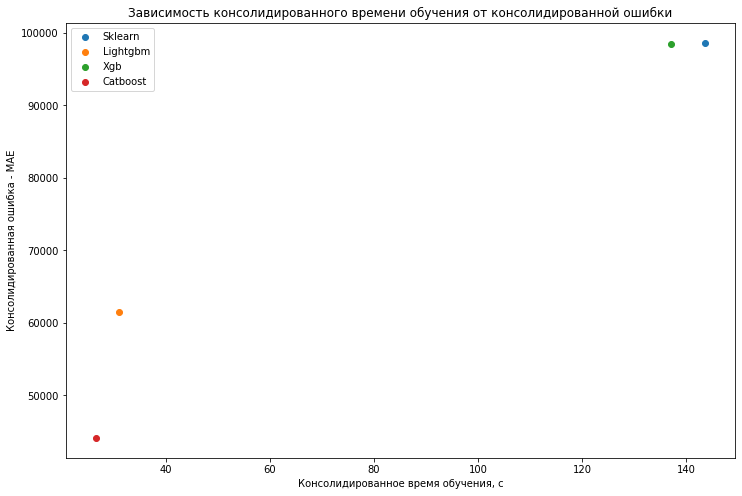

In [431]:
plt.figure(figsize=(12, 8))
plt.scatter(times[0], maes[0])
plt.scatter(times[1], maes[1])
plt.scatter(times[2], maes[2])
plt.scatter(times[3], maes[3])
plt.legend(["Sklearn", "Lightgbm", "Xgb", "Catboost"])
plt.xlabel("Консолидированное время обучения, с")
plt.ylabel("Консолидированная ошибка - MAE")
plt.title("Зависимость консолидированного времени обучения от консолидированной ошибки")
plt.show()

**Ваши выводы:** как видно из графиков

Самая быстрая библиотека - lightgbm
Самая точная - catboost, при этом она не сильно проигрывает во времени lightgbm
Sklearn и xgboost проигрывают и в точности, и во времени обучения

## Оптимизация параметров с hyperopt

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. И я почти уверен, что знаю вашу самую "любимую" часть всех этих заданий: оптимизация параметров. Она достаточно долгая, нудная, да еще и над сетками перебора нужно думать. Значит сейчас, когда вы поняли всю тяжесть этого процесса, мы можем узнать как относительно быстро и безболезненно нащупать оптимальные параметры!


[Эмоции выполняющего в этот момент.](https://disk.yandex.ru/i/qwkvBEFrWYoV9A)


Нашего спасителя зовут HyperOpt. На первый взгляд hyperopt делает всё то же самое, что и grid search, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интарвалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать lightgbm, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.

### Задание 7 (кросс-проверка, 4 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей
**Метрика**: MAE
**Цели**: В данном задании следует выполнить следующие пункты:
1. Взять любую библиотеку градиентного бустинга (можете взять самую быструю)
2. Составить сетку перебора в hyperopt, включающую параметры n_estimators, max_depth и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как hp.choise, hp.qloguniform, hp.uniform и hp.quniform (можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. Реализуйте функцию, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект trials=Trials(), который будет хранить информацию о процессе оптимизации.
5. Используя функцию fmin, оптимизируйте Вашу функцию. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
6. Выведите получившиеся параметры. Нарисуйте график, показывающий значение loss в ходе оптимизации. Посчитайте качество на тесте при использовании лучших параметров (возвращаются после использования fmin). Сделайте выводы по результату.

In [400]:
import warnings
warnings.filterwarnings("ignore")

trials = Trials()

def quality(params):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    model = LGBMRegressor(random_state=42, **params)
    score = -cross_val_score(model, train["A"], train_y, cv=3, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

grid={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 6, 10, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

best = fmin(fn=quality,
                space=grid,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials,
               verbose= 1)




100%|██████████| 50/50 [00:27<00:00,  1.80trial/s, best loss: 14513054564.661177]


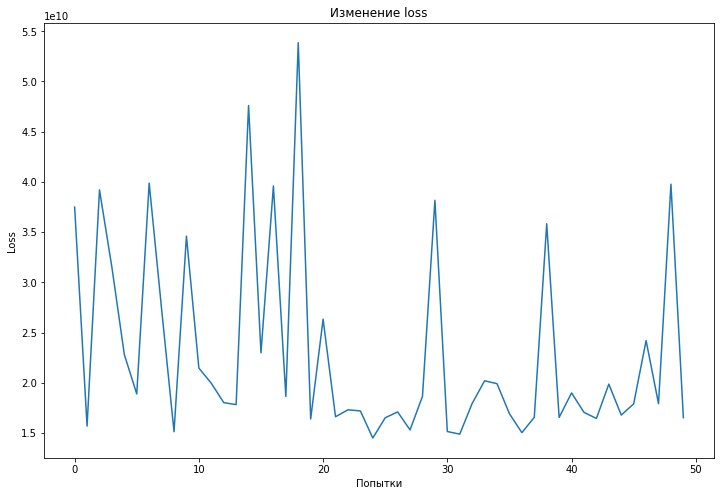

In [445]:
plt.figure(figsize=(12, 8))
plt.xlabel("Попытки")
plt.ylabel("Loss")
plt.title("Изменение loss")
plt.plot(trials.losses())

In [405]:
best

{'learning_rate': 0.3981298815282356, 'max_depth': 10.0, 'n_estimators': 374.0}

In [439]:
model = LGBMRegressor(**{'learning_rate': 0.3981298815282356, 'max_depth': 10, 'n_estimators': 374})
mean_absolute_error(model.fit(train["A"], train_y).predict(test["A"]), test_y)

5062.179790929201

**Ваши выводы:**  hyperopt позволяет быстро подобрать оптимальные параметры и получить низкую ошибку MAE

## Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

**Внимание!** Следующее задание сдается в системе cv-gml.ru, задание `Град. бустинг (ML)` Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт с подобранными параметрами для обучаемого регрессора. Релизовать код необходимо в шаблонном файле awards_prediction.py, который вы можете найти в проверяющей системе.

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма
**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 1 до 3)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 1 до 3)

**actor_i_gender** - пол актера i (i от 1 до 3)

**actor_i_age** - возраст актера i (i от 1 до 3)

-----
**Внимание!** Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

### Задание 8 (ML задание, 20 баллов):
**Данные**: датасет с ценами поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять любую библиотеку градиентного бустинга
2. Используя предложенный датасет, обучить регрессор для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. Загрузить решение и получить качество на закрытой выборке больше порогового значения

In [10]:
## your efficient code here



## Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!
